# Prep & Read all

## imports

In [1]:
import pyarrow as pa
import pyarrow.parquet as pq
import pyarrow.compute as pc

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()
sns.set_style("ticks")

import os
import sys
sys.path.insert(0,'..')

import pandas as pd
import json
import numpy as np

import dask.dataframe as dd
from dask.dataframe.utils import make_meta

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

from src_new.utils import SQLParserSchema, PGLastSchema, get_file_encodings, SQLGlotSchema, SimpleDDLParserSchema,TIDBMysqlSchema, JSqlParserSchema, RustParserSchema

from dask.diagnostics import ProgressBar
ProgressBar().register()

def read_partial(parser, schema_type, cols):
    _outdir = '../out_new/'

    if parser == 'sqlparser':
        p = SQLParserSchema()
        _outdir += 'sqlparser'
    elif parser == 'pglast':
        p = PGLastSchema()
        _outdir += 'pglast'
    elif parser == 'sqlglot':
        p = SQLGlotSchema()
        _outdir += 'sqlglot'
    elif parser == 'simple':
        p = SimpleDDLParserSchema()
        _outdir += 'simpleddlparser'
    elif parser == 'tidb':
        p = TIDBMysqlSchema()
        _outdir += 'tidb_mysql'
    elif parser == 'jsqlparser':
        p = JSqlParserSchema()
        _outdir += 'jsqlparser'
    elif parser == 'rustparser':
        p = RustParserSchema()
        _outdir += 'rustparser'

    if schema_type == 'file':
        _schema = p.file_level_schema
        _outdir += '/'
    elif schema_type == 'stmt':
        _schema = p.statement_list_sch
        _outdir += '_details/'
    
    ddf = dd.read_parquet(_outdir,columns=cols, schema=_schema, split_row_groups=True, calculate_divisions=True,engine='pyarrow')
    return ddf

# Read file details
fd = []
for file in os.listdir('../out_new/filedetails/'):
        full_filename = "%s/%s" % ('../out_new/filedetails/', file)
        with open(full_filename,'r') as fi:
            dict = json.load(fi)
            for item in dict:
                  fd.append(item)

filedetails_df = pd.DataFrame.from_dict(fd)
del fd

C:\Users\geacu\AppData\Local\Temp\ipykernel_17060\668518853.py:27: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('max_colwidth', -1)


## Schema Prep - File level

In [2]:
# schema prep
join_schema = pa.schema([])
join_schema = join_schema.append(pa.field("file_id",pa.string()))

# pglast prep

pglast_ddf = read_partial('pglast','file',PGLastSchema().file_level_schema.names)

import ast
pglast_ddf['x'] = pglast_ddf.apply(
    lambda row:
    #'a',
    [] if row['counter_str'] is None else [item for item in ast.literal_eval(row['counter_str'] or 'None') if 'CreateSeqStmt' in item],
    axis=1,
    meta=('x', 'string'))

pglast_ddf['num_create_seq'] = pglast_ddf.apply(
    lambda row:
    row['x'][0]['CreateSeqStmt'] if len(row['x']) > 0 else 0,
    axis=1,
    meta=('num_create_seq', 'float'))

pglast_ddf = pglast_ddf.drop(columns=['x'])  

pglast_ddf['num_tables_without_create_seq'] = pglast_ddf['num_distinct_tables'] - pglast_ddf['num_create_seq']

pglast_ddf['table_list_str'] = pglast_ddf.apply(
    lambda row:
    "|".join(str(x) for x in sorted(row['table_list'])) if row['table_list'] is not None else None,
    axis=1,
    meta=('table_list_str', 'string'))
pglast_ddf['column_list_str'] = pglast_ddf.apply(
    lambda row:
    "|".join(str(x) for x in sorted(row['columns_list'])) if row['columns_list'] is not None else None,
    axis=1,
    meta=('column_list_str', 'string'))
pglast_ddf['schema_list_str'] = pglast_ddf.apply(
    lambda row:
    "|".join(str(x) for x in sorted(row['schema_list'])) if row['schema_list'] is not None else None,
    axis=1,
    meta=('schema_list_str', 'string'))
pglast_ddf['view_list_str'] = pglast_ddf.apply(
    lambda row:
    "|".join(str(x) for x in sorted(row['view_list'])) if row['view_list'] is not None else None,
    axis=1,
    meta=('view_list_str', 'string'))
pglast_ddf['db_list_str'] = pglast_ddf.apply(
    lambda row:
    "|".join(str(x) for x in sorted(row['db_list'])) if row['db_list'] is not None else None,
    axis=1,
    meta=('db_list_str', 'string'))

try:
    del dict
except:
    pass
pglast_ddf = pglast_ddf.rename(columns=dict(zip(pglast_ddf.columns, [item.replace("pglast_file_id","file_id") for item in ["pglast_" + item for item in pglast_ddf.columns]])))

for item in PGLastSchema().file_level_schema:
    if item.name != 'file_id':
        join_schema = join_schema.append(pa.field("pglast_" + item.name,item.type))
join_schema = join_schema.append(pa.field("pglast_num_create_seq", pa.float64()))
join_schema = join_schema.append(pa.field("pglast_num_tables_without_create_seq", pa.float64()))

join_schema = join_schema.append(pa.field("pglast_table_list_str", pa.string()))
join_schema = join_schema.append(pa.field("pglast_column_list_str", pa.string()))
join_schema = join_schema.append(pa.field("pglast_schema_list_str", pa.string()))
join_schema = join_schema.append(pa.field("pglast_view_list_str", pa.string()))
join_schema = join_schema.append(pa.field("pglast_db_list_str", pa.string()))



In [3]:
# sdp prep

sdp_ddf = read_partial('simple','file',SimpleDDLParserSchema().file_level_schema.names)

sdp_ddf['parsed_file_indulgent'] = sdp_ddf.apply(
    lambda row:
    1 if ((row['parsed_file'] == 1) | 
                    ((row['parsed_file'] == 2) & 
                    ((row['num_distinct_tables'] > 0) |
                     (row['num_distinct_columns'] > 0) |
                     (row['num_constraints'] > 0)
                    )
                  )) else 0,
    axis=1,
    meta=('parsed_file_indulgent', 'int'))

sdp_ddf['table_list_str'] = sdp_ddf.apply(
    lambda row:
    "|".join(str(x) for x in sorted(row['table_list'])) if row['table_list'] is not None else None,
    axis=1,
    meta=('table_list_str', 'string'))
sdp_ddf['column_list_str'] = sdp_ddf.apply(
    lambda row:
    "|".join(str(x) for x in sorted(row['column_list'])) if row['column_list'] is not None else None,
    axis=1,
    meta=('column_list_str', 'string'))
sdp_ddf['schema_list_str'] = sdp_ddf.apply(
    lambda row:
    "|".join(str(x) for x in sorted(row['schema_list'])) if row['schema_list'] is not None else None,
    axis=1,
    meta=('schema_list_str', 'string'))
sdp_ddf['view_list_str'] = sdp_ddf.apply(
    lambda row:
    "|".join(str(x) for x in sorted(row['view_list'])) if row['view_list'] is not None else None,
    axis=1,
    meta=('view_list_str', 'string'))
sdp_ddf['db_list_str'] = sdp_ddf.apply(
    lambda row:
    "|".join(str(x) for x in sorted(row['db_list'])) if row['db_list'] is not None else None,
    axis=1,
    meta=('db_list_str', 'string'))

# renaming cols
sdp_ddf = sdp_ddf.rename(columns=dict(zip(sdp_ddf.columns, [item.replace("sdp_file_id","file_id") for item in ["sdp_" + item for item in sdp_ddf.columns]])))

for item in SimpleDDLParserSchema().file_level_schema:
    if item.name != 'file_id':
        join_schema = join_schema.append(pa.field("sdp_" + item.name,item.type))

join_schema = join_schema.append(pa.field("sdp_parsed_file_indulgent", pa.int64()))

join_schema = join_schema.append(pa.field("sdp_table_list_str", pa.string()))
join_schema = join_schema.append(pa.field("sdp_column_list_str", pa.string()))
join_schema = join_schema.append(pa.field("sdp_schema_list_str", pa.string()))
join_schema = join_schema.append(pa.field("sdp_view_list_str", pa.string()))
join_schema = join_schema.append(pa.field("sdp_db_list_str", pa.string()))


In [4]:
sqlglot_ddf = read_partial('sqlglot','file',SQLGlotSchema().file_level_schema.names)

sqlglot_ddf['table_list_str'] = sqlglot_ddf.apply(
    lambda row:
    "|".join(str(x) for x in sorted(row['table_list'])) if row['table_list'] is not None else None,
    axis=1,
    meta=('table_list_str', 'string'))
sqlglot_ddf['column_list_str'] = sqlglot_ddf.apply(
    lambda row:
    "|".join(str(x) for x in sorted(row['column_list'])) if row['column_list'] is not None else None,
    axis=1,
    meta=('column_list_str', 'string'))
sqlglot_ddf['schema_list_str'] = sqlglot_ddf.apply(
    lambda row:
    "|".join(str(x) for x in sorted(row['schema_list'])) if row['schema_list'] is not None else None,
    axis=1,
    meta=('schema_list_str', 'string'))
sqlglot_ddf['view_list_str'] = sqlglot_ddf.apply(
    lambda row:
    "|".join(str(x) for x in sorted(row['view_list'])) if row['view_list'] is not None else None,
    axis=1,
    meta=('view_list_str', 'string'))
sqlglot_ddf['db_list_str'] = sqlglot_ddf.apply(
    lambda row:
    "|".join(str(x) for x in sorted(row['db_list'])) if row['db_list'] is not None else None,
    axis=1,
    meta=('db_list_str', 'string'))



sqlglot_ddf['postgres_table_list_str'] = sqlglot_ddf.apply(
    lambda row:
    "|".join(str(x) for x in sorted(row['postgres_table_list'])) if row['postgres_table_list'] is not None else None,
    axis=1,
    meta=('postgres_table_list_str', 'string'))
sqlglot_ddf['postgres_column_list_str'] = sqlglot_ddf.apply(
    lambda row:
    "|".join(str(x) for x in sorted(row['postgres_column_list'])) if row['postgres_column_list'] is not None else None,
    axis=1,
    meta=('postgres_column_list_str', 'string'))
sqlglot_ddf['postgres_schema_list_str'] = sqlglot_ddf.apply(
    lambda row:
    "|".join(str(x) for x in sorted(row['postgres_schema_list'])) if row['postgres_schema_list'] is not None else None,
    axis=1,
    meta=('postgres_schema_list_str', 'string'))
sqlglot_ddf['postgres_view_list_str'] = sqlglot_ddf.apply(
    lambda row:
    "|".join(str(x) for x in sorted(row['postgres_view_list'])) if row['postgres_view_list'] is not None else None,
    axis=1,
    meta=('postgres_view_list_str', 'string'))
sqlglot_ddf['postgres_db_list_str'] = sqlglot_ddf.apply(
    lambda row:
    "|".join(str(x) for x in sorted(row['postgres_db_list'])) if row['postgres_db_list'] is not None else None,
    axis=1,
    meta=('postgres_db_list_str', 'string'))

sqlglot_ddf = sqlglot_ddf.rename(columns=dict(zip(sqlglot_ddf.columns, [item.replace("sqlglot_file_id","file_id") for item in ["sqlglot_" + item for item in sqlglot_ddf.columns]])))

for item in SQLGlotSchema().file_level_schema:
    if item.name != 'file_id':
        join_schema = join_schema.append(pa.field("sqlglot_" + item.name,item.type))

join_schema = join_schema.append(pa.field("sqlglot_table_list_str", pa.string()))
join_schema = join_schema.append(pa.field("sqlglot_column_list_str", pa.string()))
join_schema = join_schema.append(pa.field("sqlglot_schema_list_str", pa.string()))
join_schema = join_schema.append(pa.field("sqlglot_view_list_str", pa.string()))
join_schema = join_schema.append(pa.field("sqlglot_db_list_str", pa.string()))

join_schema = join_schema.append(pa.field("sqlglot_postgres_table_list_str", pa.string()))
join_schema = join_schema.append(pa.field("sqlglot_postgres_column_list_str", pa.string()))
join_schema = join_schema.append(pa.field("sqlglot_postgres_schema_list_str", pa.string()))
join_schema = join_schema.append(pa.field("sqlglot_postgres_view_list_str", pa.string()))
join_schema = join_schema.append(pa.field("sqlglot_postgres_db_list_str", pa.string()))

In [5]:
rust_ddf = read_partial('rustparser','file',RustParserSchema().file_level_schema.names)

rust_ddf['table_list_str'] = rust_ddf.apply(
    lambda row:
    "|".join(str(x) for x in sorted(row['table_list'])) if row['table_list'] is not None else None,
    axis=1,
    meta=('table_list_str', 'string'))
rust_ddf['column_list_str'] = rust_ddf.apply(
    lambda row:
    "|".join(str(x) for x in sorted(row['column_list'])) if row['column_list'] is not None else None,
    axis=1,
    meta=('column_list_str', 'string'))
rust_ddf['schema_list_str'] = rust_ddf.apply(
    lambda row:
    "|".join(str(x) for x in sorted(row['schema_list'])) if row['schema_list'] is not None else None,
    axis=1,
    meta=('schema_list_str', 'string'))
rust_ddf['view_list_str'] = rust_ddf.apply(
    lambda row:
    "|".join(str(x) for x in sorted(row['view_list'])) if row['view_list'] is not None else None,
    axis=1,
    meta=('view_list_str', 'string'))
rust_ddf['db_list_str'] = rust_ddf.apply(
    lambda row:
    "|".join(str(x) for x in sorted(row['db_list'])) if row['db_list'] is not None else None,
    axis=1,
    meta=('db_list_str', 'string'))



rust_ddf['postgres_table_list_str'] = rust_ddf.apply(
    lambda row:
    "|".join(str(x) for x in sorted(row['postgres_table_list'])) if row['postgres_table_list'] is not None else None,
    axis=1,
    meta=('postgres_table_list_str', 'string'))
rust_ddf['postgres_column_list_str'] = rust_ddf.apply(
    lambda row:
    "|".join(str(x) for x in sorted(row['postgres_column_list'])) if row['postgres_column_list'] is not None else None,
    axis=1,
    meta=('postgres_column_list_str', 'string'))
rust_ddf['postgres_schema_list_str'] = rust_ddf.apply(
    lambda row:
    "|".join(str(x) for x in sorted(row['postgres_schema_list'])) if row['postgres_schema_list'] is not None else None,
    axis=1,
    meta=('postgres_schema_list_str', 'string'))
rust_ddf['postgres_view_list_str'] = rust_ddf.apply(
    lambda row:
    "|".join(str(x) for x in sorted(row['postgres_view_list'])) if row['postgres_view_list'] is not None else None,
    axis=1,
    meta=('postgres_view_list_str', 'string'))
rust_ddf['postgres_db_list_str'] = rust_ddf.apply(
    lambda row:
    "|".join(str(x) for x in sorted(row['postgres_db_list'])) if row['postgres_db_list'] is not None else None,
    axis=1,
    meta=('postgres_db_list_str', 'string'))

rust_ddf = rust_ddf.rename(columns=dict(zip(rust_ddf.columns, [item.replace("rustparser_file_id","file_id") for item in ["rustparser_" + item for item in rust_ddf.columns]])))

for item in RustParserSchema().file_level_schema:
    if item.name != 'file_id':
        join_schema = join_schema.append(pa.field("rustparser_" + item.name,item.type))

join_schema = join_schema.append(pa.field("rustparser_table_list_str", pa.string()))
join_schema = join_schema.append(pa.field("rustparser_column_list_str", pa.string()))
join_schema = join_schema.append(pa.field("rustparser_schema_list_str", pa.string()))
join_schema = join_schema.append(pa.field("rustparser_view_list_str", pa.string()))
join_schema = join_schema.append(pa.field("rustparser_db_list_str", pa.string()))

join_schema = join_schema.append(pa.field("rustparser_postgres_table_list_str", pa.string()))
join_schema = join_schema.append(pa.field("rustparser_postgres_column_list_str", pa.string()))
join_schema = join_schema.append(pa.field("rustparser_postgres_schema_list_str", pa.string()))
join_schema = join_schema.append(pa.field("rustparser_postgres_view_list_str", pa.string()))
join_schema = join_schema.append(pa.field("rustparser_postgres_db_list_str", pa.string()))

In [6]:
tidb_ddf = read_partial('tidb','file',TIDBMysqlSchema().file_level_schema.names)


tidb_ddf['table_list_str'] = tidb_ddf.apply(
    lambda row:
    "|".join(str(x) for x in sorted(row['table_list'])) if row['table_list'] is not None else None,
    axis=1,
    meta=('table_list_str', 'string'))
tidb_ddf['column_list_str'] = tidb_ddf.apply(
    lambda row:
    "|".join(str(x) for x in sorted(row['column_list'])) if row['column_list'] is not None else None,
    axis=1,
    meta=('column_list_str', 'string'))
tidb_ddf['schema_list_str'] = tidb_ddf.apply(
    lambda row:
    "|".join(str(x) for x in sorted(row['schema_list'])) if row['schema_list'] is not None else None,
    axis=1,
    meta=('schema_list_str', 'string'))
tidb_ddf['view_list_str'] = tidb_ddf.apply(
    lambda row:
    "|".join(str(x) for x in sorted(row['view_list'])) if row['view_list'] is not None else None,
    axis=1,
    meta=('view_list_str', 'string'))
tidb_ddf['db_list_str'] = tidb_ddf.apply(
    lambda row:
    "|".join(str(x) for x in sorted(row['db_list'])) if row['db_list'] is not None else None,
    axis=1,
    meta=('db_list_str', 'string'))

# renaming cols
tidb_ddf = tidb_ddf.rename(columns=dict(zip(tidb_ddf.columns, [item.replace("tidb_file_id","file_id") for item in ["tidb_" + item for item in tidb_ddf.columns]])))

for item in TIDBMysqlSchema().file_level_schema:
    if item.name != 'file_id':
        join_schema = join_schema.append(pa.field("tidb_" + item.name,item.type))

join_schema = join_schema.append(pa.field("tidb_table_list_str", pa.string()))
join_schema = join_schema.append(pa.field("tidb_column_list_str", pa.string()))
join_schema = join_schema.append(pa.field("tidb_schema_list_str", pa.string()))
join_schema = join_schema.append(pa.field("tidb_view_list_str", pa.string()))
join_schema = join_schema.append(pa.field("tidb_db_list_str", pa.string()))


In [7]:
jsql_ddf = read_partial('jsqlparser','file',JSqlParserSchema().file_level_schema.names)


jsql_ddf['table_list_str'] = jsql_ddf.apply(
    lambda row:
    "|".join(str(x) for x in sorted(row['table_list'])) if row['table_list'] is not None else None,
    axis=1,
    meta=('table_list_str', 'string'))
jsql_ddf['column_list_str'] = jsql_ddf.apply(
    lambda row:
    "|".join(str(x) for x in sorted(row['column_list'])) if row['column_list'] is not None else None,
    axis=1,
    meta=('column_list_str', 'string'))
jsql_ddf['schema_list_str'] = jsql_ddf.apply(
    lambda row:
    "|".join(str(x) for x in sorted(row['schema_list'])) if row['schema_list'] is not None else None,
    axis=1,
    meta=('schema_list_str', 'string'))
jsql_ddf['view_list_str'] = jsql_ddf.apply(
    lambda row:
    "|".join(str(x) for x in sorted(row['view_list'])) if row['view_list'] is not None else None,
    axis=1,
    meta=('view_list_str', 'string'))
jsql_ddf['db_list_str'] = jsql_ddf.apply(
    lambda row:
    "|".join(str(x) for x in sorted(row['db_list'])) if row['db_list'] is not None else None,
    axis=1,
    meta=('db_list_str', 'string'))

# renaming cols
jsql_ddf = jsql_ddf.rename(columns=dict(zip(jsql_ddf.columns, [item.replace("jsql_file_id","file_id") for item in ["jsql_" + item for item in jsql_ddf.columns]])))

for item in JSqlParserSchema().file_level_schema:
    if item.name != 'file_id':
        join_schema = join_schema.append(pa.field("jsql_" + item.name,item.type))

join_schema = join_schema.append(pa.field("jsql_table_list_str", pa.string()))
join_schema = join_schema.append(pa.field("jsql_column_list_str", pa.string()))
join_schema = join_schema.append(pa.field("jsql_schema_list_str", pa.string()))
join_schema = join_schema.append(pa.field("jsql_view_list_str", pa.string()))
join_schema = join_schema.append(pa.field("jsql_db_list_str", pa.string()))


## Schema prep - stmt level

In [8]:
# schema prep
stmt_join_schema = pa.schema([])
stmt_join_schema = stmt_join_schema.append(pa.field("file_id",pa.string()))
stmt_join_schema = stmt_join_schema.append(pa.field("statement_nr",pa.string()))

jsql_details_ddf = read_partial('jsqlparser','stmt',['file_id','statement_nr','parsed','parse_error','parse_error_with_brackets','valid_ansi','valid_oracle','valid_mysql','valid_postgres','valid_sqlserver'])
for item in JSqlParserSchema().statement_list_sch:
    if item.name != 'file_id' and item.name != 'statement_nr' and item.name != 'statement_id' and item.name in jsql_details_ddf.columns:
        stmt_join_schema = stmt_join_schema.append(pa.field("jsql_" + item.name,item.type))
try:
    del dict
except:
    pass
jsql_details_ddf = jsql_details_ddf.rename(columns=dict(zip(jsql_details_ddf.columns, [item.replace("jsql_file_id","file_id").replace('jsql_statement_nr','statement_nr') for item in ["jsql_" + item for item in jsql_details_ddf.columns]])))
jsql_details_ddf['statement_nr'] = jsql_details_ddf['statement_nr'].apply(lambda x: str(x),meta=('statement_nr','string'))  

pglast_details_ddf = read_partial('pglast','stmt',['file_id','statement_nr','parsed','parse_error'])
for item in PGLastSchema().statement_list_sch:
    if item.name != 'file_id' and item.name != 'statement_nr' and item.name != 'statement_id' and item.name in pglast_details_ddf.columns:
        stmt_join_schema = stmt_join_schema.append(pa.field("pglast_" + item.name,item.type))
try:
    del dict
except:
    pass
pglast_details_ddf = pglast_details_ddf.rename(columns=dict(zip(pglast_details_ddf.columns, [item.replace("pglast_file_id","file_id").replace('pglast_statement_nr','statement_nr') for item in ["pglast_" + item for item in pglast_details_ddf.columns]])))
pglast_details_ddf['statement_nr'] = pglast_details_ddf['statement_nr'].apply(lambda x: str(x),meta=('statement_nr','string')) 

tidb_details_ddf = read_partial('tidb','stmt',['file_id','statement_nr','parsed','parse_error'])
for item in TIDBMysqlSchema().statement_list_sch:
    if item.name != 'file_id' and item.name != 'statement_nr' and item.name != 'statement_id' and item.name in tidb_details_ddf.columns:
        stmt_join_schema = stmt_join_schema.append(pa.field("tidb_" + item.name,item.type))
try:
    del dict
except:
    pass
tidb_details_ddf = tidb_details_ddf.rename(columns=dict(zip(tidb_details_ddf.columns, [item.replace("tidb_file_id","file_id").replace('tidb_statement_nr','statement_nr') for item in ["tidb_" + item for item in tidb_details_ddf.columns]])))
tidb_details_ddf['statement_nr'] = tidb_details_ddf['statement_nr'].apply(lambda x: str(x),meta=('statement_nr','string')) 

pglast_joined_jsql= dd.merge(
    pglast_details_ddf,
    jsql_details_ddf,
    on=['file_id','statement_nr'],
    how='inner',indicator=False,suffixes=['_pglast','_jsql'])

pglast_joined_jsql_and_tidb= dd.merge(
    pglast_joined_jsql,
    tidb_details_ddf,
    on=['file_id','statement_nr'],
    how='inner',indicator=False,suffixes=[None,'_tidb'])

#pglast_joined_jsql_and_tidb.to_parquet('../out_new/stmt_join__parsed__all/',schema=stmt_join_schema,overwrite=True)

intermediary_stmt_ddf = dd.read_parquet('../out_new/stmt_join__parsed__all/', columns = stmt_join_schema.names ,schema=stmt_join_schema, split_row_groups=True, calculate_divisions=True,engine='pyarrow')

intermediary_stmt_ddf['statement_nr'] = intermediary_stmt_ddf['statement_nr'].apply(lambda x: str(x),meta=('statement_nr','string')) 

rust_details_ddf = read_partial('rustparser','stmt',['file_id','statement_id','parsed','parsed_generic','parsed_ansi','parsed_postgres','parsed_mysql','parsed_ms','dialect','parse_error'])
rust_details_ddf['statement_nr'] = rust_details_ddf['statement_id']
rust_details_ddf = rust_details_ddf[['file_id','statement_nr','parsed','parsed_generic','parsed_ansi','parsed_postgres','parsed_mysql','parsed_ms','dialect','parse_error']]
for item in RustParserSchema().statement_list_sch:
    if item.name != 'file_id' and item.name != 'statement_nr' and item.name != 'statement_id' and item.name in rust_details_ddf.columns:
        stmt_join_schema = stmt_join_schema.append(pa.field("rust_" + item.name,item.type))
try:
    del dict
except:
    pass
rust_details_ddf = rust_details_ddf.rename(columns=dict(zip(rust_details_ddf.columns, [item.replace("rust_file_id","file_id").replace('rust_statement_nr','statement_nr') for item in ["rust_" + item for item in rust_details_ddf.columns]])))
rust_details_ddf['statement_nr'] = rust_details_ddf['statement_nr'].apply(lambda x: str(x),meta=('statement_nr','string')) 

sqlglot_details_ddf = read_partial('sqlglot','stmt',['file_id','statement_id','parsed','parsed_none','parsed_postgres','parsed_mysql','parsed_tsql','dialect','parse_error','file_parse_error_start_context','file_parse_error_highlight'])
sqlglot_details_ddf['statement_nr'] = sqlglot_details_ddf['statement_id']
sqlglot_details_ddf = sqlglot_details_ddf[['file_id','statement_nr','parsed','parsed_none','parsed_postgres','parsed_mysql','parsed_tsql','dialect','parse_error','file_parse_error_start_context','file_parse_error_highlight']]
for item in SQLGlotSchema().statement_list_sch:
    if item.name != 'file_id' and item.name != 'statement_nr' and item.name != 'statement_id' and item.name in sqlglot_details_ddf.columns:
        stmt_join_schema = stmt_join_schema.append(pa.field("sqlglot_" + item.name,item.type))
try:
    del dict
except:
    pass
sqlglot_details_ddf = sqlglot_details_ddf.rename(columns=dict(zip(sqlglot_details_ddf.columns, [item.replace("sqlglot_file_id","file_id").replace('sqlglot_statement_nr','statement_nr') for item in ["sqlglot_" + item for item in sqlglot_details_ddf.columns]])))
sqlglot_details_ddf['statement_nr'] = sqlglot_details_ddf['statement_nr'].apply(lambda x: str(x),meta=('statement_nr','string')) 


pglast_joined_jsql_and_tidb_rust= dd.merge(
    intermediary_stmt_ddf,
    rust_details_ddf,
    on=['file_id','statement_nr'],
    how='inner',indicator=False,suffixes=[None,'_rust'])

pglast_joined_jsql_and_tidb_rust_sqlglot= dd.merge(
    pglast_joined_jsql_and_tidb_rust,
    sqlglot_details_ddf,
    on=['file_id','statement_nr'],
    how='inner',indicator=False,suffixes=[None,'_sqlglot'])

# sdp prep
pglast_joined_jsql_and_tidb_rust_sqlglot['statement_nr'] = pglast_joined_jsql_and_tidb_rust_sqlglot['statement_nr'].apply(lambda x: str(x),meta=('statement_nr','string')) 

sdp_details_ddf = read_partial('simple','stmt',['file_id','statement_nr','parsed','parse_error','value_error_present'])

sdp_details_ddf['parsed_indulgent'] = sdp_details_ddf.apply(
    lambda row:
    1 if ((row['parsed'] == 1) | 
                    ((row['parsed'] == 2) & 
                    ((row['num_distinct_tables'] > 0) |
                     (row['num_distinct_columns'] > 0) |
                     (row['num_constraints'] > 0)
                    )
                  )) else 0,
    axis=1,
    meta=('parsed_indulgent', 'int'))

for item in SimpleDDLParserSchema().statement_list_sch:
    if item.name != 'file_id' and item.name != 'statement_nr' and item.name != 'statement_id' and item.name in sdp_details_ddf.columns:
        stmt_join_schema = stmt_join_schema.append(pa.field("sdp_" + item.name,item.type))

stmt_join_schema = stmt_join_schema.append(pa.field("sdp_parsed_indulgent",pa.int64()))

try:
    del dict
except:
    pass
sdp_details_ddf = sdp_details_ddf.rename(columns=dict(zip(sdp_details_ddf.columns, [item.replace("sdp_file_id","file_id").replace('sdp_statement_nr','statement_nr') for item in ["sdp_" + item for item in sdp_details_ddf.columns]])))
sdp_details_ddf['statement_nr'] = sdp_details_ddf['statement_nr'].apply(lambda x: str(x),meta=('statement_nr','string')) 

joined_stmt_ddf_incl_sdp= dd.merge(
    pglast_joined_jsql_and_tidb_rust_sqlglot,
    sdp_details_ddf,
    on=['file_id','statement_nr'],
    how='inner',indicator=False,suffixes=[None,'_sdp'])



## Read

In [9]:
joined_ddf = dd.read_parquet('../out_new/join__parsed__all/', columns = join_schema.names ,schema=join_schema, split_row_groups=True, calculate_divisions=True,engine='pyarrow')

In [65]:
joined_stmt_ddf = dd.read_parquet('../out_new/stmt_join__parsed__all_final_incl_SDP/', columns = stmt_join_schema.names ,schema=stmt_join_schema, split_row_groups=True, calculate_divisions=True,engine='pyarrow')

# Analysis

## File level SR

In [80]:
filedetails_df['file_id'].count()

373156

In [14]:
# pglast
pglast_sr = joined_ddf.groupby('pglast_parsed_file')['pglast_parsed_file'].count().compute()
pglast_sr = pd.DataFrame({'success':pglast_sr.index, 'count':pglast_sr.values})
pglast_sr['percentage'] = pglast_sr['count']/filedetails_df['file_id'].count()
pglast_sr['parser'] = 'pglast'

# simple-ddl-parser
sdp_sr = joined_ddf.groupby('sdp_parsed_file')['sdp_parsed_file'].count().compute()
sdp_sr = pd.DataFrame({'success':[0,1], 'count':[sdp_sr[sdp_sr.index != 1].sum(),sdp_sr[sdp_sr.index == 1].sum()]})
sdp_sr['percentage'] = sdp_sr['count']/filedetails_df['file_id'].count()
sdp_sr['parser'] = 'simple-ddl-parser'

sdp_ind_sr = joined_ddf.groupby('sdp_parsed_file_indulgent')['sdp_parsed_file_indulgent'].count().compute()
sdp_ind_sr = pd.DataFrame({'success':sdp_ind_sr.index, 'count': sdp_ind_sr.values})
sdp_ind_sr['percentage'] = sdp_ind_sr['count']/filedetails_df['file_id'].count()
sdp_ind_sr['parser'] = 'simple-ddl-parser_silent'

# sqlglot
sqlglot_parsed_sr = joined_ddf.groupby('sqlglot_parsed')['sqlglot_parsed'].count().compute()
sqlglot_parsed_sr = pd.DataFrame({'success':sqlglot_parsed_sr.index, 'count': sqlglot_parsed_sr.values})
sqlglot_parsed_sr['percentage'] = sqlglot_parsed_sr['count']/filedetails_df['file_id'].count()
sqlglot_parsed_sr['parser'] = 'sqlglot_first_dialect'

sqlglot_ansi_sr = joined_ddf.groupby('sqlglot_parsed_none')['sqlglot_parsed_none'].count().compute()
sqlglot_ansi_sr = pd.DataFrame({'success':sqlglot_ansi_sr.index, 'count': sqlglot_ansi_sr.values})
sqlglot_ansi_sr['percentage'] = sqlglot_ansi_sr['count']/filedetails_df['file_id'].count()
sqlglot_ansi_sr['parser'] = 'sqlglot_ANSI'

sqlglot_postgres_sr = joined_ddf.groupby('sqlglot_parsed_postgres')['sqlglot_parsed_postgres'].count().compute()
sqlglot_postgres_sr = pd.DataFrame({'success':sqlglot_postgres_sr.index, 'count': sqlglot_postgres_sr.values})
sqlglot_postgres_sr['percentage'] = sqlglot_postgres_sr['count']/filedetails_df['file_id'].count()
sqlglot_postgres_sr['parser'] = 'sqlglot_POSTGRES'

sqlglot_mysql_sr = joined_ddf.groupby('sqlglot_parsed_mysql')['sqlglot_parsed_mysql'].count().compute()
sqlglot_mysql_sr = pd.DataFrame({'success':sqlglot_mysql_sr.index, 'count': sqlglot_mysql_sr.values})
sqlglot_mysql_sr['percentage'] = sqlglot_mysql_sr['count']/filedetails_df['file_id'].count()
sqlglot_mysql_sr['parser'] = 'sqlglot_MYSQL'


sqlglot_tsql_sr = joined_ddf.groupby('sqlglot_parsed_tsql')['sqlglot_parsed_tsql'].count().compute()
sqlglot_tsql_sr = pd.DataFrame({'success':sqlglot_tsql_sr.index, 'count': sqlglot_tsql_sr.values})
sqlglot_tsql_sr['percentage'] = sqlglot_tsql_sr['count']/filedetails_df['file_id'].count()
sqlglot_tsql_sr['parser'] = 'sqlglot_TSQL'

# tidb
tidb_sr = joined_ddf.groupby('tidb_parsed_file')['tidb_parsed_file'].count().compute()
tidb_sr = pd.DataFrame({'success':tidb_sr.index, 'count': tidb_sr.values})
tidb_sr['percentage'] = tidb_sr['count']/filedetails_df['file_id'].count()
tidb_sr['parser'] = 'tidb'

# rust

rust_parsed_sr = joined_ddf.groupby('rustparser_parsed')['rustparser_parsed'].count().compute()
rust_parsed_sr = pd.DataFrame({'success':rust_parsed_sr.index, 'count': rust_parsed_sr.values})
rust_parsed_sr['percentage'] = rust_parsed_sr['count']/filedetails_df['file_id'].count()
rust_parsed_sr['parser'] = 'rustparser_first_dialect'

rust_generic_parsed_sr = joined_ddf.groupby('rustparser_parsed_generic')['rustparser_parsed_generic'].count().compute()
rust_generic_parsed_sr = pd.DataFrame({'success':rust_generic_parsed_sr.index, 'count': rust_generic_parsed_sr.values})
rust_generic_parsed_sr['percentage'] = rust_generic_parsed_sr['count']/filedetails_df['file_id'].count()
rust_generic_parsed_sr['parser'] = 'rustparser_generic'

rust_ansi_parsed_sr = joined_ddf.groupby('rustparser_parsed_ansi')['rustparser_parsed_ansi'].count().compute()
rust_ansi_parsed_sr = pd.DataFrame({'success':rust_ansi_parsed_sr.index, 'count': rust_ansi_parsed_sr.values})
rust_ansi_parsed_sr['percentage'] = rust_ansi_parsed_sr['count']/filedetails_df['file_id'].count()
rust_ansi_parsed_sr['parser'] = 'rustparser_ansi'

rust_postgres_parsed_sr = joined_ddf.groupby('rustparser_parsed_postgres')['rustparser_parsed_postgres'].count().compute()
rust_postgres_parsed_sr = pd.DataFrame({'success':rust_postgres_parsed_sr.index, 'count': rust_postgres_parsed_sr.values})
rust_postgres_parsed_sr['percentage'] = rust_postgres_parsed_sr['count']/filedetails_df['file_id'].count()
rust_postgres_parsed_sr['parser'] = 'rustparser_postgres'

rust_mysql_parsed_sr = joined_ddf.groupby('rustparser_parsed_mysql')['rustparser_parsed_mysql'].count().compute()
rust_mysql_parsed_sr = pd.DataFrame({'success':rust_mysql_parsed_sr.index, 'count': rust_mysql_parsed_sr.values})
rust_mysql_parsed_sr['percentage'] = rust_mysql_parsed_sr['count']/filedetails_df['file_id'].count()
rust_mysql_parsed_sr['parser'] = 'rustparser_mysql'

rust_tsql_parsed_sr = joined_ddf.groupby('rustparser_parsed_ms')['rustparser_parsed_ms'].count().compute()
rust_tsql_parsed_sr = pd.DataFrame({'success':rust_tsql_parsed_sr.index, 'count': rust_tsql_parsed_sr.values})
rust_tsql_parsed_sr['percentage'] = rust_tsql_parsed_sr['count']/filedetails_df['file_id'].count()
rust_tsql_parsed_sr['parser'] = 'rustparser_tsql'

# jsql

jsql_parsed_sr = joined_ddf.groupby('jsql_parsed_file')['jsql_parsed_file'].count().compute()
jsql_parsed_sr = pd.DataFrame({'success':jsql_parsed_sr.index, 'count': jsql_parsed_sr.values})
jsql_parsed_sr['percentage'] = jsql_parsed_sr['count']/filedetails_df['file_id'].count()
jsql_parsed_sr['parser'] = 'jsqlparser'

"""
jsql_valid_ansi = joined_ddf.groupby('jsql_valid_ansi')['jsql_valid_ansi'].count().compute()
jsql_valid_ansi = pd.DataFrame({'success':jsql_valid_ansi.index, 'count': jsql_valid_ansi.values})
jsql_valid_ansi['percentage'] = jsql_valid_ansi['count']/filedetails_df['file_id'].count()
jsql_valid_ansi['parser'] = 'jsqlparser_VALID_ansi'

jsql_valid_oracle = joined_ddf.groupby('jsql_valid_oracle')['jsql_valid_oracle'].count().compute()
jsql_valid_oracle = pd.DataFrame({'success':jsql_valid_oracle.index, 'count': jsql_valid_oracle.values})
jsql_valid_oracle['percentage'] = jsql_valid_oracle['count']/filedetails_df['file_id'].count()
jsql_valid_oracle['parser'] = 'jsqlparser_VALID_oracle'

jsql_valid_mysql = joined_ddf.groupby('jsql_valid_mysql')['jsql_valid_mysql'].count().compute()
jsql_valid_mysql = pd.DataFrame({'success':jsql_valid_mysql.index, 'count': jsql_valid_mysql.values})
jsql_valid_mysql['percentage'] = jsql_valid_mysql['count']/filedetails_df['file_id'].count()
jsql_valid_mysql['parser'] = 'jsqlparser_VALID_mysql'

jsql_valid_postgres = joined_ddf.groupby('jsql_valid_postgres')['jsql_valid_postgres'].count().compute()
jsql_valid_postgres = pd.DataFrame({'success':jsql_valid_postgres.index, 'count': jsql_valid_postgres.values})
jsql_valid_postgres['percentage'] = jsql_valid_postgres['count']/filedetails_df['file_id'].count()
jsql_valid_postgres['parser'] = 'jsqlparser_VALID_postgres'

jsql_valid_sqlserver = joined_ddf.groupby('jsql_valid_sqlserver')['jsql_valid_sqlserver'].count().compute()
jsql_valid_sqlserver = pd.DataFrame({'success':jsql_valid_sqlserver.index, 'count': jsql_valid_sqlserver.values})
jsql_valid_sqlserver['percentage'] = jsql_valid_sqlserver['count']/filedetails_df['file_id'].count()
jsql_valid_sqlserver['parser'] = 'jsqlparser_VALID_sqlserver'
"""
# merge

merged_sr_file_level = pd.concat([pglast_sr,sdp_sr,sdp_ind_sr,sqlglot_parsed_sr,sqlglot_ansi_sr,
                                  sqlglot_postgres_sr,sqlglot_mysql_sr,sqlglot_tsql_sr,
                                  tidb_sr,rust_parsed_sr, rust_generic_parsed_sr, rust_ansi_parsed_sr, rust_postgres_parsed_sr,
                                  rust_mysql_parsed_sr, rust_tsql_parsed_sr, jsql_parsed_sr
                                  #jsql_valid_ansi,jsql_valid_oracle,jsql_valid_mysql,jsql_valid_postgres,jsql_valid_sqlserver
                                ],ignore_index=True)


[                                        ] | 0% Completed | 649.30 us

[########################################] | 100% Completed | 1.06 sms
[########################################] | 100% Completed | 1.10 sms
[########################################] | 100% Completed | 1.09 sms
[########################################] | 100% Completed | 1.15 sms
[########################################] | 100% Completed | 1.19 sms
[########################################] | 100% Completed | 1.26 sms
[########################################] | 100% Completed | 1.28 sms
[########################################] | 100% Completed | 1.44 sms
[########################################] | 100% Completed | 1.26 sms
[########################################] | 100% Completed | 1.12 sms
[########################################] | 100% Completed | 1.06 sms
[########################################] | 100% Completed | 1.15 sms
[########################################] | 100% Completed | 1.17 sms
[########################################] | 100% Completed | 1.38 sms
[#####

In [27]:
output_merged_sr_file_level = merged_sr_file_level

output_merged_sr_file_level['result'] = np.select(
    [
        output_merged_sr_file_level['success'] == 0,
        output_merged_sr_file_level['success'] == 1,
    ], 
    [
        'Not Parsed', 
        'Parsed'
    ], 
    default='Unknown'
)

output_merged_sr_file_level['%'] = (output_merged_sr_file_level['percentage']*100).map('{:,.3f}'.format)

output_merged_sr_file_level = output_merged_sr_file_level[['parser','result','count','%']]

display(output_merged_sr_file_level)

,parser,result,count,%
30,jsqlparser,Not Parsed,255294,68.415
31,jsqlparser,Parsed,117862,31.585
0,pglast,Not Parsed,309219,82.866
1,pglast,Parsed,63937,17.134
22,rustparser_ansi,Not Parsed,310771,83.282
23,rustparser_ansi,Parsed,62385,16.718
18,rustparser_first_dialect,Not Parsed,279977,75.029
19,rustparser_first_dialect,Parsed,93179,24.971
20,rustparser_generic,Not Parsed,302216,80.989
21,rustparser_generic,Parsed,70940,19.011


In [93]:
display(output_merged_sr_file_level[output_merged_sr_file_level.result=='Parsed'])

,parser,result,count,%
31,jsqlparser,Parsed,117862,31.585
1,pglast,Parsed,63937,17.134
23,rustparser_ansi,Parsed,62385,16.718
19,rustparser_first_dialect,Parsed,93179,24.971
21,rustparser_generic,Parsed,70940,19.011
27,rustparser_mysql,Parsed,78219,20.961
25,rustparser_postgres,Parsed,65184,17.468
29,rustparser_tsql,Parsed,64494,17.283
3,simple-ddl-parser,Parsed,64891,17.390
5,simple-ddl-parser_silent,Parsed,223337,59.851


In [30]:
print(output_merged_sr_file_level.to_latex(
    index=False,
))

\begin{tabular}{llrl}
\toprule
                  parser &     result &  count &      \% \\
\midrule
jsqlparser & Not Parsed & 255294 & 68.415 \\
jsqlparser & Parsed & 117862 & 31.585 \\
pglast & Not Parsed & 309219 & 82.866 \\
pglast & Parsed & 63937 & 17.134 \\
rustparser\_ansi & Not Parsed & 310771 & 83.282 \\
rustparser\_ansi & Parsed & 62385 & 16.718 \\
rustparser\_first\_dialect & Not Parsed & 279977 & 75.029 \\
rustparser\_first\_dialect & Parsed & 93179 & 24.971 \\
rustparser\_generic & Not Parsed & 302216 & 80.989 \\
rustparser\_generic & Parsed & 70940 & 19.011 \\
rustparser\_mysql & Not Parsed & 294937 & 79.039 \\
rustparser\_mysql & Parsed & 78219 & 20.961 \\
rustparser\_postgres & Not Parsed & 307972 & 82.532 \\
rustparser\_postgres & Parsed & 65184 & 17.468 \\
rustparser\_tsql & Not Parsed & 308662 & 82.717 \\
rustparser\_tsql & Parsed & 64494 & 17.283 \\
simple-ddl-parser & Not Parsed & 308265 & 82.610 \\
simple-ddl-parser & Parsed & 64891 & 17.390 \\
simple-ddl-parser\_s

C:\Users\geacu\AppData\Local\Temp\ipykernel_11152\4236415620.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(output_merged_sr_file_level.to_latex(


Text(0.5, 1.0, 'Success rate at file level')

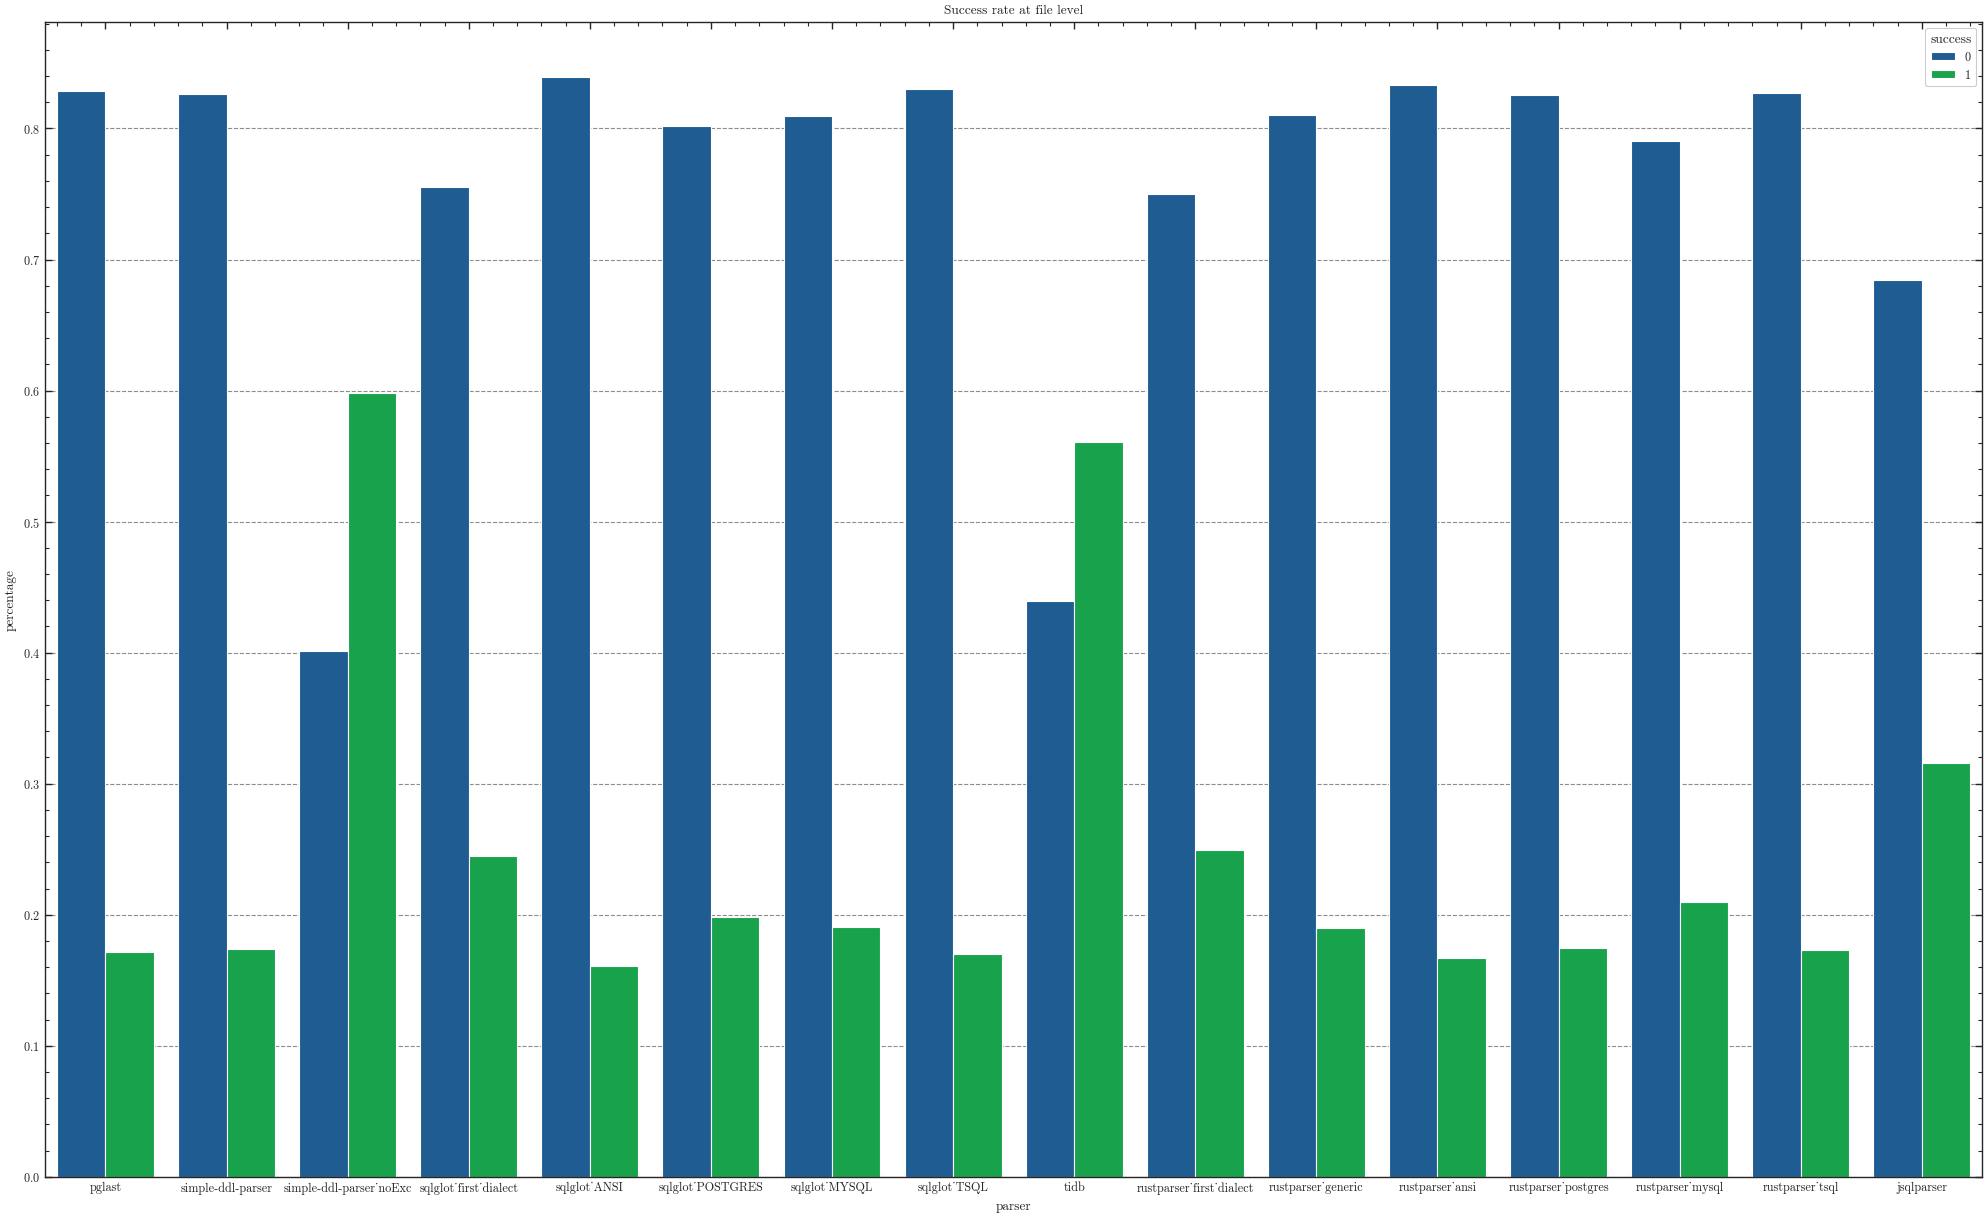

In [13]:
import scienceplots
plt.style.use(['science','no-latex','grid'])

plt.figure(figsize=(25, 15))
sns.set_context("paper")
ax = sns.barplot(data=merged_sr_file_level,x='parser',y='percentage',hue='success')
ax.set_title('Success rate at file level')

In [86]:
file_level_plot = merged_sr_file_level.loc[~merged_sr_file_level['parser'].isin([
    'rustparser_ansi',
    'rustparser_generic',
    'rustparser_mysql',
    'rustparser_postgres',
    'rustparser_tsql',
    'sqlglot_ANSI',
    'sqlglot_MYSQL',
    'sqlglot_POSTGRES',
    'sqlglot_TSQL'
])]

file_level_plot['Parser']=np.select(
    [
        file_level_plot['parser'] == 'rustparser_first_dialect',
        file_level_plot['parser'] == 'sqlglot_first_dialect',
        file_level_plot['parser'] == 'simple-ddl-parser_silent'
    ], 
    [
        'sqlparser-rs -- first dialect', 
        'sqlglot -- first dialect', 
        'simple-ddl-parser -- silent'
    ], 
    default=file_level_plot['parser']
)

display(file_level_plot)

C:\Users\geacu\AppData\Local\Temp\ipykernel_11152\3086871616.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file_level_plot['Parser']=np.select(


,success,count,percentage,parser,result,%,Parser
30,0,255294,0.684148,jsqlparser,Not Parsed,68.415,jsqlparser
31,1,117862,0.315852,jsqlparser,Parsed,31.585,jsqlparser
0,0,309219,0.828659,pglast,Not Parsed,82.866,pglast
1,1,63937,0.171341,pglast,Parsed,17.134,pglast
18,0,279977,0.750295,rustparser_first_dialect,Not Parsed,75.029,sqlparser-rs -- first dialect
19,1,93179,0.249705,rustparser_first_dialect,Parsed,24.971,sqlparser-rs -- first dialect
2,0,308265,0.826102,simple-ddl-parser,Not Parsed,82.610,simple-ddl-parser
3,1,64891,0.173898,simple-ddl-parser,Parsed,17.390,simple-ddl-parser
4,0,149819,0.401492,simple-ddl-parser_silent,Not Parsed,40.149,simple-ddl-parser -- silent
5,1,223337,0.598508,simple-ddl-parser_silent,Parsed,59.851,simple-ddl-parser -- silent


C:\Users\geacu\AppData\Local\Temp\ipykernel_11152\3806380043.py:10: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(20)
C:\Users\geacu\AppData\Local\Temp\ipykernel_11152\3806380043.py:13: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(20)


Text(0.5, 1.0, 'Percentage of whole files that can be parsed successfuly')

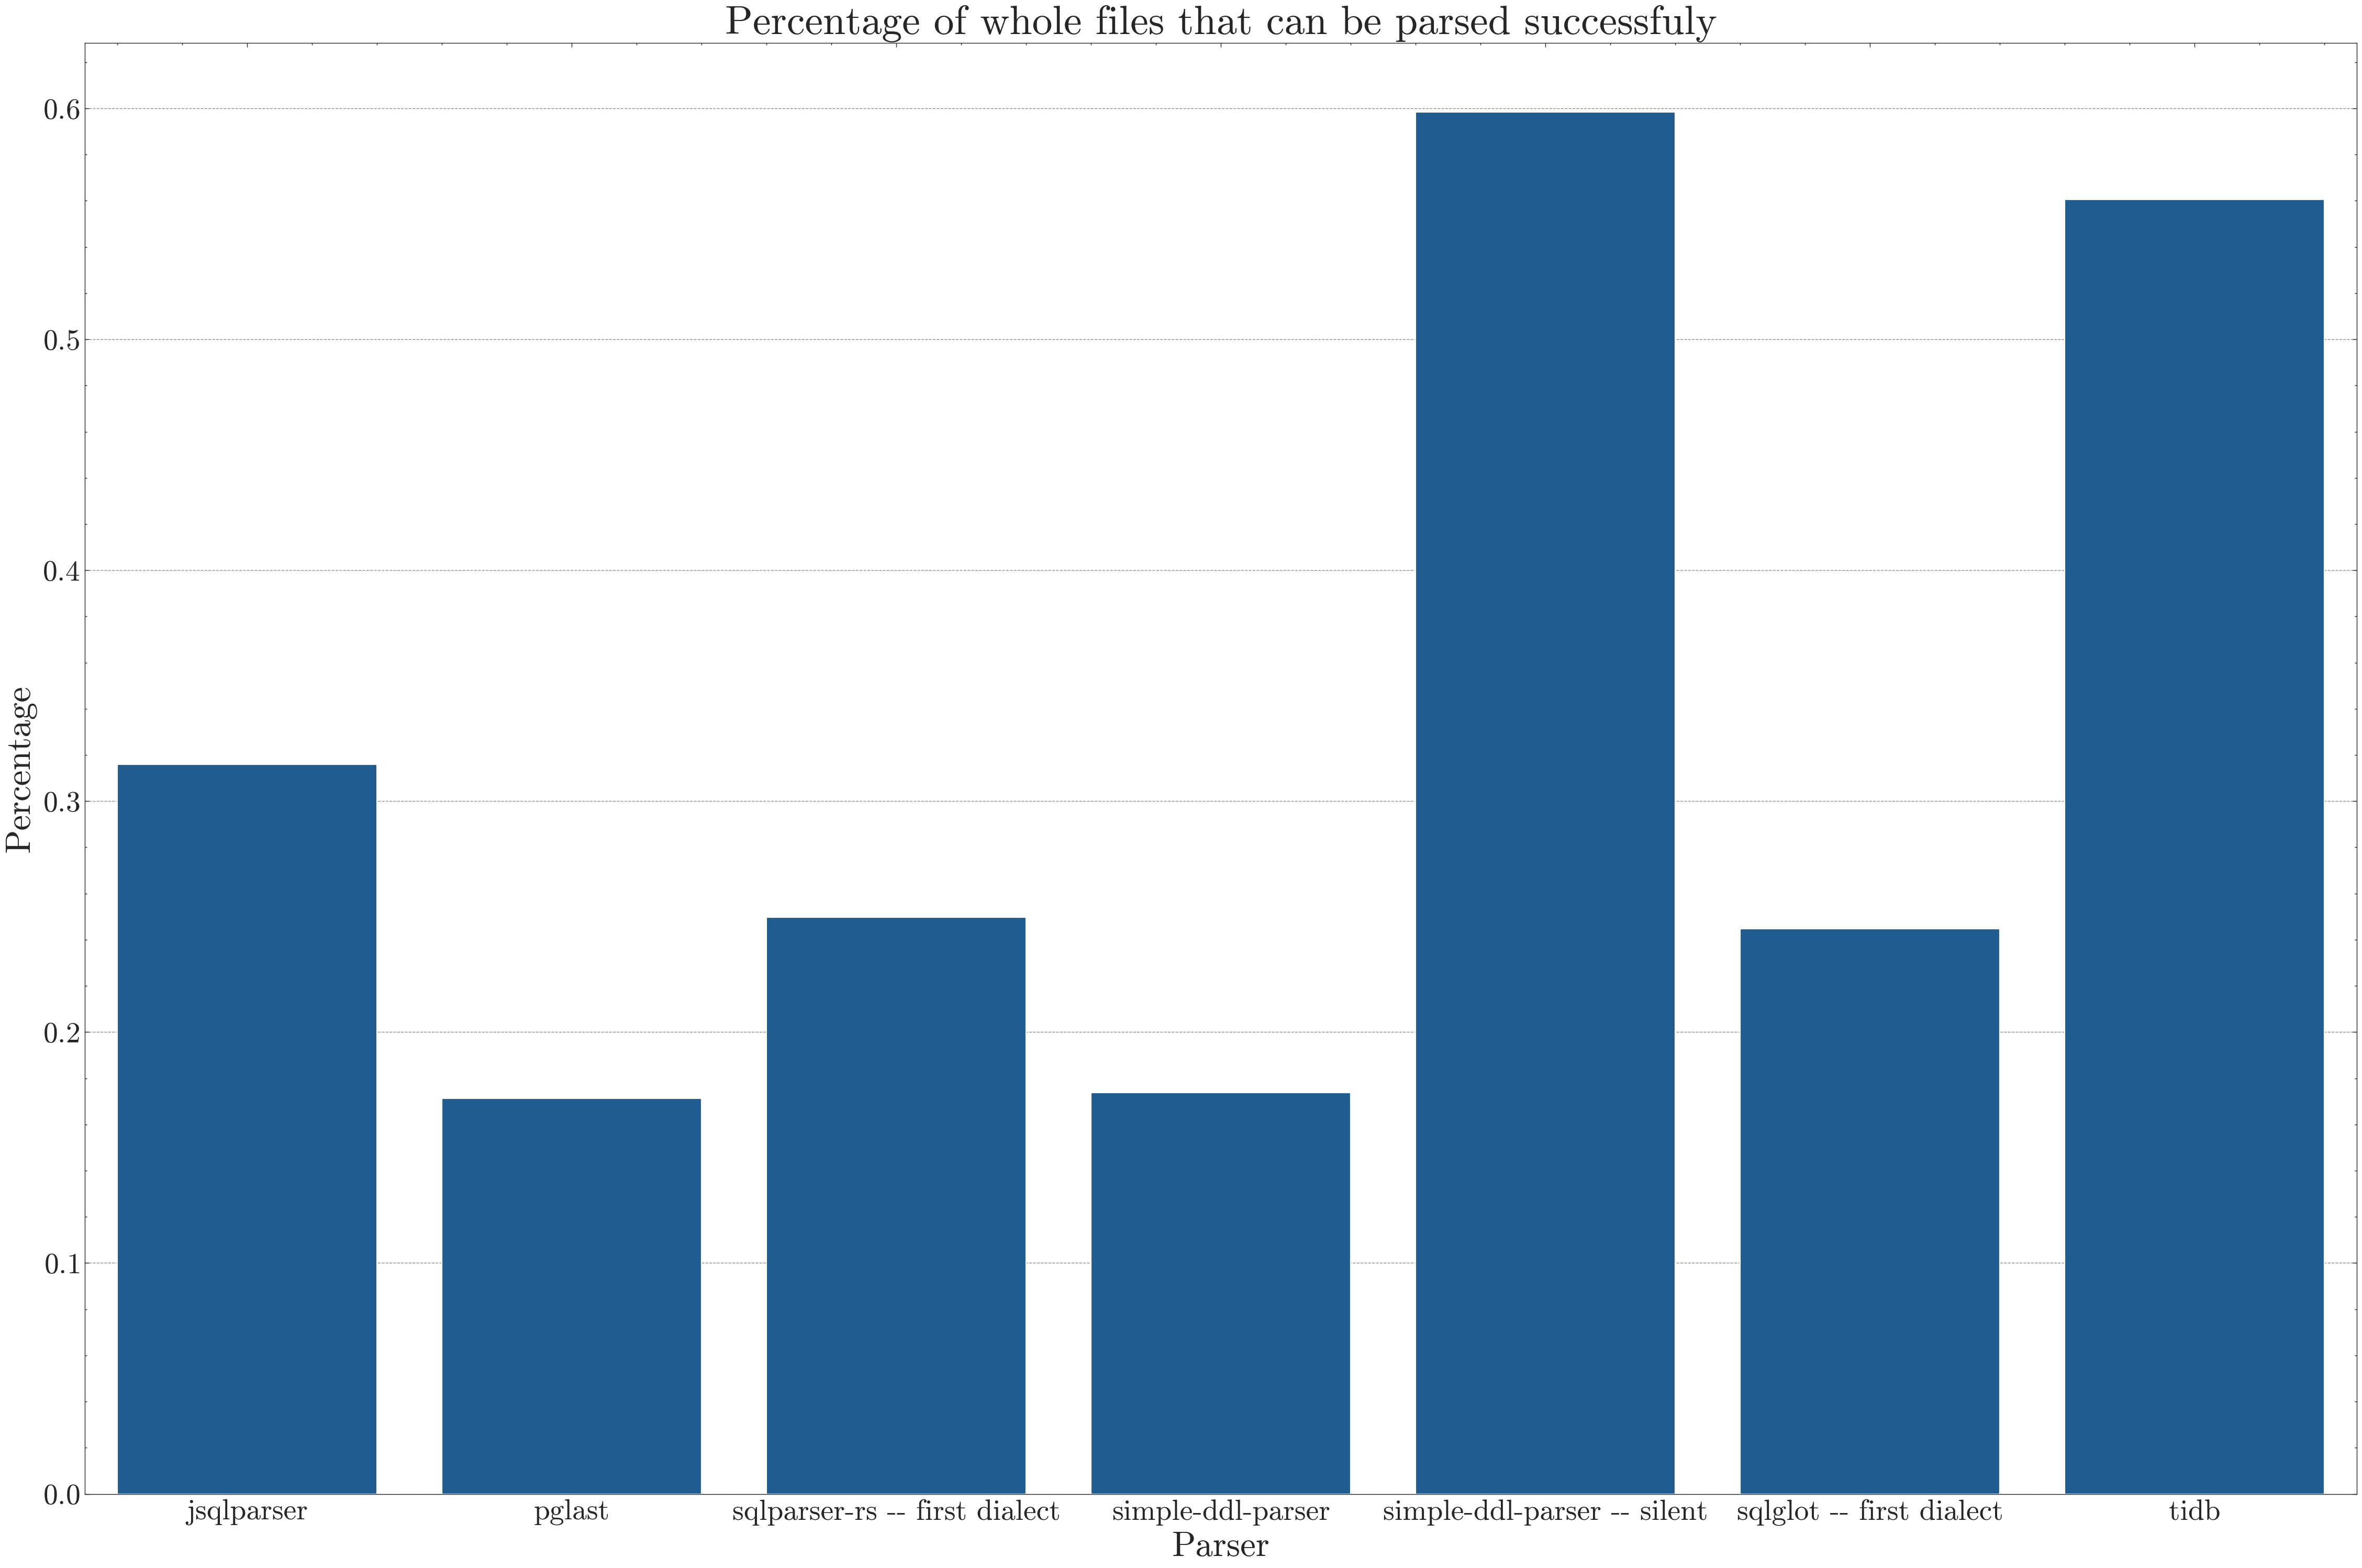

In [88]:
import scienceplots
plt.style.use(['science','no-latex','grid'])
x = plt.figure(figsize=(28, 18),dpi=200)

ax = sns.barplot(data=file_level_plot[file_level_plot.success == 1],x='Parser',y='percentage',hue='success')
ax.set_xlabel("Parser",fontsize=24)
ax.set_ylabel("Percentage",fontsize=24)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)

ax.get_legend().remove()

ax.set_title('Percentage of whole files that can be parsed successfuly',fontsize=28)

## stmt level

In [59]:
nr_of_stmts = joined_stmt_ddf['file_id'].count().compute()

[                                        ] | 0% Completed | 671.00 us

[########################################] | 100% Completed | 7.41 ss


In [94]:
print(nr_of_stmts)

24627506


In [70]:
#pglast
pglast_st_sr = joined_stmt_ddf.groupby('pglast_parsed')['pglast_parsed'].count().compute()
pglast_st_sr = pd.DataFrame({'success':pglast_st_sr.index, 'count':pglast_st_sr.values})
pglast_st_sr['percentage'] = pglast_st_sr['count']/nr_of_stmts
pglast_st_sr['parser'] = 'pglast'

# simple-ddl-parser
sdp_st_sr = joined_stmt_ddf.groupby('sdp_parsed')['sdp_parsed'].count().compute()
sdp_st_sr = pd.DataFrame({'success':[0,1], 'count':[sdp_st_sr[sdp_st_sr.index != 1].sum(),sdp_st_sr[sdp_st_sr.index == 1].sum()]})
sdp_st_sr['percentage'] = sdp_st_sr['count']/nr_of_stmts
sdp_st_sr['parser'] = 'simple-ddl-parser'

sdp_ind_st_sr = joined_stmt_ddf.groupby('sdp_parsed_indulgent')['sdp_parsed_indulgent'].count().compute()
sdp_ind_st_sr = pd.DataFrame({'success':sdp_ind_st_sr.index, 'count': sdp_ind_st_sr.values})
sdp_ind_st_sr['percentage'] = sdp_ind_st_sr['count']/nr_of_stmts
sdp_ind_st_sr['parser'] = 'simple-ddl-parser_silent'

sqlglot_parsed_st_sr = joined_stmt_ddf.groupby('sqlglot_parsed')['sqlglot_parsed'].count().compute()
sqlglot_parsed_st_sr = pd.DataFrame({'success':sqlglot_parsed_st_sr.index, 'count': sqlglot_parsed_st_sr.values})
sqlglot_parsed_st_sr['percentage'] = sqlglot_parsed_st_sr['count']/nr_of_stmts
sqlglot_parsed_st_sr['parser'] = 'sqlglot_first_dialect'

sqlglot_ansi_st_sr = joined_stmt_ddf.groupby('sqlglot_parsed_none')['sqlglot_parsed_none'].count().compute()
sqlglot_ansi_st_sr = pd.DataFrame({'success':sqlglot_ansi_st_sr.index, 'count': sqlglot_ansi_st_sr.values})
sqlglot_ansi_st_sr['percentage'] = sqlglot_ansi_st_sr['count']/nr_of_stmts
sqlglot_ansi_st_sr['parser'] = 'sqlglot_ANSI'

sqlglot_postgres_st_sr = joined_stmt_ddf.groupby('sqlglot_parsed_postgres')['sqlglot_parsed_postgres'].count().compute()
sqlglot_postgres_st_sr = pd.DataFrame({'success':sqlglot_postgres_st_sr.index, 'count': sqlglot_postgres_st_sr.values})
sqlglot_postgres_st_sr['percentage'] = sqlglot_postgres_st_sr['count']/nr_of_stmts
sqlglot_postgres_st_sr['parser'] = 'sqlglot_POSTGRES'

sqlglot_mysql_st_sr = joined_stmt_ddf.groupby('sqlglot_parsed_mysql')['sqlglot_parsed_mysql'].count().compute()
sqlglot_mysql_st_sr = pd.DataFrame({'success':sqlglot_mysql_st_sr.index, 'count': sqlglot_mysql_st_sr.values})
sqlglot_mysql_st_sr['percentage'] = sqlglot_mysql_st_sr['count']/nr_of_stmts
sqlglot_mysql_st_sr['parser'] = 'sqlglot_MYSQL'


sqlglot_tsql_st_sr = joined_stmt_ddf.groupby('sqlglot_parsed_tsql')['sqlglot_parsed_tsql'].count().compute()
sqlglot_tsql_st_sr = pd.DataFrame({'success':sqlglot_tsql_st_sr.index, 'count': sqlglot_tsql_st_sr.values})
sqlglot_tsql_st_sr['percentage'] = sqlglot_tsql_st_sr['count']/nr_of_stmts
sqlglot_tsql_st_sr['parser'] = 'sqlglot_TSQL'

# tidb
tidb_st_sr = joined_stmt_ddf.groupby('tidb_parsed')['tidb_parsed'].count().compute()
tidb_st_sr = pd.DataFrame({'success':tidb_st_sr.index, 'count': tidb_st_sr.values})
tidb_st_sr['percentage'] = tidb_st_sr['count']/nr_of_stmts
tidb_st_sr['parser'] = 'tidb'

# rust

rust_parsed_st_sr = joined_stmt_ddf.groupby('rust_parsed')['rust_parsed'].count().compute()
rust_parsed_st_sr = pd.DataFrame({'success':rust_parsed_st_sr.index, 'count': rust_parsed_st_sr.values})
rust_parsed_st_sr['percentage'] = rust_parsed_st_sr['count']/nr_of_stmts
rust_parsed_st_sr['parser'] = 'rustparser_first_dialect'

rust_generic_parsed_st_sr = joined_stmt_ddf.groupby('rust_parsed_generic')['rust_parsed_generic'].count().compute()
rust_generic_parsed_st_sr = pd.DataFrame({'success':rust_generic_parsed_st_sr.index, 'count': rust_generic_parsed_st_sr.values})
rust_generic_parsed_st_sr['percentage'] = rust_generic_parsed_st_sr['count']/nr_of_stmts
rust_generic_parsed_st_sr['parser'] = 'rustparser_generic'

rust_ansi_parsed_st_sr = joined_stmt_ddf.groupby('rust_parsed_ansi')['rust_parsed_ansi'].count().compute()
rust_ansi_parsed_st_sr = pd.DataFrame({'success':rust_ansi_parsed_st_sr.index, 'count': rust_ansi_parsed_st_sr.values})
rust_ansi_parsed_st_sr['percentage'] = rust_ansi_parsed_st_sr['count']/nr_of_stmts
rust_ansi_parsed_st_sr['parser'] = 'rustparser_ansi'

rust_postgres_parsed_st_sr = joined_stmt_ddf.groupby('rust_parsed_postgres')['rust_parsed_postgres'].count().compute()
rust_postgres_parsed_st_sr = pd.DataFrame({'success':rust_postgres_parsed_st_sr.index, 'count': rust_postgres_parsed_st_sr.values})
rust_postgres_parsed_st_sr['percentage'] = rust_postgres_parsed_st_sr['count']/nr_of_stmts
rust_postgres_parsed_st_sr['parser'] = 'rustparser_postgres'

rust_mysql_parsed_st_sr = joined_stmt_ddf.groupby('rust_parsed_mysql')['rust_parsed_mysql'].count().compute()
rust_mysql_parsed_st_sr = pd.DataFrame({'success':rust_mysql_parsed_st_sr.index, 'count': rust_mysql_parsed_st_sr.values})
rust_mysql_parsed_st_sr['percentage'] = rust_mysql_parsed_st_sr['count']/nr_of_stmts
rust_mysql_parsed_st_sr['parser'] = 'rustparser_mysql'

rust_tsql_parsed_st_sr = joined_stmt_ddf.groupby('rust_parsed_ms')['rust_parsed_ms'].count().compute()
rust_tsql_parsed_st_sr = pd.DataFrame({'success':rust_tsql_parsed_st_sr.index, 'count': rust_tsql_parsed_st_sr.values})
rust_tsql_parsed_st_sr['percentage'] = rust_tsql_parsed_st_sr['count']/nr_of_stmts
rust_tsql_parsed_st_sr['parser'] = 'rustparser_tsql'

# jsql

jsql_parsed_st_sr = joined_stmt_ddf.groupby('jsql_parsed')['jsql_parsed'].count().compute()
jsql_parsed_st_sr = pd.DataFrame({'success':jsql_parsed_st_sr.index, 'count': jsql_parsed_st_sr.values})
jsql_parsed_st_sr['percentage'] = jsql_parsed_st_sr['count']/nr_of_stmts
jsql_parsed_st_sr['parser'] = 'jsqlparser'

merged_sr_stmt_level = pd.concat([pglast_st_sr,sdp_st_sr,sdp_ind_st_sr,sqlglot_parsed_st_sr,sqlglot_ansi_st_sr,
                                  sqlglot_postgres_st_sr,sqlglot_mysql_st_sr,sqlglot_tsql_st_sr,
                                  tidb_st_sr,rust_parsed_st_sr, rust_generic_parsed_st_sr, rust_ansi_parsed_st_sr, rust_postgres_parsed_st_sr,
                                  rust_mysql_parsed_st_sr, rust_tsql_parsed_st_sr, jsql_parsed_st_sr
                                  #jsql_valid_ansi,jsql_valid_oracle,jsql_valid_mysql,jsql_valid_postgres,jsql_valid_sqlserver
                                ],ignore_index=True)

[########################################] | 100% Completed | 1.17 sms
[########################################] | 100% Completed | 1.17 sms
[########################################] | 100% Completed | 1.07 sms
[########################################] | 100% Completed | 1.09 sms
[########################################] | 100% Completed | 1.03 sms
[########################################] | 100% Completed | 1.05 sms
[########################################] | 100% Completed | 1.05 sms
[########################################] | 100% Completed | 1.10 sms
[########################################] | 100% Completed | 1.05 sms
[########################################] | 100% Completed | 1.15 sms
[########################################] | 100% Completed | 1.07 sms
[########################################] | 100% Completed | 1.06 sms
[########################################] | 100% Completed | 1.10 sms
[########################################] | 100% Completed | 1.11 sms
[#####

In [71]:
display(merged_sr_stmt_level)

,success,count,percentage,parser
0,0.0,13573275,0.551143,pglast
1,1.0,11054231,0.448857,pglast
2,0.0,8845960,0.359190,simple-ddl-parser
3,1.0,15781546,0.640810,simple-ddl-parser
4,0.0,8809900,0.357726,simple-ddl-parser_silent
5,1.0,15817606,0.642274,simple-ddl-parser_silent
6,0.0,3676582,0.149288,sqlglot_first_dialect
7,1.0,20950924,0.850712,sqlglot_first_dialect
8,0.0,2703079,0.109759,tidb
9,1.0,21924427,0.890241,tidb


In [95]:
display(merged_sr_stmt_level[merged_sr_stmt_level.success == 1])

,success,count,percentage,parser,result,%
1,1.0,11054231,0.448857,pglast,Parsed,44.886
3,1.0,15781546,0.640810,simple-ddl-parser,Parsed,64.081
5,1.0,15817606,0.642274,simple-ddl-parser_silent,Parsed,64.227
7,1.0,20950924,0.850712,sqlglot_first_dialect,Parsed,85.071
9,1.0,21924427,0.890241,tidb,Parsed,89.024
11,1.0,20380557,0.827553,rustparser_first_dialect,Parsed,82.755
13,1.0,17519264,0.711370,jsqlparser,Parsed,71.137


In [72]:
output_merged_sr_stmt_level = merged_sr_stmt_level

output_merged_sr_stmt_level['result'] = np.select(
    [
        output_merged_sr_stmt_level['success'] == 0,
        output_merged_sr_stmt_level['success'] == 1,
    ], 
    [
        'Not Parsed', 
        'Parsed'
    ], 
    default='Unknown'
)

output_merged_sr_stmt_level['%'] = (output_merged_sr_stmt_level['percentage']*100).map('{:,.3f}'.format)

output_merged_sr_stmt_level = output_merged_sr_stmt_level[['parser','result','count','%']]

display(output_merged_sr_stmt_level)

,parser,result,count,%
0,pglast,Not Parsed,13573275,55.114
1,pglast,Parsed,11054231,44.886
2,simple-ddl-parser,Not Parsed,8845960,35.919
3,simple-ddl-parser,Parsed,15781546,64.081
4,simple-ddl-parser_silent,Not Parsed,8809900,35.773
5,simple-ddl-parser_silent,Parsed,15817606,64.227
6,sqlglot_first_dialect,Not Parsed,3676582,14.929
7,sqlglot_first_dialect,Parsed,20950924,85.071
8,tidb,Not Parsed,2703079,10.976
9,tidb,Parsed,21924427,89.024


In [74]:
print(output_merged_sr_stmt_level.to_latex(
    index=False,
))

\begin{tabular}{llrl}
\toprule
                  parser &     result &    count &      \% \\
\midrule
pglast & Not Parsed & 13573275 & 55.114 \\
pglast & Parsed & 11054231 & 44.886 \\
simple-ddl-parser & Not Parsed & 8845960 & 35.919 \\
simple-ddl-parser & Parsed & 15781546 & 64.081 \\
simple-ddl-parser\_silent & Not Parsed & 8809900 & 35.773 \\
simple-ddl-parser\_silent & Parsed & 15817606 & 64.227 \\
sqlglot\_first\_dialect & Not Parsed & 3676582 & 14.929 \\
sqlglot\_first\_dialect & Parsed & 20950924 & 85.071 \\
tidb & Not Parsed & 2703079 & 10.976 \\
tidb & Parsed & 21924427 & 89.024 \\
rustparser\_first\_dialect & Not Parsed & 4246949 & 17.245 \\
rustparser\_first\_dialect & Parsed & 20380557 & 82.755 \\
jsqlparser & Not Parsed & 7108021 & 28.862 \\
jsqlparser & Parsed & 17519264 & 71.137 \\
\bottomrule
\end{tabular}



C:\Users\geacu\AppData\Local\Temp\ipykernel_11152\3113318400.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(output_merged_sr_stmt_level.to_latex(


In [89]:
stmt_level_plot = merged_sr_stmt_level.loc[~merged_sr_stmt_level['parser'].isin([
    'rustparser_ansi',
    'rustparser_generic',
    'rustparser_mysql',
    'rustparser_postgres',
    'rustparser_tsql',
    'sqlglot_ANSI',
    'sqlglot_MYSQL',
    'sqlglot_POSTGRES',
    'sqlglot_TSQL'
])]


stmt_level_plot['Parser']=np.select(
    [
        stmt_level_plot['parser'] == 'rustparser_first_dialect',
        stmt_level_plot['parser'] == 'sqlglot_first_dialect',
        stmt_level_plot['parser'] == 'simple-ddl-parser_silent'
    ], 
    [
        'sqlparser-rs -- first dialect', 
        'sqlglot -- first dialect', 
        'simple-ddl-parser -- silent'
    ], 
    default=stmt_level_plot['parser']
)

display(stmt_level_plot)

,success,count,percentage,parser,result,%,Parser
0,0.0,13573275,0.551143,pglast,Not Parsed,55.114,pglast
1,1.0,11054231,0.448857,pglast,Parsed,44.886,pglast
2,0.0,8845960,0.359190,simple-ddl-parser,Not Parsed,35.919,simple-ddl-parser
3,1.0,15781546,0.640810,simple-ddl-parser,Parsed,64.081,simple-ddl-parser
4,0.0,8809900,0.357726,simple-ddl-parser_silent,Not Parsed,35.773,simple-ddl-parser -- silent
5,1.0,15817606,0.642274,simple-ddl-parser_silent,Parsed,64.227,simple-ddl-parser -- silent
6,0.0,3676582,0.149288,sqlglot_first_dialect,Not Parsed,14.929,sqlglot -- first dialect
7,1.0,20950924,0.850712,sqlglot_first_dialect,Parsed,85.071,sqlglot -- first dialect
8,0.0,2703079,0.109759,tidb,Not Parsed,10.976,tidb
9,1.0,21924427,0.890241,tidb,Parsed,89.024,tidb


C:\Users\geacu\AppData\Local\Temp\ipykernel_11152\1297421383.py:10: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(20)
C:\Users\geacu\AppData\Local\Temp\ipykernel_11152\1297421383.py:13: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(20)


Text(0.5, 1.0, 'Percentage of individual statements that can be parsed successfuly')

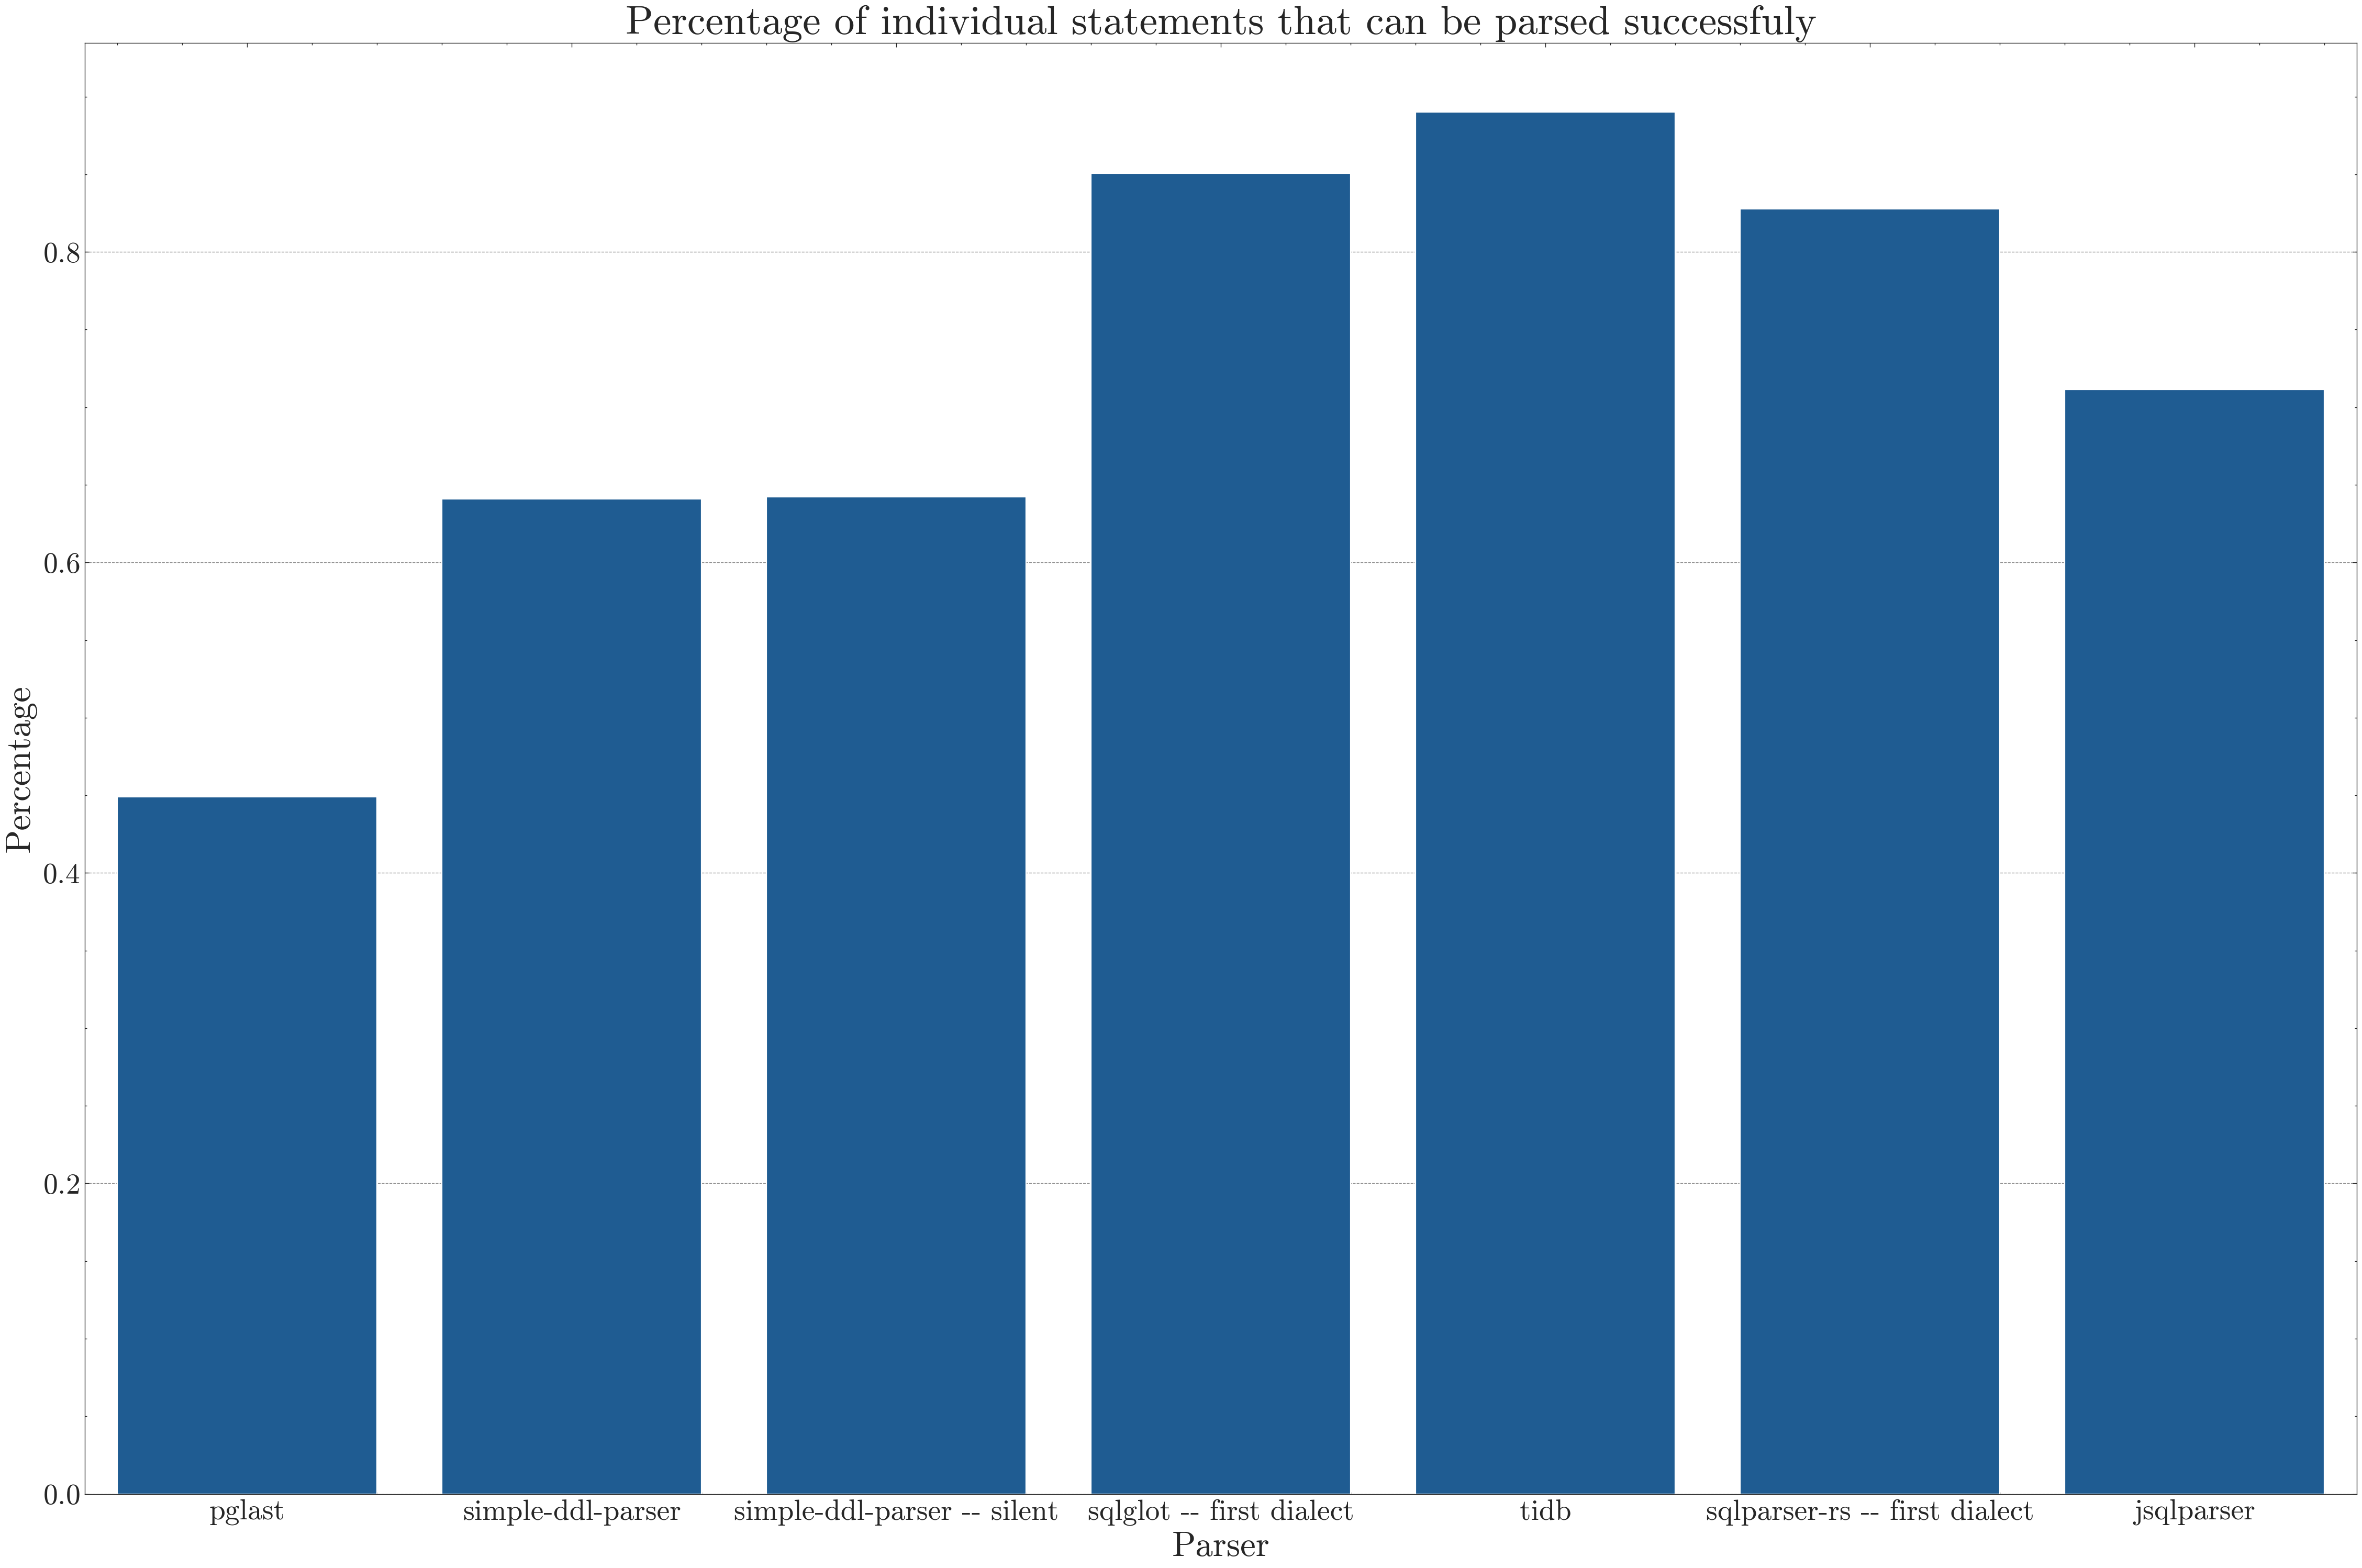

In [92]:
import scienceplots
plt.style.use(['science','no-latex','grid'])
x = plt.figure(figsize=(28, 18),dpi=200)

ax = sns.barplot(data=stmt_level_plot[stmt_level_plot.success == 1],x='Parser',y='percentage',hue='success')
ax.set_xlabel("Parser",fontsize=24)
ax.set_ylabel("Percentage",fontsize=24)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)

ax.get_legend().remove()

ax.set_title('Percentage of individual statements that can be parsed successfuly',fontsize=28)

## Quality analysis

In [17]:
keys = ['parser', 
        'file_count_match',
        'num_statements_match',
        'num_tables_match', 'list_tables_match',
        'num_cols_match', 'list_cols_match',
        'num_sch_match', 'list_sch_match',
        'num_db_match', 'list_db_match',
        'list_vw_match',
        'num_ctr_match',
        'num_ctr_notnull_match', 'num_ctr_unique_match',
        'num_ctr_primary_match', 'num_ctr_foreign_match'

]

def compare_with_pglast(ddf, parser, parsed_col,
                        pglast_num_st_col, num_st_col, 
                        pglast_nt_col, nt_col, pglast_tl_col, tl_col, 
                        pglast_nc_col, nc_col, pglast_cl_col, cl_col,
                        pglast_ns_col, ns_col, pglast_sl_col, sl_col,
                        pglast_ds_col, ds_col, pglast_dl_col, dl_col,
                        pglast_vl_col, vl_col,
                        pglast_num_ctr_col, pglast_num_ctr_nn_col, pglast_num_ctr_uq_col,
                        pglast_num_ctr_p_col, pglast_num_ctr_f_col,
                        num_ctr_col, num_ctr_nn_col, num_ctr_uq_col, num_ctr_p_col, num_ctr_f_col
                        ):
    out = {}
    out['parser'] = parser
    
    sub_ddf = ddf[ddf[parsed_col] == 1]
    out['file_count_match'] = sub_ddf['file_id'].count().compute()
    
    out['num_statements_match'] = sub_ddf[sub_ddf[pglast_num_st_col] == sub_ddf[num_st_col]]['file_id'].count().compute()

    out['num_tables_match'] = sub_ddf[sub_ddf[pglast_nt_col] == sub_ddf[nt_col]]['file_id'].count().compute()
    out['list_tables_match'] = sub_ddf[sub_ddf[pglast_tl_col] == sub_ddf[tl_col]]['file_id'].count().compute()
    
    out['num_cols_match'] = sub_ddf[sub_ddf[pglast_nc_col] == sub_ddf[nc_col]]['file_id'].count().compute()
    out['list_cols_match'] = sub_ddf[sub_ddf[pglast_cl_col] == sub_ddf[cl_col]]['file_id'].count().compute()

    out['num_sch_match'] = sub_ddf[sub_ddf[pglast_ns_col] == sub_ddf[ns_col]]['file_id'].count().compute()
    out['list_sch_match'] = sub_ddf[sub_ddf[pglast_sl_col] == sub_ddf[sl_col]]['file_id'].count().compute()

    out['num_db_match'] = sub_ddf[sub_ddf[pglast_ds_col] == sub_ddf[ds_col]]['file_id'].count().compute()
    out['list_db_match'] = sub_ddf[sub_ddf[pglast_dl_col] == sub_ddf[dl_col]]['file_id'].count().compute()

    out['list_vw_match'] = sub_ddf[sub_ddf[pglast_vl_col] == sub_ddf[vl_col]]['file_id'].count().compute()

    out['num_ctr_match'] = sub_ddf[sub_ddf[pglast_num_ctr_col] == sub_ddf[num_ctr_col]]['file_id'].count().compute()
    out['num_ctr_notnull_match'] = sub_ddf[sub_ddf[pglast_num_ctr_nn_col] == sub_ddf[num_ctr_nn_col]]['file_id'].count().compute()
    out['num_ctr_unique_match'] = sub_ddf[sub_ddf[pglast_num_ctr_uq_col] == sub_ddf[num_ctr_uq_col]]['file_id'].count().compute()
    out['num_ctr_primary_match'] = sub_ddf[sub_ddf[pglast_num_ctr_p_col] == sub_ddf[num_ctr_p_col]]['file_id'].count().compute()
    out['num_ctr_foreign_match'] = sub_ddf[sub_ddf[pglast_num_ctr_f_col] == sub_ddf[num_ctr_f_col]]['file_id'].count().compute()

    return out


results = {}
out_list = []
for k in keys:
    results[k] = []

# pglast baseline
parsed_by_pglast = joined_ddf[joined_ddf.pglast_parsed_file == 1]
pglast_num_parsed_files = parsed_by_pglast['file_id'].count().compute()
results['parser'].append('pglast')
for k in keys:
    if k != 'parser':
        results[k].append(pglast_num_parsed_files)                        

# filling NAs
values = {}
for col in parsed_by_pglast.columns:
    if 'list_str' in col:
        values[col] = '-'
parsed_by_pglast = parsed_by_pglast.fillna(value=values)  

parsed_by_pglast['pglast_table_list_str_minus_view'] = parsed_by_pglast.apply(
    lambda row:
    "|".join(sorted(list(set(row['pglast_table_list_str'].split('|')) - set(row['pglast_view_list_str'].split('|'))))) ,
    axis=1,
    meta=('pglast_table_list_str_minus_view', 'string'))

parsed_by_pglast = parsed_by_pglast.fillna(value={'pglast_table_list_str_minus_view': '-'})  

# sdp
sdp_match = compare_with_pglast(parsed_by_pglast, 'simple-ddl-parser','sdp_parsed_file','pglast_num_statements', 'sdp_num_statements', 'pglast_num_tables_without_create_seq', 'sdp_num_distinct_tables', 'pglast_table_list_str_minus_view', 'sdp_table_list_str', 'pglast_num_distinct_columns', 'sdp_num_distinct_columns', 'pglast_column_list_str', 'sdp_column_list_str', 'pglast_num_distinct_schemas', 'sdp_num_distinct_schemas', 'pglast_schema_list_str', 'sdp_schema_list_str', 'pglast_num_distinct_dbs', 'sdp_num_distinct_dbs', 'pglast_db_list_str', 'sdp_db_list_str', 'pglast_view_list_str','sdp_view_list_str', 'pglast_num_constraints', 'pglast_num_ctr_notnull', 'pglast_num_ctr_unique', 'pglast_num_ctr_primary', 'pglast_num_ctr_foreign', 'sdp_num_constraints', 'sdp_num_ctr_notnull', 'sdp_num_ctr_unique', 'sdp_num_ctr_primary', 'sdp_num_ctr_foreign')
out_list.append(sdp_match)


sdp_ind_match = compare_with_pglast(parsed_by_pglast, 'simple-ddl-parser-noExc','sdp_parsed_file_indulgent', 'pglast_num_statements', 'sdp_num_statements','pglast_num_tables_without_create_seq', 'sdp_num_distinct_tables', 'pglast_table_list_str_minus_view', 'sdp_table_list_str', 'pglast_num_distinct_columns', 'sdp_num_distinct_columns', 'pglast_column_list_str', 'sdp_column_list_str', 'pglast_num_distinct_schemas', 'sdp_num_distinct_schemas', 'pglast_schema_list_str', 'sdp_schema_list_str', 'pglast_num_distinct_dbs', 'sdp_num_distinct_dbs', 'pglast_db_list_str', 'sdp_db_list_str', 'pglast_view_list_str','sdp_view_list_str', 'pglast_num_constraints', 'pglast_num_ctr_notnull', 'pglast_num_ctr_unique', 'pglast_num_ctr_primary', 'pglast_num_ctr_foreign', 'sdp_num_constraints', 'sdp_num_ctr_notnull', 'sdp_num_ctr_unique', 'sdp_num_ctr_primary', 'sdp_num_ctr_foreign')
out_list.append(sdp_ind_match)

# sqlglot
sqlglot_match = compare_with_pglast(parsed_by_pglast, 'sqlglot-POSTGRES','sqlglot_parsed_postgres', 'pglast_num_statements', 'sqlglot_postgres_num_statements','pglast_num_tables_without_create_seq', 'sqlglot_postgres_num_distinct_tables', 'pglast_table_list_str', 'sqlglot_postgres_table_list_str','pglast_num_distinct_columns', 'sqlglot_postgres_num_distinct_columns', 'pglast_column_list_str', 'sqlglot_postgres_column_list_str', 'pglast_num_distinct_schemas', 'sqlglot_postgres_num_distinct_schemas', 'pglast_schema_list_str', 'sqlglot_postgres_schema_list_str', 'pglast_num_distinct_dbs', 'sqlglot_postgres_num_distinct_dbs', 'pglast_db_list_str', 'sqlglot_postgres_db_list_str', 'pglast_view_list_str','sqlglot_postgres_view_list_str', 'pglast_num_constraints', 'pglast_num_ctr_notnull', 'pglast_num_ctr_unique', 'pglast_num_ctr_primary', 'pglast_num_ctr_foreign', 'sqlglot_postgres_num_constraints', 'sqlglot_postgres_num_ctr_notnull', 'sqlglot_postgres_num_ctr_unique', 'sqlglot_postgres_num_ctr_primary', 'sqlglot_postgres_num_ctr_foreign')
out_list.append(sqlglot_match)

sqlglot_all_match = compare_with_pglast(parsed_by_pglast, 'sqlglot-first-dialect','sqlglot_parsed', 'pglast_num_statements', 'sqlglot_num_statements','pglast_num_tables_without_create_seq', 'sqlglot_num_distinct_tables', 'pglast_table_list_str', 'sqlglot_table_list_str','pglast_num_distinct_columns', 'sqlglot_num_distinct_columns', 'pglast_column_list_str', 'sqlglot_column_list_str', 'pglast_num_distinct_schemas', 'sqlglot_num_distinct_schemas', 'pglast_schema_list_str', 'sqlglot_schema_list_str', 'pglast_num_distinct_dbs', 'sqlglot_num_distinct_dbs', 'pglast_db_list_str', 'sqlglot_db_list_str', 'pglast_view_list_str','sqlglot_view_list_str', 'pglast_num_constraints', 'pglast_num_ctr_notnull', 'pglast_num_ctr_unique', 'pglast_num_ctr_primary', 'pglast_num_ctr_foreign', 'sqlglot_num_constraints', 'sqlglot_num_ctr_notnull', 'sqlglot_num_ctr_unique', 'sqlglot_num_ctr_primary', 'sqlglot_num_ctr_foreign')
out_list.append(sqlglot_all_match)

# tidb
tidb_match = compare_with_pglast(parsed_by_pglast, 'tidb','tidb_parsed_file', 'pglast_num_statements', 'tidb_num_statements','pglast_num_distinct_tables', 'tidb_num_distinct_tables', 'pglast_table_list_str', 'tidb_table_list_str','pglast_num_distinct_columns', 'tidb_num_distinct_columns', 'pglast_column_list_str', 'tidb_column_list_str', 'pglast_num_distinct_schemas', 'tidb_num_distinct_schemas', 'pglast_schema_list_str', 'tidb_schema_list_str', 'pglast_num_distinct_dbs', 'tidb_num_distinct_dbs', 'pglast_db_list_str', 'tidb_db_list_str', 'pglast_view_list_str','tidb_view_list_str', 'pglast_num_constraints', 'pglast_num_ctr_notnull', 'pglast_num_ctr_unique', 'pglast_num_ctr_primary', 'pglast_num_ctr_foreign', 'tidb_num_constraints', 'tidb_num_ctr_notnull', 'tidb_num_ctr_unique', 'tidb_num_ctr_primary', 'tidb_num_ctr_foreign')
out_list.append(tidb_match)

# rust

rust_match = compare_with_pglast(parsed_by_pglast, 'rust-POSTGRES','rustparser_parsed_postgres', 'pglast_num_statements', 'rustparser_postgres_num_statements','pglast_num_tables_without_create_seq', 'rustparser_postgres_num_distinct_tables', 'pglast_table_list_str', 'rustparser_postgres_table_list_str','pglast_num_distinct_columns', 'rustparser_postgres_num_distinct_columns', 'pglast_column_list_str', 'rustparser_postgres_column_list_str', 'pglast_num_distinct_schemas', 'rustparser_postgres_num_distinct_schemas', 'pglast_schema_list_str', 'rustparser_postgres_schema_list_str', 'pglast_num_distinct_dbs', 'rustparser_postgres_num_distinct_dbs', 'pglast_db_list_str', 'rustparser_postgres_db_list_str', 'pglast_view_list_str','rustparser_postgres_view_list_str', 'pglast_num_constraints', 'pglast_num_ctr_notnull', 'pglast_num_ctr_unique', 'pglast_num_ctr_primary', 'pglast_num_ctr_foreign', 'rustparser_postgres_num_constraints', 'rustparser_postgres_num_ctr_notnull', 'rustparser_postgres_num_ctr_unique', 'rustparser_postgres_num_ctr_primary', 'rustparser_postgres_num_ctr_foreign')
out_list.append(rust_match)

rust_all_match = compare_with_pglast(parsed_by_pglast, 'rust-first-dialect','rustparser_parsed', 'pglast_num_statements', 'rustparser_num_statements','pglast_num_tables_without_create_seq', 'rustparser_num_distinct_tables', 'pglast_table_list_str', 'rustparser_table_list_str','pglast_num_distinct_columns', 'rustparser_num_distinct_columns', 'pglast_column_list_str', 'rustparser_column_list_str', 'pglast_num_distinct_schemas', 'rustparser_num_distinct_schemas', 'pglast_schema_list_str', 'rustparser_schema_list_str', 'pglast_num_distinct_dbs', 'rustparser_num_distinct_dbs', 'pglast_db_list_str', 'rustparser_db_list_str', 'pglast_view_list_str','rustparser_view_list_str', 'pglast_num_constraints', 'pglast_num_ctr_notnull', 'pglast_num_ctr_unique', 'pglast_num_ctr_primary', 'pglast_num_ctr_foreign', 'rustparser_num_constraints', 'rustparser_num_ctr_notnull', 'rustparser_num_ctr_unique', 'rustparser_num_ctr_primary', 'rustparser_num_ctr_foreign')
out_list.append(rust_all_match)

# jsql

jsql_match = compare_with_pglast(parsed_by_pglast, 'jsqlparser','jsql_parsed_file', 'pglast_num_statements', 'jsql_num_statements','pglast_num_distinct_tables', 'jsql_num_distinct_tables', 'pglast_table_list_str', 'jsql_table_list_str','pglast_num_distinct_columns', 'jsql_num_distinct_columns', 'pglast_column_list_str', 'jsql_column_list_str', 'pglast_num_distinct_schemas', 'jsql_num_distinct_schemas', 'pglast_schema_list_str', 'jsql_schema_list_str', 'pglast_num_distinct_dbs', 'jsql_num_distinct_dbs', 'pglast_db_list_str', 'jsql_db_list_str', 'pglast_view_list_str','jsql_view_list_str', 'pglast_num_constraints', 'pglast_num_ctr_notnull', 'pglast_num_ctr_unique', 'pglast_num_ctr_primary', 'pglast_num_ctr_foreign', 'jsql_num_constraints', 'jsql_num_ctr_notnull', 'jsql_num_ctr_unique', 'jsql_num_ctr_primary', 'jsql_num_ctr_foreign')
out_list.append(jsql_match)

for item in out_list:
    for k,v in item.items():
        results[k].append(v)

num_files_match = pd.DataFrame(
    results
)

[########################################] | 100% Completed | 1.13 sms
[########################################] | 100% Completed | 21.83 s
[########################################] | 100% Completed | 21.85 s
[########################################] | 100% Completed | 21.40 s
[########################################] | 100% Completed | 22.51 s
[########################################] | 100% Completed | 21.91 s
[########################################] | 100% Completed | 21.72 s
[########################################] | 100% Completed | 21.93 s
[########################################] | 100% Completed | 22.06 s
[########################################] | 100% Completed | 22.10 s
[########################################] | 100% Completed | 22.45 s
[########################################] | 100% Completed | 24.38 s
[########################################] | 100% Completed | 24.79 s
[########################################] | 100% Completed | 25.06 s
[##################

In [18]:
num_files_match['file_count_match_perc'] = num_files_match['file_count_match']/pglast_num_parsed_files
num_files_match['num_statements_match_perc'] = num_files_match['num_statements_match']/pglast_num_parsed_files

for k in keys:
    if k != 'parser' and k != 'file_count_match' and k != 'num_statements_match':
        num_files_match[k + "_perc"] = num_files_match[k]/num_files_match['file_count_match']

out_cols = []
for k in keys:
    out_cols.append(k)
    if k != 'parser':
        out_cols.append(k + "_perc")

display(num_files_match[out_cols])

,parser,file_count_match,file_count_match_perc,num_statements_match,num_statements_match_perc,num_tables_match,num_tables_match_perc,list_tables_match,list_tables_match_perc,num_cols_match,num_cols_match_perc,list_cols_match,list_cols_match_perc,num_sch_match,num_sch_match_perc,list_sch_match,list_sch_match_perc,num_db_match,num_db_match_perc,list_db_match,list_db_match_perc,list_vw_match,list_vw_match_perc,num_ctr_match,num_ctr_match_perc,num_ctr_notnull_match,num_ctr_notnull_match_perc,num_ctr_unique_match,num_ctr_unique_match_perc,num_ctr_primary_match,num_ctr_primary_match_perc,num_ctr_foreign_match,num_ctr_foreign_match_perc
0,pglast,63937,1.000000,63937,1.000000,63937,1.000000,63937,1.000000,63937,1.000000,63937,1.000000,63937,1.000000,63937,1.000000,63937,1.000000,63937,1.000000,63937,1.000000,63937,1.000000,63937,1.000000,63937,1.000000,63937,1.000000,63937,1.000000
1,simple-ddl-parser,25805,0.403600,0,0.000000,15466,0.599341,13806,0.535013,25550,0.990118,25413,0.984809,25348,0.982290,24144,0.935633,25782,0.999109,25780,0.999031,25805,1.000000,0,0.000000,16635,0.644643,24187,0.937299,17477,0.677272,9598,0.371943
2,simple-ddl-parser-noExc,54573,0.853543,0,0.000000,30746,0.563392,26891,0.492753,45879,0.840690,45662,0.836714,52277,0.957928,47387,0.868323,54342,0.995767,54337,0.995676,53065,0.972367,0,0.000000,31360,0.574643,47930,0.878273,30069,0.550987,16188,0.296630
3,sqlglot-POSTGRES,40006,0.625710,40006,0.625710,38961,0.973879,35995,0.899740,39943,0.998425,39939,0.998325,38426,0.960506,38426,0.960506,39993,0.999675,39993,0.999675,39988,0.999550,1070,0.026746,36532,0.913163,34763,0.868945,25282,0.631955,37411,0.935135
4,sqlglot-first-dialect,41696,0.652142,40682,0.636283,40157,0.963090,37158,0.891165,41146,0.986809,41104,0.985802,40056,0.960668,40060,0.960764,41682,0.999664,41682,0.999664,41673,0.999448,1666,0.039956,37591,0.901549,36075,0.865191,26388,0.632866,38622,0.926276
5,tidb,16641,0.260272,16596,0.259568,16444,0.988162,16443,0.988102,16589,0.996875,16589,0.996875,16601,0.997596,16601,0.997596,16485,0.990626,16485,0.990626,16641,1.000000,1174,0.070549,13266,0.797188,13266,0.797188,16641,1.000000,16641,1.000000
6,rust-POSTGRES,43338,0.677823,43331,0.677714,41052,0.947252,39306,0.906964,41665,0.961396,41661,0.961304,43247,0.997900,43247,0.997900,43312,0.999400,43312,0.999400,43318,0.999539,1221,0.028174,43151,0.995685,43335,0.999931,43333,0.999885,43333,0.999885
7,rust-first-dialect,43380,0.678480,43373,0.678371,41092,0.947257,39346,0.907008,41629,0.959636,41625,0.959544,43289,0.997902,43289,0.997902,43354,0.999401,43354,0.999401,43360,0.999539,1222,0.028170,43193,0.995689,43377,0.999931,43375,0.999885,43375,0.999885
8,jsqlparser,42003,0.656944,41141,0.643462,35623,0.848106,34553,0.822632,41233,0.981668,41228,0.981549,41625,0.991001,41625,0.991001,41994,0.999786,41994,0.999786,41958,0.998929,629,0.014975,41185,0.980525,41656,0.991739,40923,0.974288,40765,0.970526


## Pretty quality analysis

In [172]:
#num_files_match.to_pickle('all_match.pkl')
file_match = pd.read_pickle("./all_match.pkl")

Index(['parser', 'file_count_match', 'num_statements_match', 'num_tables_match', 'list_tables_match', 'num_cols_match', 'list_cols_match', 'num_sch_match', 'list_sch_match', 'num_db_match', 'list_db_match', 'list_vw_match', 'num_ctr_match', 'num_ctr_notnull_match', 'num_ctr_unique_match', 'num_ctr_primary_match', 'num_ctr_foreign_match', 'file_count_match_perc', 'num_statements_match_perc', 'num_tables_match_perc', 'list_tables_match_perc', 'num_cols_match_perc', 'list_cols_match_perc', 'num_sch_match_perc', 'list_sch_match_perc', 'num_db_match_perc', 'list_db_match_perc', 'list_vw_match_perc', 'num_ctr_match_perc', 'num_ctr_notnull_match_perc', 'num_ctr_unique_match_perc', 'num_ctr_primary_match_perc', 'num_ctr_foreign_match_perc'], dtype='object')

### Prep all & file count match

In [181]:
file_match = pd.read_pickle("./all_match.pkl")

file_match['Parser']=np.select(
    [
        file_match['parser'] == 'simple-ddl-parser-noExc',
        file_match['parser'] == 'rust-POSTGRES',
        file_match['parser'] == 'rust-first-dialect'
    ], 
    [
        'simple-ddl-parser -- silent', 
        'sqlparser-rs -- POSTGRES', 
        'sqlparser-rs -- first-dialect'
    ], 
    default=file_match['parser']
)

file_match['file_count_match [% of total files parsed by pglast]'] = file_match['file_count_match_perc'] * 100
file_match['num_statements_match [% of total matched files]'] = file_match['num_statements_match'] * 100 / file_match['file_count_match']

file_match['num_tables_match [%]'] = file_match['num_tables_match_perc']
file_match['num_tables_match [% of matched files]'] = file_match['num_tables_match'].astype(str) + ' [' + (file_match['num_tables_match_perc']*100).round(3).astype(str) + ']'
file_match['list_tables_match [%]'] = file_match['list_tables_match_perc']
file_match['list_tables_match [% of matched files]'] = file_match['list_tables_match'].astype(str) + ' [' + (file_match['list_tables_match_perc']*100).round(3).astype(str) + ']'
file_match['num_cols_match [%]'] = file_match['num_cols_match_perc']
file_match['num_cols_match [% of matched files]'] = file_match['num_cols_match'].astype(str) + ' [' + (file_match['num_cols_match_perc']*100).round(3).astype(str) + ']'
file_match['list_cols_match [%]'] = file_match['list_cols_match_perc']
file_match['list_cols_match [% of matched files]'] = file_match['list_cols_match'].astype(str) + ' [' + (file_match['list_cols_match_perc']*100).round(3).astype(str) + ']'

file_match['num_schema_match [%]'] = file_match['num_sch_match_perc']
file_match['num_schema_match [% of matched files]'] = file_match['num_sch_match'].astype(str) + ' [' + (file_match['num_sch_match_perc']*100).round(3).astype(str) + ']'
file_match['list_schema_match [%]'] = file_match['list_sch_match_perc']
file_match['list_schema_match [% of matched files]'] = file_match['list_sch_match'].astype(str) + ' [' + (file_match['list_sch_match_perc']*100).round(3).astype(str) + ']'
file_match['num_database_match [%]'] = file_match['num_db_match_perc']
file_match['num_database_match [% of matched files]'] = file_match['num_db_match'].astype(str) + ' [' + (file_match['num_db_match_perc']*100).round(3).astype(str) + ']'
file_match['list_database_match [%]'] = file_match['list_db_match_perc']
file_match['list_database_match [% of matched files]'] = file_match['list_db_match'].astype(str) + ' [' + (file_match['list_db_match_perc']*100).round(3).astype(str) + ']'
file_match['list_view_match [%]'] = file_match['list_vw_match_perc']
file_match['list_view_match [% of matched files]'] = file_match['list_vw_match'].astype(str) + ' [' + (file_match['list_vw_match_perc']*100).round(3).astype(str) + ']'

file_match['num_notnull_constraint_match [%]'] = file_match['num_ctr_notnull_match_perc']
file_match['num_notnull_constraint_match [% of matched files]'] = file_match['num_ctr_notnull_match'].astype(str) + ' [' + (file_match['num_ctr_notnull_match_perc']*100).round(3).astype(str) + ']'
file_match['num_unique_constraint_match [%]'] = file_match['num_ctr_unique_match_perc']
file_match['num_unique_constraint_match [% of matched files]'] = file_match['num_ctr_unique_match'].astype(str) + ' [' + (file_match['num_ctr_unique_match_perc']*100).round(3).astype(str) + ']'
file_match['num_primary_constraint_match [%]'] = file_match['num_ctr_primary_match_perc']
file_match['num_primary_constraint_match [% of matched files]'] = file_match['num_ctr_primary_match'].astype(str) + ' [' + (file_match['num_ctr_primary_match_perc']*100).round(3).astype(str) + ']'
file_match['num_foreign_constraint_match [%]'] = file_match['num_ctr_foreign_match_perc']
file_match['num_foreign_constraint_match [% of matched files]'] = file_match['num_ctr_foreign_match'].astype(str) + ' [' + (file_match['num_ctr_foreign_match_perc']*100).round(3).astype(str) + ']'


file_match_sub = file_match[['Parser','file_count_match','file_count_match [% of total files parsed by pglast]',
                             'num_statements_match','num_statements_match [% of total matched files]']]

table_col_match = file_match[['Parser','num_tables_match [%]', 'list_tables_match [%]', 'num_cols_match [%]', 'list_cols_match [%]']]
table_col_match_raw = file_match[['Parser','num_tables_match [% of matched files]','list_tables_match [% of matched files]','num_cols_match [% of matched files]','list_cols_match [% of matched files]']]

db_sch_vw_match = file_match[['Parser','num_schema_match [%]','list_schema_match [%]','num_database_match [%]','list_database_match [%]','list_view_match [%]']]
db_sch_vw_match_raw = file_match[['Parser','num_schema_match [% of matched files]','list_schema_match [% of matched files]','num_database_match [% of matched files]','list_database_match [% of matched files]','list_view_match [% of matched files]']]

ctr_match = file_match[['Parser','num_notnull_constraint_match [%]','num_unique_constraint_match [%]', 'num_primary_constraint_match [%]', 'num_foreign_constraint_match [%]']]
ctr_match_raw = file_match[['Parser','num_notnull_constraint_match [% of matched files]','num_unique_constraint_match [% of matched files]','num_primary_constraint_match [% of matched files]','num_foreign_constraint_match [% of matched files]']]


file_match_sub = file_match_sub[file_match_sub.Parser != 'pglast']
table_col_match = table_col_match[table_col_match.Parser != 'pglast']
table_col_match_raw = table_col_match_raw[table_col_match_raw.Parser != 'pglast']
db_sch_vw_match = db_sch_vw_match[db_sch_vw_match.Parser != 'pglast']
db_sch_vw_match_raw = db_sch_vw_match_raw[db_sch_vw_match_raw.Parser != 'pglast']
ctr_match = ctr_match[ctr_match.Parser != 'pglast']
ctr_match_raw = ctr_match_raw[ctr_match_raw.Parser != 'pglast']

display(ctr_match)

,Parser,num_notnull_constraint_match [%],num_unique_constraint_match [%],num_primary_constraint_match [%],num_foreign_constraint_match [%]
1,simple-ddl-parser,0.644643,0.937299,0.677272,0.371943
2,simple-ddl-parser -- silent,0.574643,0.878273,0.550987,0.296630
3,sqlglot-POSTGRES,0.913163,0.868945,0.631955,0.935135
4,sqlglot-first-dialect,0.901549,0.865191,0.632866,0.926276
5,tidb,0.797188,0.797188,1.000000,1.000000
6,sqlparser-rs -- POSTGRES,0.995685,0.999931,0.999885,0.999885
7,sqlparser-rs -- first-dialect,0.995689,0.999931,0.999885,0.999885
8,jsqlparser,0.980525,0.991739,0.974288,0.970526


In [107]:
print(file_match_sub.to_latex(
    index=False,
    float_format="{:.3f}".format
))

\begin{tabular}{lrrrr}
\toprule
                       Parser &  file\_count\_match &  file\_count\_match [\% of total files parsed by pglast] &  num\_statements\_match &  num\_statements\_match [\% of total matched files] \\
\midrule
simple-ddl-parser & 25805 & 40.360 & 0 & 0.000 \\
simple-ddl-parser -- silent & 54573 & 85.354 & 0 & 0.000 \\
sqlglot-POSTGRES & 40006 & 62.571 & 40006 & 100.000 \\
sqlglot-first-dialect & 41696 & 65.214 & 40682 & 97.568 \\
tidb & 16641 & 26.027 & 16596 & 99.730 \\
sqlparser-rs -- POSTGRES & 43338 & 67.782 & 43331 & 99.984 \\
sqlparser-rs -- first-dialect & 43380 & 67.848 & 43373 & 99.984 \\
jsqlparser & 42003 & 65.694 & 41141 & 97.948 \\
\bottomrule
\end{tabular}



C:\Users\geacu\AppData\Local\Temp\ipykernel_11152\3443548354.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(file_match_sub.to_latex(


### SQLGlot check

In [16]:
parsed_by_pglast = joined_ddf[joined_ddf.pglast_parsed_file == 1]
values = {}
for col in parsed_by_pglast.columns:
    if 'list_str' in col:
        values[col] = '-'
parsed_by_pglast = parsed_by_pglast.fillna(value=values)  

parsed_by_pglast['pglast_table_list_str_minus_view'] = parsed_by_pglast.apply(
    lambda row:
    "|".join(sorted(list(set(row['pglast_table_list_str'].split('|')) - set(row['pglast_view_list_str'].split('|'))))) ,
    axis=1,
    meta=('pglast_table_list_str_minus_view', 'string'))

parsed_by_pglast = parsed_by_pglast.fillna(value={'pglast_table_list_str_minus_view': '-'})  


In [17]:
pglast_sqlglot = parsed_by_pglast[parsed_by_pglast.sqlglot_parsed == 1]

In [20]:
pglast_sqlglot[
    (pglast_sqlglot.pglast_num_tables_without_create_seq == pglast_sqlglot.sqlglot_num_distinct_tables)
]['file_id'].count().compute(scheduler='processes')

# total: 41696
# = 40 157
# < 388
# > 1151

[                                        ] | 0% Completed | 18.94 ms

[########################################] | 100% Completed | 13.87 s


40157

In [24]:
pglast_sqlglot[
    (pglast_sqlglot.pglast_num_tables_without_create_seq > pglast_sqlglot.sqlglot_num_distinct_tables)
]['file_id'].count().compute(scheduler='processes')

[                                        ] | 0% Completed | 528.70 us

[########################################] | 100% Completed | 15.95 s


1151

In [35]:
pglast_sqlglot[
    (pglast_sqlglot.pglast_num_tables_without_create_seq == pglast_sqlglot.pglast_num_distinct_tables) &
    (pglast_sqlglot.pglast_table_list_str == pglast_sqlglot.sqlglot_table_list_str)
]['file_id'].count().compute(scheduler='processes')
# 38 523
# 37 157

[                                        ] | 0% Completed | 439.10 us

[########################################] | 100% Completed | 13.99 s


37157

In [30]:
pglast_sqlglot[
    (pglast_sqlglot.pglast_table_list_str == pglast_sqlglot.sqlglot_table_list_str) &
    (pglast_sqlglot.pglast_num_alter_stmt == 0) &
    (pglast_sqlglot.pglast_num_alter_like_stmt == 0)
]['file_id'].count().compute(scheduler='processes')

[                                        ] | 0% Completed | 889.50 us

[########################################] | 100% Completed | 13.84 s


24880

In [25]:
pglast_sqlglot[
    (pglast_sqlglot.pglast_table_list_str != pglast_sqlglot.sqlglot_table_list_str)
][['file_id','pglast_table_list_str','sqlglot_table_list_str','sqlglot_num_distinct_tables',
  'pglast_num_tables_without_create_seq']].head()

[########################################] | 100% Completed | 465.70 ms


,file_id,pglast_table_list_str,sqlglot_table_list_str,sqlglot_num_distinct_tables,pglast_num_tables_without_create_seq
90,232790,CAR|CAR_DETAILS|CONTACT|DATA_OBJECT|DEALERSHIP|DECLARATION|DETAILS|HIBERNATE_SEQUENCE|ROLES|USERS|USER_ROLES,CAR|CAR_DETAILS|CONTACT|DATA_OBJECT|DEALERSHIP|DECLARATION|DETAILS|ROLES|USERS|USER_ROLES,10,10.0
151,270311,KARTLEGGING|KULEPUNKT|KULEPUNKT_SEQ,KARTLEGGING|KULEPUNKT,2,2.0
162,090863,BATCHES|BUSINESS_UNIT|CLIENT|CLIENT_SEQ|COUNTRY|DEPARTMENTS_LKP|DESIGNATION|EMPLOYEE|EMPLOYEE_ADDRESS|EMPLOYEE_ADDRESS_SEQ|EMPLOYEE_BATCHES|EMPLOYEE_HISTORY|EMPLOYEE_SKILL|EMPLOYEE_VEHICLE|LOOKUP|ORGANIZATION|PROJECT|PROJECT_LOCATION|PROJECT_LOCATION_SEQ|SKILL|STATE|WORK_LOCATION|WORK_LOCATION_SEQ,BATCHES|BUSINESS_UNIT|CLIENT|COUNTRY|DEPARTMENTS_LKP|DESIGNATION|EMPLOYEE|EMPLOYEE_ADDRESS|EMPLOYEE_BATCHES|EMPLOYEE_HISTORY|EMPLOYEE_SKILL|EMPLOYEE_VEHICLE|LOOKUP|ORGANIZATION|PROJECT|PROJECT_LOCATION|SKILL|STATE|WORK_LOCATION,19,19.0
238,057235,BIO_ASSAY|BIO_ASSAY_SAMPLE|BIO_SAMPLE,BIO_ASSAY_SAMPLE,1,3.0
268,474726,BGROUP|BUSER|USERGROUP,USERGROUP,1,3.0


In [33]:
pglast_sqlglot[
    (pglast_sqlglot.pglast_table_list_str != pglast_sqlglot.sqlglot_table_list_str) &
    (pglast_sqlglot.pglast_num_alter_stmt == 0) &
    (pglast_sqlglot.pglast_num_alter_like_stmt == 0)
][['file_id','pglast_table_list_str','sqlglot_table_list_str','sqlglot_num_distinct_tables',
  'pglast_num_tables_without_create_seq']].head()

[                                        ] | 0% Completed | 581.60 us

[########################################] | 100% Completed | 328.79 ms


,file_id,pglast_table_list_str,sqlglot_table_list_str,sqlglot_num_distinct_tables,pglast_num_tables_without_create_seq
151,270311,KARTLEGGING|KULEPUNKT|KULEPUNKT_SEQ,KARTLEGGING|KULEPUNKT,2,2.0
580,010929,BATCH_JOB_EXECUTION|BATCH_JOB_EXECUTION_CONTEXT|BATCH_JOB_EXECUTION_PARAMS|BATCH_JOB_EXECUTION_SEQ|BATCH_JOB_INSTANCE|BATCH_JOB_SEQ|BATCH_STEP_EXECUTION|BATCH_STEP_EXECUTION_CONTEXT|BATCH_STEP_EXECUTION_SEQ,BATCH_JOB_EXECUTION|BATCH_JOB_EXECUTION_CONTEXT|BATCH_JOB_EXECUTION_PARAMS|BATCH_JOB_INSTANCE|BATCH_STEP_EXECUTION|BATCH_STEP_EXECUTION_CONTEXT,6,6.0
681,677462,CS_ATTR|CS_CLASS|CS_CLASS_ATTR|CS_HISTORY|CS_POLICY|CS_TYPE|CS_UG|CS_USR|TEST1|TEST1_SEQ|TEST2|TEST2_SEQ|TEST3|TEST3_SEQ|TEST4|TEST4_SEQ|TEST5|TEST5_SEQ|TEST6|TEST6_SEQ,CS_ATTR|CS_CLASS|CS_CLASS_ATTR|CS_HISTORY|CS_POLICY|CS_TYPE|CS_UG|CS_USR|TEST1|TEST2|TEST3|TEST4|TEST5|TEST6,14,14.0
727,497188,INFORMATION|LOOKUP|SCHEDULE|USERS,DAYTABLE|INFORMATION|LOOKUP|SCHEDULE|USERS,5,4.0
761,034993,SEC_BOND|SEC_BONDFUTUREOPTION|SEC_BUSINESSDAYCONVENTION|SEC_CAPFLOOR|SEC_CAPFLOORCMSSPREAD|SEC_CASH|SEC_CASHFLOW|SEC_CASHRATE|SEC_CDS|SEC_CDSID_COMPONENT|SEC_CDSID_FAMILY|SEC_CDSID_TENOR|SEC_COMMODITYFUTUREOPTION|SEC_COMMODITY_FORWARD|SEC_CONTRACT_CATEGORY|SEC_COUPONTYPE|SEC_CREDIT_DEFAULT_SWAP|SEC_CREDIT_DEFAULT_SWAP_INDEX|SEC_CREDIT_DEFAULT_SWAP_INDEX_DEFINITION|SEC_CREDIT_DEFAULT_SWAP_OPTION|SEC_CURRENCY|SEC_DAYCOUNT|SEC_DEBT_SENIORITY|SEC_EQUITY|SEC_EQUITYBARRIEROPTION|SEC_EQUITYINDEXOPTION|SEC_EQUITYOPTION|SEC_EQUITY_INDEX_DIVIDEND_FUTUREOPTION|SEC_EQUITY_INDEX_FUTUREOPTION|SEC_EQUITY_VARIANCE_SWAP|SEC_EXCHANGE|SEC_FRA|SEC_FREQUENCY|SEC_FUTURE|SEC_FUTUREBUNDLE|SEC_FUTUREBUNDLEIDENTIFIER|SEC_FXBARRIEROPTION|SEC_FXDIGITALOPTION|SEC_FXFORWARD|SEC_FXFUTUREOPTION|SEC_FXOPTION|SEC_GICS|SEC_GUARANTEETYPE|SEC_HIBERNATE_SEQUENCE|SEC_IDKEY|SEC_IDKEY_SEQ|SEC_IRFUTUREOPTION|SEC_ISSUERTYPE|SEC_MARKET|SEC_NDFFXDIGITALOPTION|SEC_NONDELIVERABLEFXFORWARD|SEC_NONDELIVERABLEFXOPTION|SEC_RAW|SEC_RESTRUCTURING_CLAUSE|SEC_SCHEMA_VERSION|SEC_SECURITY|SEC_SECURITY2IDKEY|SEC_SECURITY_ATTRIBUTE|SEC_SECURITY_ATTR_SEQ|SEC_SECURITY_SEQ|SEC_STUBTYPE|SEC_SWAP|SEC_SWAPTION|SEC_TENOR|SEC_UNIT|SEC_YIELDCONVENTION,SEC_BOND|SEC_BONDFUTUREOPTION|SEC_BUSINESSDAYCONVENTION|SEC_CAPFLOOR|SEC_CAPFLOORCMSSPREAD|SEC_CASH|SEC_CASHFLOW|SEC_CASHRATE|SEC_CDS|SEC_CDSID_COMPONENT|SEC_CDSID_FAMILY|SEC_CDSID_TENOR|SEC_COMMODITYFUTUREOPTION|SEC_COMMODITY_FORWARD|SEC_CONTRACT_CATEGORY|SEC_COUPONTYPE|SEC_CREDIT_DEFAULT_SWAP|SEC_CREDIT_DEFAULT_SWAP_INDEX|SEC_CREDIT_DEFAULT_SWAP_INDEX_DEFINITION|SEC_CREDIT_DEFAULT_SWAP_OPTION|SEC_CURRENCY|SEC_DAYCOUNT|SEC_DEBT_SENIORITY|SEC_EQUITY|SEC_EQUITYBARRIEROPTION|SEC_EQUITYINDEXOPTION|SEC_EQUITYOPTION|SEC_EQUITY_INDEX_DIVIDEND_FUTUREOPTION|SEC_EQUITY_INDEX_FUTUREOPTION|SEC_EQUITY_VARIANCE_SWAP|SEC_EXCHANGE|SEC_FRA|SEC_FREQUENCY|SEC_FUTURE|SEC_FUTUREBUNDLE|SEC_FUTUREBUNDLEIDENTIFIER|SEC_FXBARRIEROPTION|SEC_FXDIGITALOPTION|SEC_FXFORWARD|SEC_FXFUTUREOPTION|SEC_FXOPTION|SEC_GICS|SEC_GUARANTEETYPE|SEC_IDKEY|SEC_IRFUTUREOPTION|SEC_ISSUERTYPE|SEC_MARKET|SEC_NDFFXDIGITALOPTION|SEC_NONDELIVERABLEFXFORWARD|SEC_NONDELIVERABLEFXOPTION|SEC_RAW|SEC_RESTRUCTURING_CLAUSE|SEC_SCHEMA_VERSION|SEC_SECURITY|SEC_SECURITY2IDKEY|SEC_SECURITY_ATTRIBUTE|SEC_STUBTYPE|SEC_SWAP|SEC_SWAPTION|SEC_TENOR|SEC_UNIT|SEC_YIELDCONVENTION,62,62.0


checking ctrs now

In [39]:
pglast_sqlglot[
    (pglast_sqlglot.sqlglot_num_constraints > (pglast_sqlglot.sqlglot_num_ctr_notnull + pglast_sqlglot.sqlglot_num_ctr_primary + pglast_sqlglot.sqlglot_num_ctr_unique + pglast_sqlglot.sqlglot_num_ctr_foreign))
]['file_id'].count().compute(scheduler='processes')

# total: 41696
# 6003 equal
# 27 261 <
# 8432 <

[                                        ] | 0% Completed | 1.24 ms

[########################################] | 100% Completed | 14.46 s


8432

In [42]:
pglast_sqlglot[
    (pglast_sqlglot.pglast_num_ctr_primary > pglast_sqlglot.sqlglot_num_ctr_primary)
]['file_id'].count().compute(scheduler='processes')

# not equal: 15 308
# pglast > 15 283

[                                        ] | 0% Completed | 693.40 us

[########################################] | 100% Completed | 14.93 s


15283

In [40]:
pglast_sqlglot[
    (pglast_sqlglot.pglast_num_ctr_primary != pglast_sqlglot.sqlglot_num_ctr_primary)
][['file_id','pglast_num_ctr_primary','sqlglot_num_ctr_primary']].head()

[########################################] | 100% Completed | 550.49 ms


,file_id,pglast_num_ctr_primary,sqlglot_num_ctr_primary
3,202803,6.0,1
15,541484,8.0,0
17,346945,14.0,8
37,213349,4.0,0
69,058989,3.0,1


### Table cols match

In [185]:
display(table_col_match_raw)

,Parser,num_tables_match [% of matched files],list_tables_match [% of matched files],num_cols_match [% of matched files],list_cols_match [% of matched files]
1,simple-ddl-parser,15466 [59.934],13806 [53.501],25550 [99.012],25413 [98.481]
2,simple-ddl-parser -- silent,30746 [56.339],26891 [49.275],45879 [84.069],45662 [83.671]
3,sqlglot-POSTGRES,38961 [97.388],35995 [89.974],39943 [99.843],39939 [99.833]
4,sqlglot-first-dialect,40157 [96.309],37158 [89.116],41146 [98.681],41104 [98.58]
5,tidb,16444 [98.816],16443 [98.81],16589 [99.688],16589 [99.688]
6,sqlparser-rs -- POSTGRES,41052 [94.725],39306 [90.696],41665 [96.14],41661 [96.13]
7,sqlparser-rs -- first-dialect,41092 [94.726],39346 [90.701],41629 [95.964],41625 [95.954]
8,jsqlparser,35623 [84.811],34553 [82.263],41233 [98.167],41228 [98.155]


In [184]:
print(table_col_match_raw.to_latex(
    index=False,
    float_format="{:.3f}".format
))

\begin{tabular}{lllll}
\toprule
                       Parser & num\_tables\_match [\% of matched files] & list\_tables\_match [\% of matched files] & num\_cols\_match [\% of matched files] & list\_cols\_match [\% of matched files] \\
\midrule
simple-ddl-parser & 15466 [59.934] & 13806 [53.501] & 25550 [99.012] & 25413 [98.481] \\
simple-ddl-parser -- silent & 30746 [56.339] & 26891 [49.275] & 45879 [84.069] & 45662 [83.671] \\
sqlglot-POSTGRES & 38961 [97.388] & 35995 [89.974] & 39943 [99.843] & 39939 [99.833] \\
sqlglot-first-dialect & 40157 [96.309] & 37158 [89.116] & 41146 [98.681] & 41104 [98.58] \\
tidb & 16444 [98.816] & 16443 [98.81] & 16589 [99.688] & 16589 [99.688] \\
sqlparser-rs -- POSTGRES & 41052 [94.725] & 39306 [90.696] & 41665 [96.14] & 41661 [96.13] \\
sqlparser-rs -- first-dialect & 41092 [94.726] & 39346 [90.701] & 41629 [95.964] & 41625 [95.954] \\
jsqlparser & 35623 [84.811] & 34553 [82.263] & 41233 [98.167] & 41228 [98.155] \\
\bottomrule
\end{tabular}



C:\Users\geacu\AppData\Local\Temp\ipykernel_11152\1728688438.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table_col_match_raw.to_latex(


C:\Users\geacu\AppData\Local\Temp\ipykernel_11152\1740728281.py:13: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(20)
C:\Users\geacu\AppData\Local\Temp\ipykernel_11152\1740728281.py:21: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(20)


Text(0.5, 1.0, 'Percentage of files that match with pglast on selected metrics (1)')

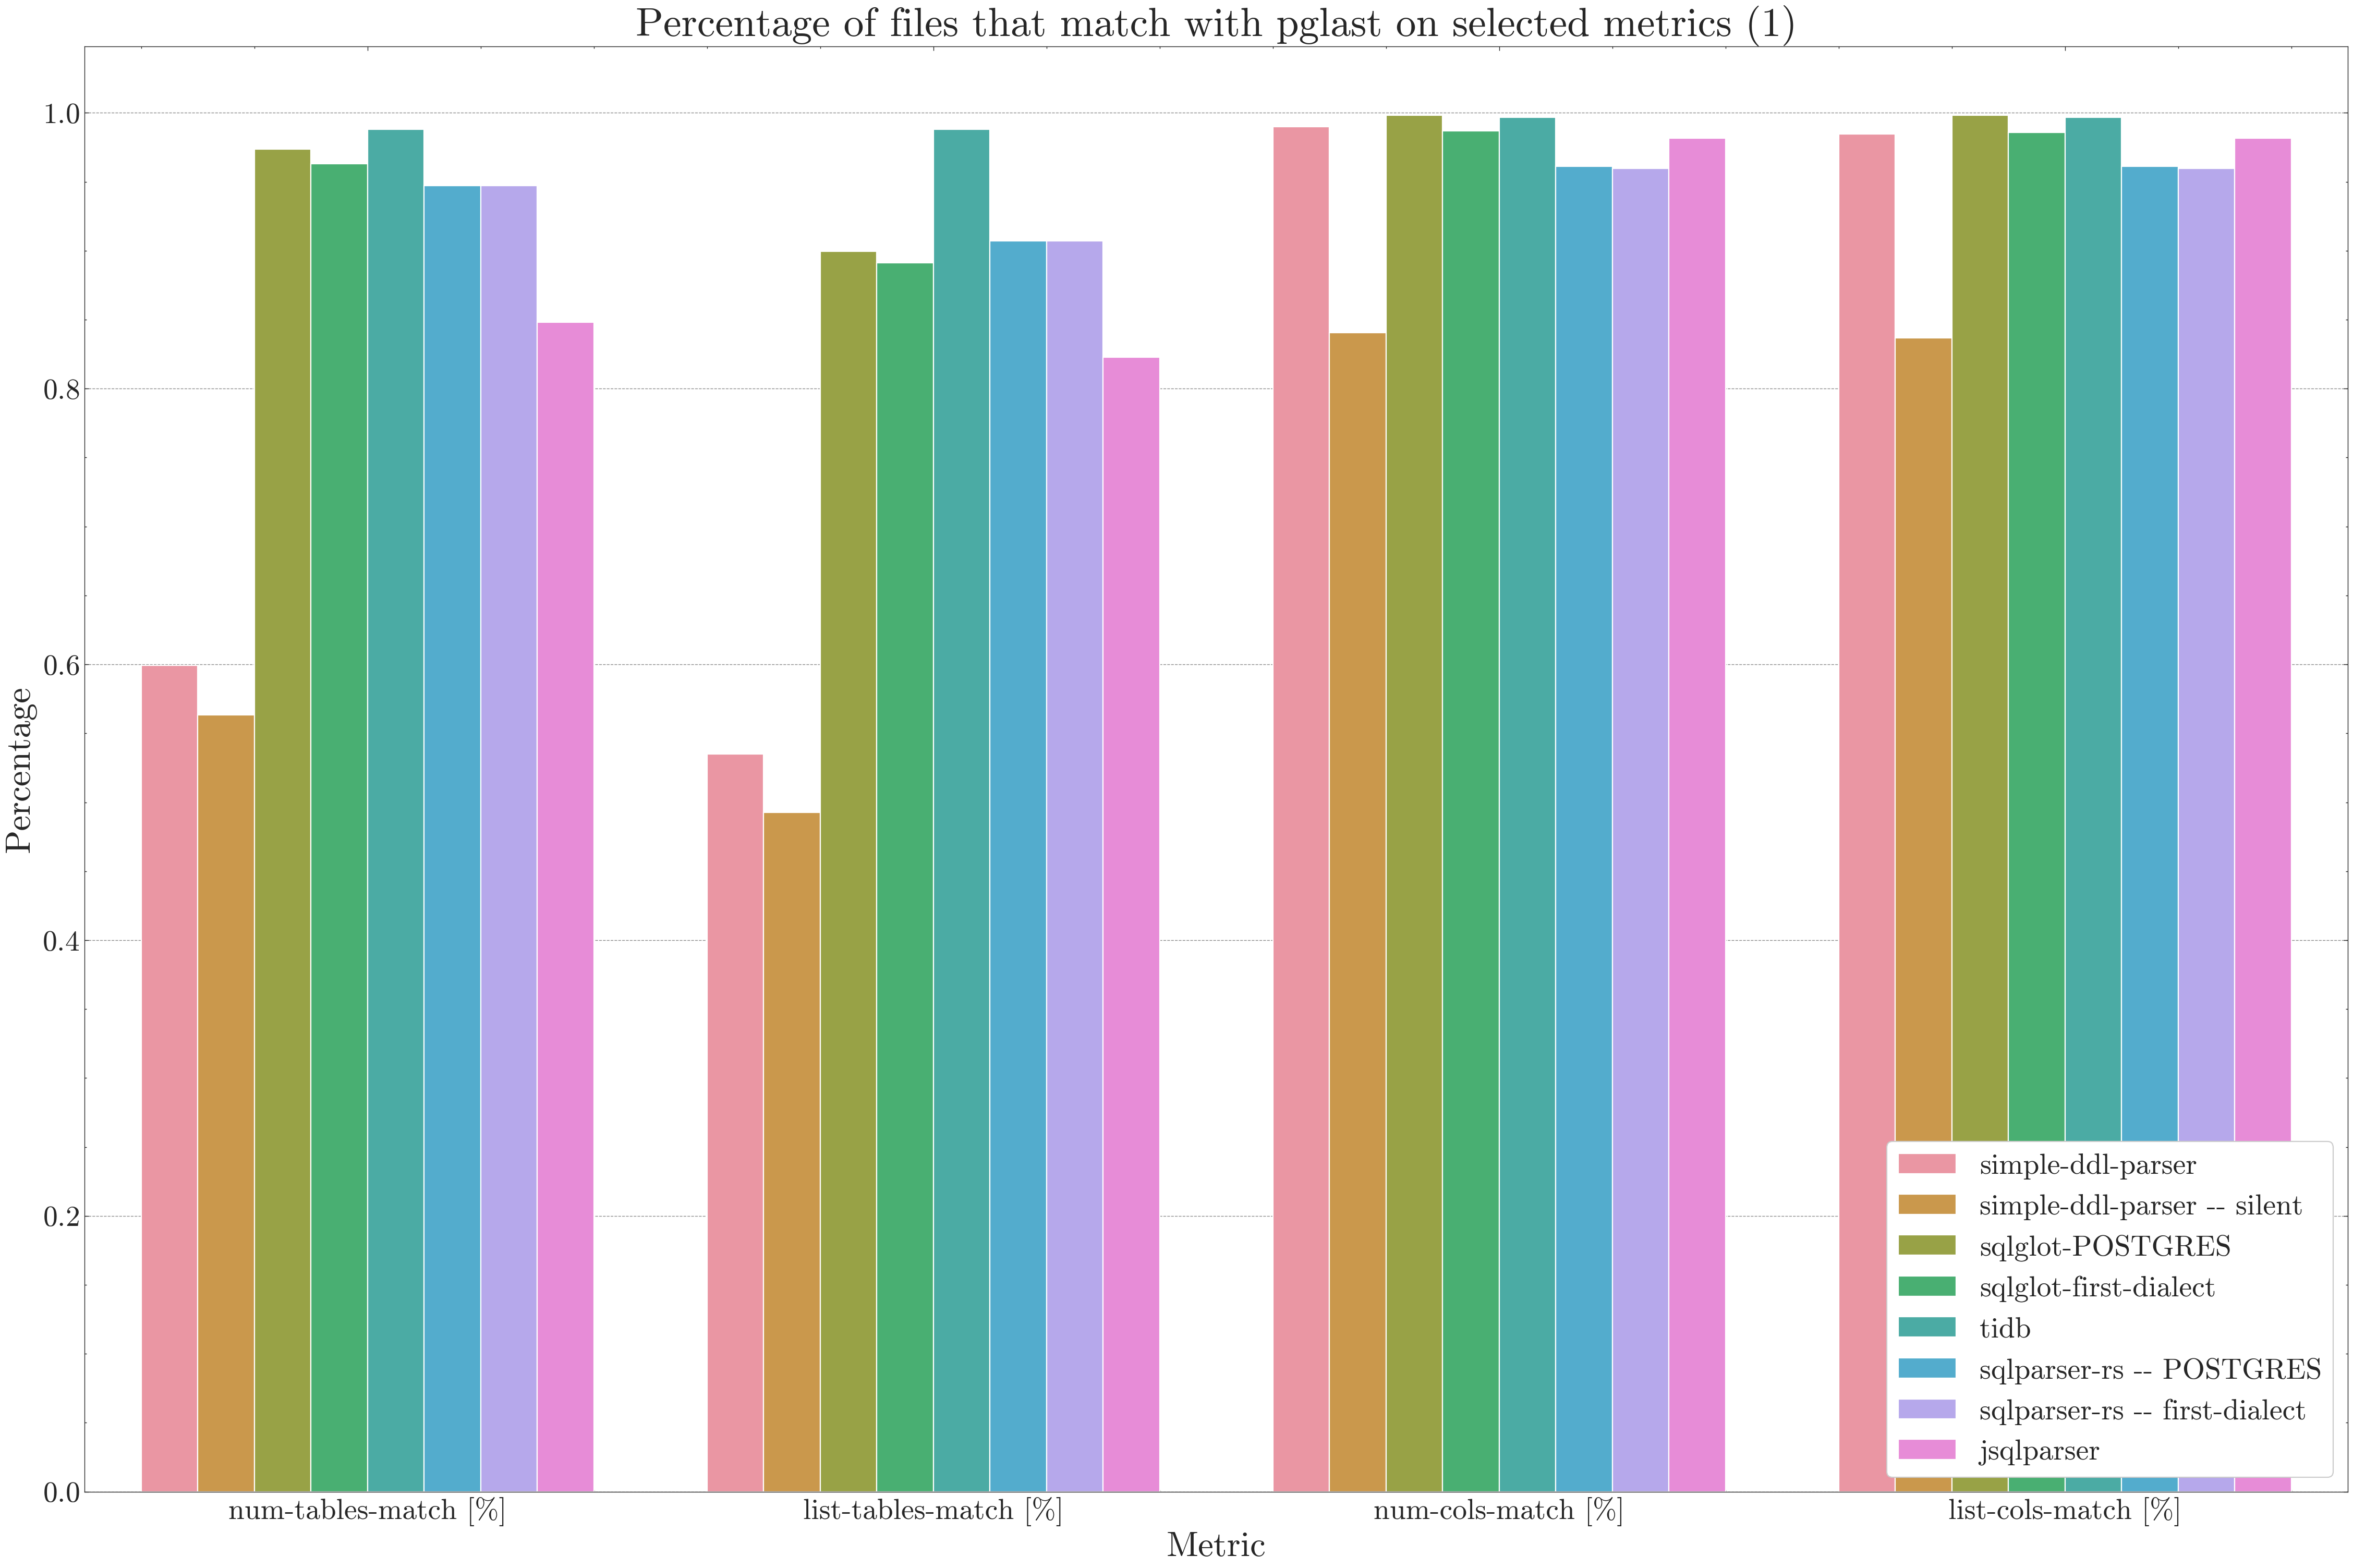

In [182]:
import scienceplots
plt.style.use(['science','no-latex','grid','high-contrast'])
x = plt.figure(figsize=(28, 18),dpi=200)
import matplotlib.colors as mcolors
ax = sns.barplot(data=table_col_match.melt(id_vars='Parser',
                                  value_name='perc',var_name='attribute'),
            x='attribute', y='perc',hue='Parser')

ax.set_ylabel("Percentage",fontsize=24)
ax.set_xlabel("Metric",fontsize=24)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
    
x_labels = ax.xaxis.get_ticklabels()
for item in x_labels:
    item.set_text(item.get_text().replace("_",'-'))

ax.xaxis.set_ticklabels(x_labels)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)

ax.legend(loc='lower right',fontsize=20)

ax.set_title('Percentage of files that match with pglast on selected metrics (1)',fontsize=28)


### schemas/dbs/vws match

In [187]:
display(db_sch_vw_match_raw)

,Parser,num_schema_match [% of matched files],list_schema_match [% of matched files],num_database_match [% of matched files],list_database_match [% of matched files],list_view_match [% of matched files]
1,simple-ddl-parser,25348 [98.229],24144 [93.563],25782 [99.911],25780 [99.903],25805 [100.0]
2,simple-ddl-parser -- silent,52277 [95.793],47387 [86.832],54342 [99.577],54337 [99.568],53065 [97.237]
3,sqlglot-POSTGRES,38426 [96.051],38426 [96.051],39993 [99.968],39993 [99.968],39988 [99.955]
4,sqlglot-first-dialect,40056 [96.067],40060 [96.076],41682 [99.966],41682 [99.966],41673 [99.945]
5,tidb,16601 [99.76],16601 [99.76],16485 [99.063],16485 [99.063],16641 [100.0]
6,sqlparser-rs -- POSTGRES,43247 [99.79],43247 [99.79],43312 [99.94],43312 [99.94],43318 [99.954]
7,sqlparser-rs -- first-dialect,43289 [99.79],43289 [99.79],43354 [99.94],43354 [99.94],43360 [99.954]
8,jsqlparser,41625 [99.1],41625 [99.1],41994 [99.979],41994 [99.979],41958 [99.893]


In [188]:
print(db_sch_vw_match_raw.to_latex(
    index=False,
    float_format="{:.3f}".format
))

\begin{tabular}{llllll}
\toprule
                       Parser & num\_schema\_match [\% of matched files] & list\_schema\_match [\% of matched files] & num\_database\_match [\% of matched files] & list\_database\_match [\% of matched files] & list\_view\_match [\% of matched files] \\
\midrule
simple-ddl-parser & 25348 [98.229] & 24144 [93.563] & 25782 [99.911] & 25780 [99.903] & 25805 [100.0] \\
simple-ddl-parser -- silent & 52277 [95.793] & 47387 [86.832] & 54342 [99.577] & 54337 [99.568] & 53065 [97.237] \\
sqlglot-POSTGRES & 38426 [96.051] & 38426 [96.051] & 39993 [99.968] & 39993 [99.968] & 39988 [99.955] \\
sqlglot-first-dialect & 40056 [96.067] & 40060 [96.076] & 41682 [99.966] & 41682 [99.966] & 41673 [99.945] \\
tidb & 16601 [99.76] & 16601 [99.76] & 16485 [99.063] & 16485 [99.063] & 16641 [100.0] \\
sqlparser-rs -- POSTGRES & 43247 [99.79] & 43247 [99.79] & 43312 [99.94] & 43312 [99.94] & 43318 [99.954] \\
sqlparser-rs -- first-dialect & 43289 [99.79] & 43289 [99.79] & 43354 

C:\Users\geacu\AppData\Local\Temp\ipykernel_11152\500459425.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(db_sch_vw_match_raw.to_latex(


C:\Users\geacu\AppData\Local\Temp\ipykernel_11152\1868495148.py:13: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(20)
C:\Users\geacu\AppData\Local\Temp\ipykernel_11152\1868495148.py:21: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(20)


Text(0.5, 1.0, 'Percentage of files that match with pglast on selected metrics (2)')

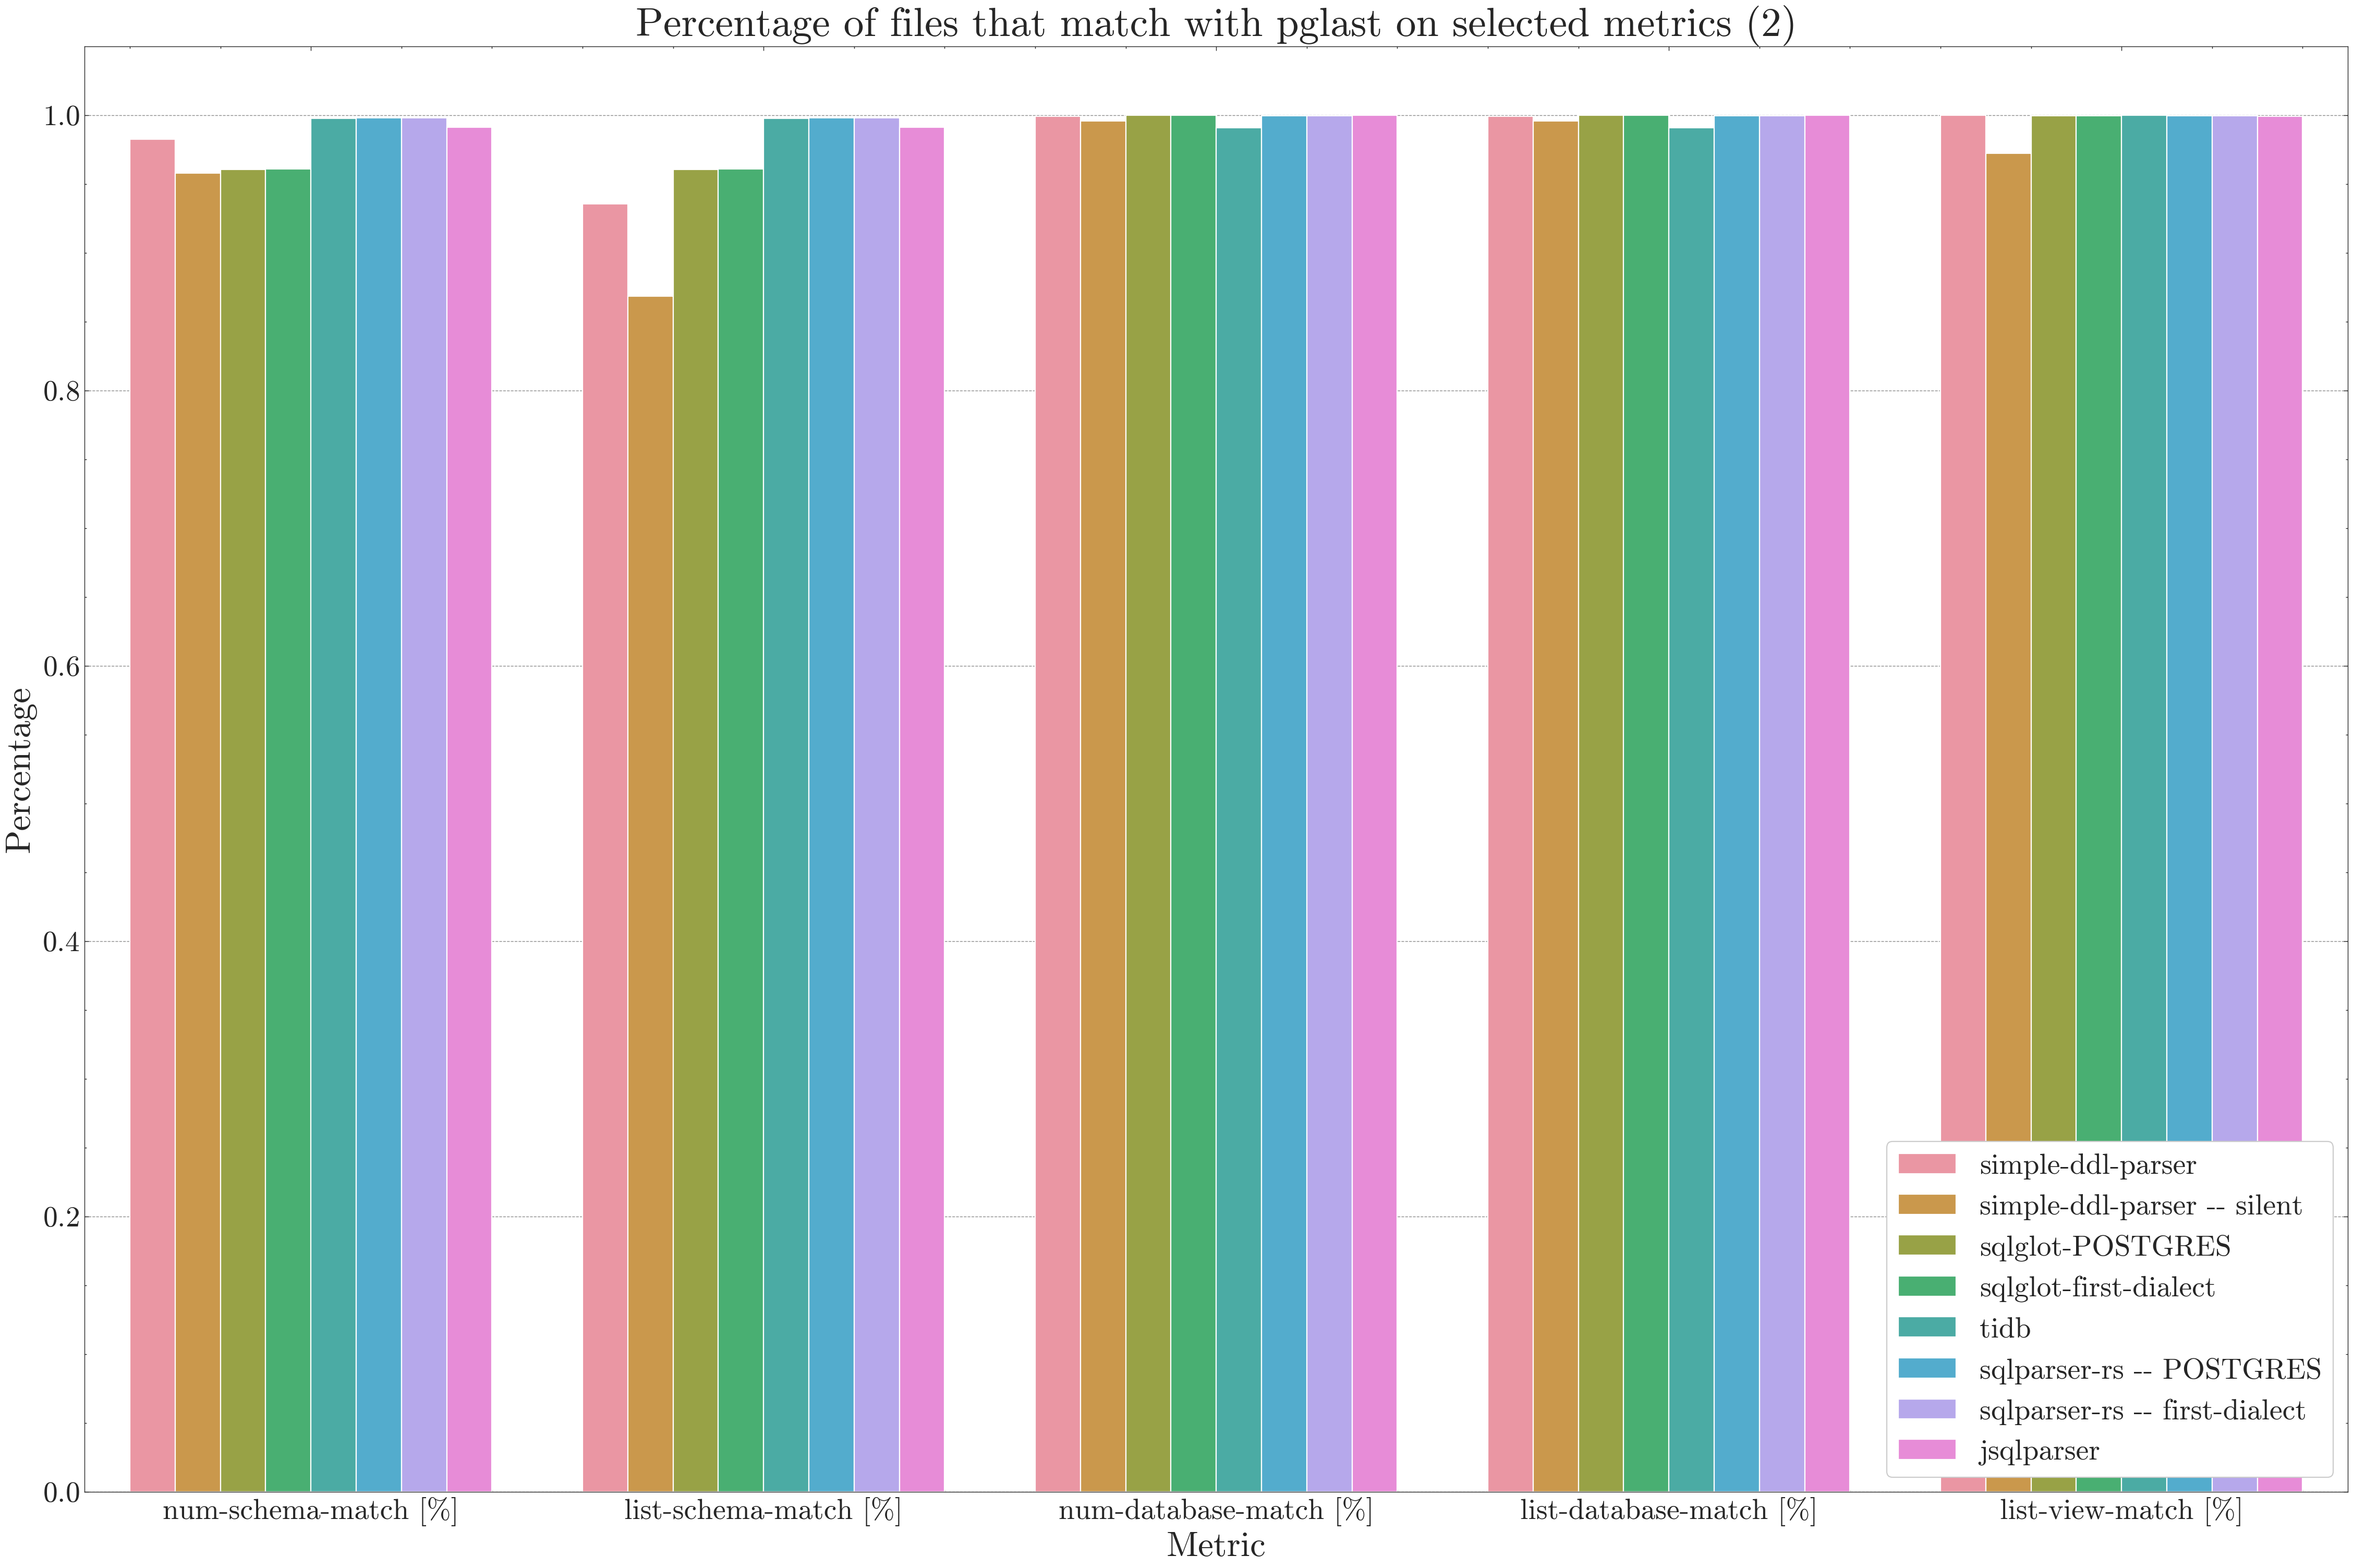

In [195]:
import scienceplots
plt.style.use(['science','no-latex','grid','high-contrast'])
x = plt.figure(figsize=(28, 18),dpi=200)
import matplotlib.colors as mcolors
ax = sns.barplot(data=db_sch_vw_match.melt(id_vars='Parser',
                                  value_name='perc',var_name='attribute'),
            x='attribute', y='perc',hue='Parser')

ax.set_ylabel("Percentage",fontsize=24)
ax.set_xlabel("Metric",fontsize=24)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
    
x_labels = ax.xaxis.get_ticklabels()
for item in x_labels:
    item.set_text(item.get_text().replace("_",'-'))

ax.xaxis.set_ticklabels(x_labels)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)

ax.legend(loc='lower right',fontsize=20)

ax.set_title('Percentage of files that match with pglast on selected metrics (2)',fontsize=28)


### constraints match

In [1]:
display(ctr_match_raw)

NameError: name 'ctr_match_raw' is not defined

In [194]:
print(ctr_match_raw.to_latex(
    index=False,
    float_format="{:.3f}".format
))

\begin{tabular}{lllll}
\toprule
                       Parser & num\_notnull\_constraint\_match [\% of matched files] & num\_unique\_constraint\_match [\% of matched files] & num\_primary\_constraint\_match [\% of matched files] & num\_foreign\_constraint\_match [\% of matched files] \\
\midrule
simple-ddl-parser & 16635 [64.464] & 24187 [93.73] & 17477 [67.727] & 9598 [37.194] \\
simple-ddl-parser -- silent & 31360 [57.464] & 47930 [87.827] & 30069 [55.099] & 16188 [29.663] \\
sqlglot-POSTGRES & 36532 [91.316] & 34763 [86.894] & 25282 [63.196] & 37411 [93.513] \\
sqlglot-first-dialect & 37591 [90.155] & 36075 [86.519] & 26388 [63.287] & 38622 [92.628] \\
tidb & 13266 [79.719] & 13266 [79.719] & 16641 [100.0] & 16641 [100.0] \\
sqlparser-rs -- POSTGRES & 43151 [99.569] & 43335 [99.993] & 43333 [99.988] & 43333 [99.988] \\
sqlparser-rs -- first-dialect & 43193 [99.569] & 43377 [99.993] & 43375 [99.988] & 43375 [99.988] \\
jsqlparser & 41185 [98.053] & 41656 [99.174] & 40923 [97.429] & 4

C:\Users\geacu\AppData\Local\Temp\ipykernel_11152\2305771701.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(ctr_match_raw.to_latex(


C:\Users\geacu\AppData\Local\Temp\ipykernel_11152\671936544.py:13: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(20)
C:\Users\geacu\AppData\Local\Temp\ipykernel_11152\671936544.py:21: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(20)


Text(0.5, 1.0, 'Percentage of files that match with pglast on selected metrics (3)')

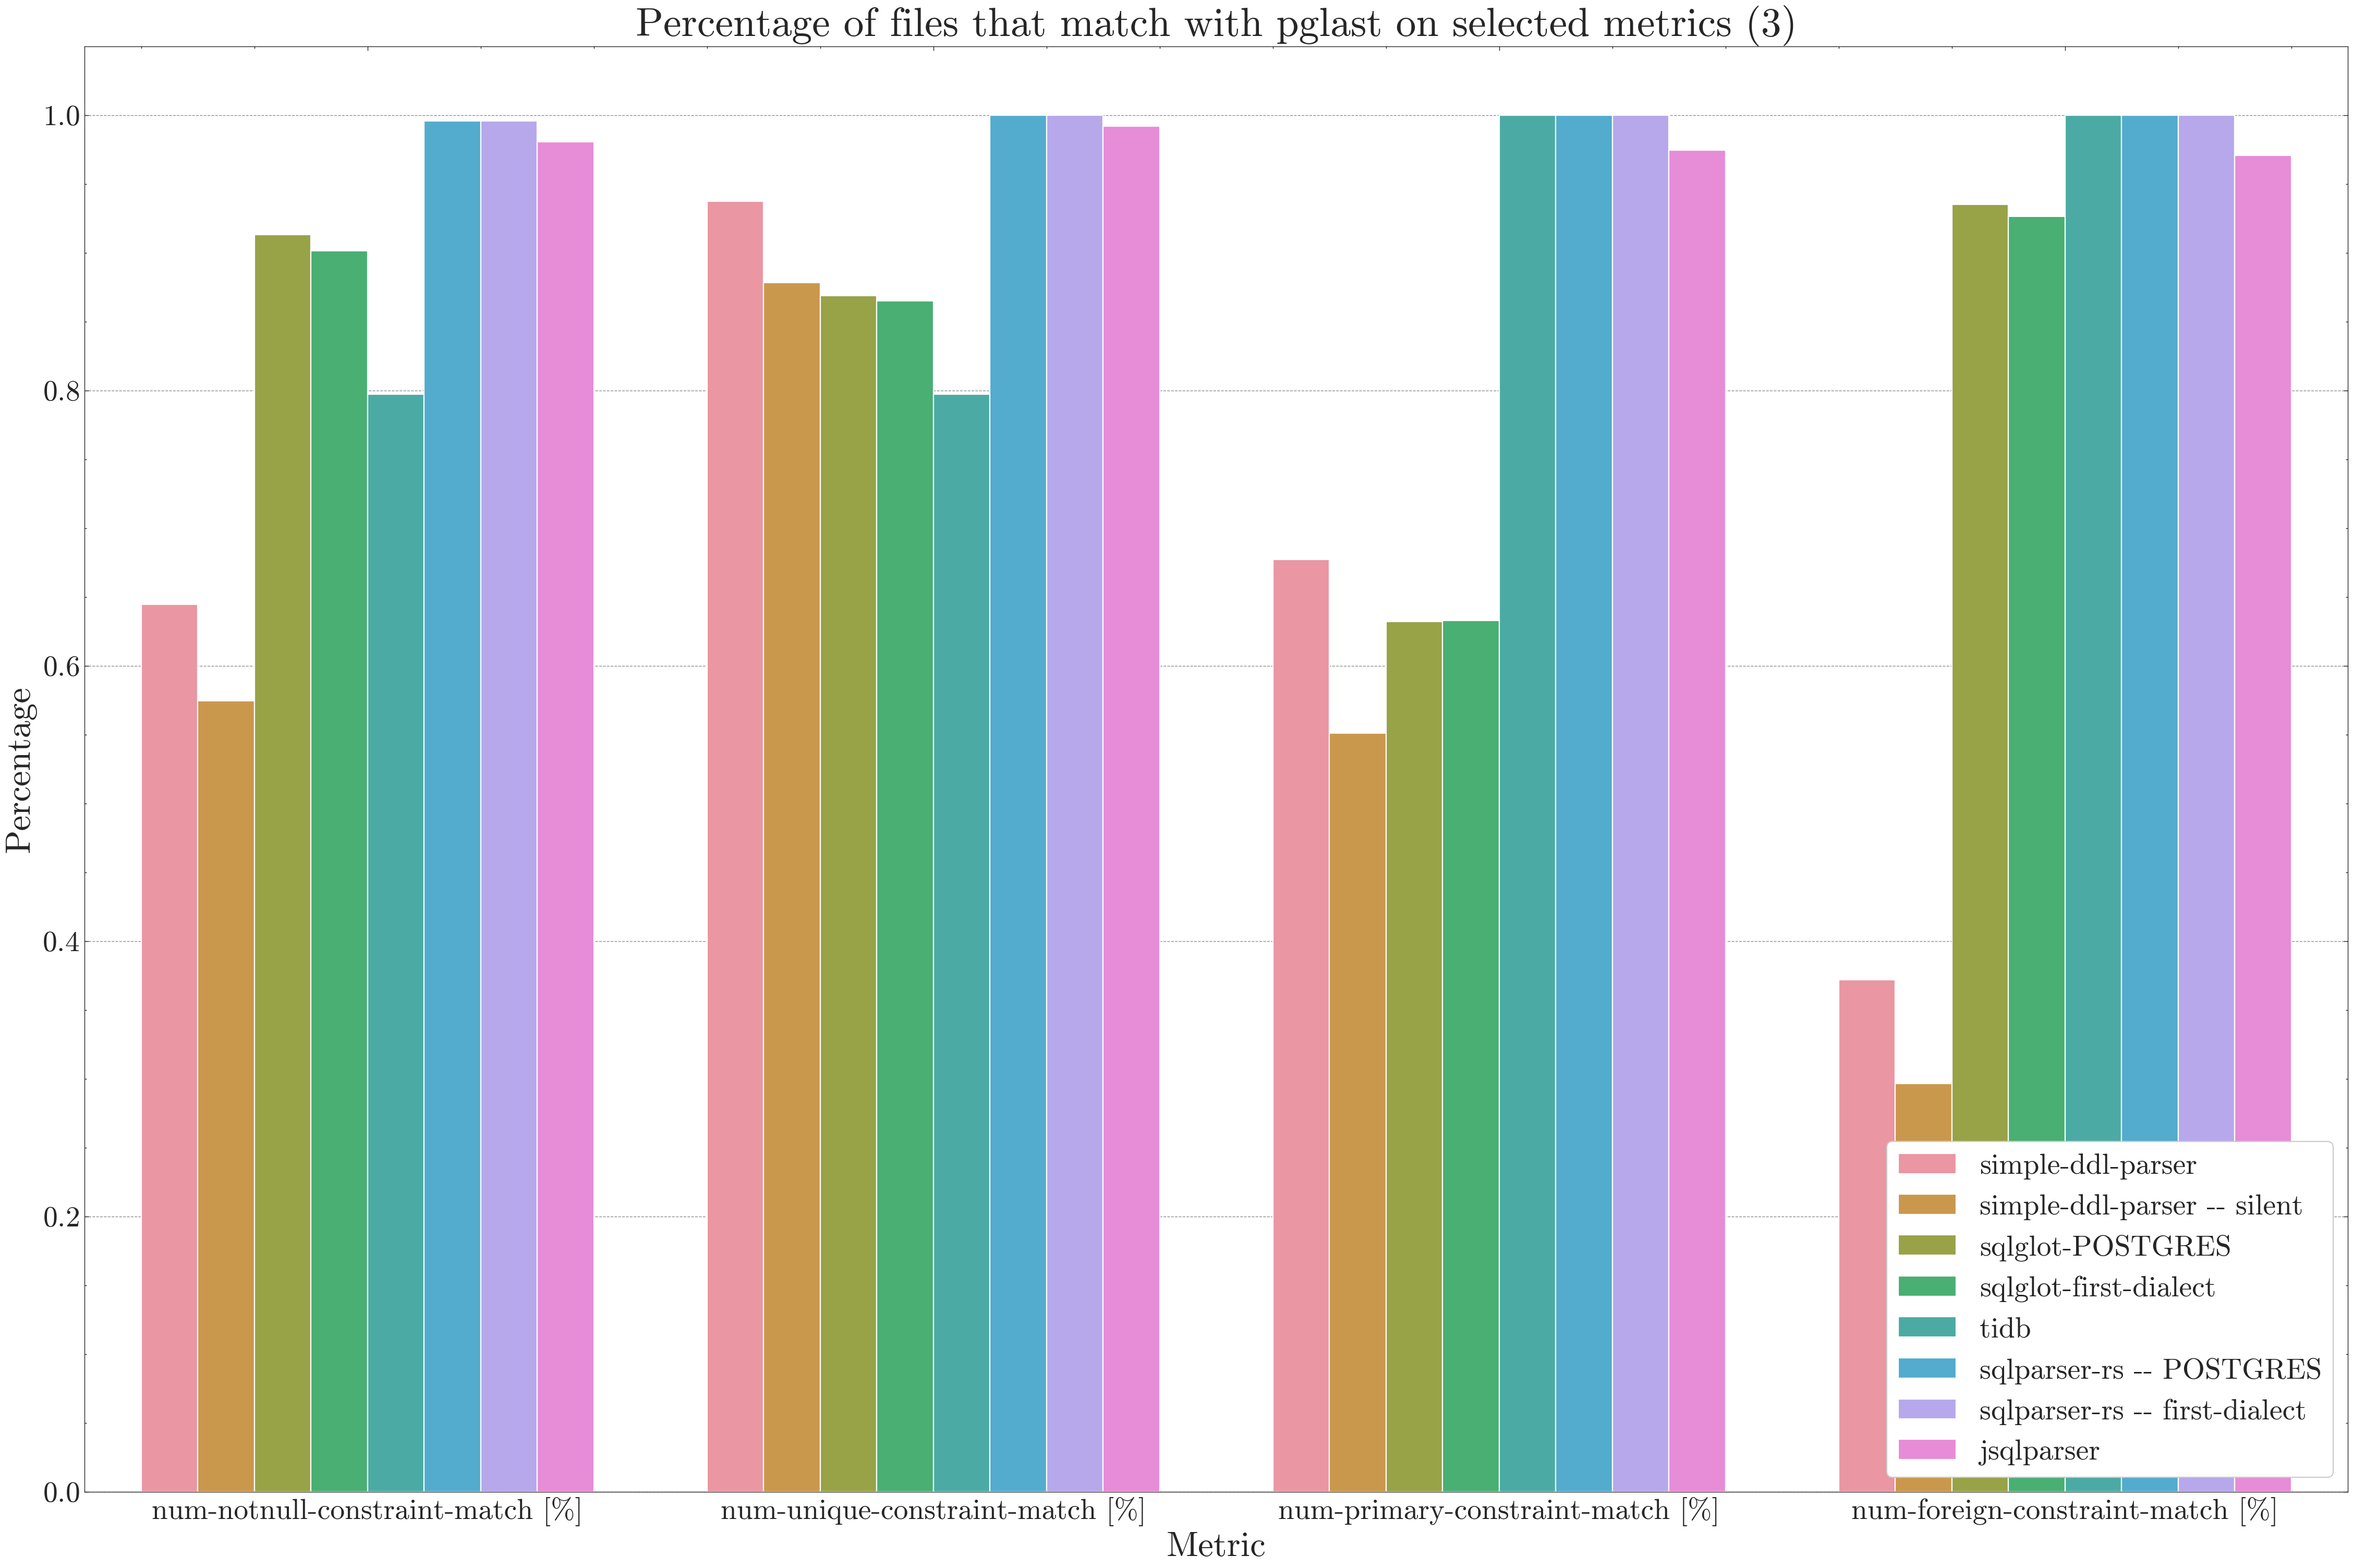

In [196]:
import scienceplots
plt.style.use(['science','no-latex','grid','high-contrast'])
x = plt.figure(figsize=(28, 18),dpi=200)
import matplotlib.colors as mcolors
ax = sns.barplot(data=ctr_match.melt(id_vars='Parser',
                                  value_name='perc',var_name='attribute'),
            x='attribute', y='perc',hue='Parser')

ax.set_ylabel("Percentage",fontsize=24)
ax.set_xlabel("Metric",fontsize=24)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
    
x_labels = ax.xaxis.get_ticklabels()
for item in x_labels:
    item.set_text(item.get_text().replace("_",'-'))

ax.xaxis.set_ticklabels(x_labels)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)

ax.legend(loc='lower right',fontsize=20)

ax.set_title('Percentage of files that match with pglast on selected metrics (3)',fontsize=28)


### Tidb proof

In [27]:
# for NN/UK -> TiDB interprets SERIAL as both
# dq check
parsed_by_pglast_and_tidb = joined_ddf[(joined_ddf.tidb_parsed_file == 1) & (joined_ddf.pglast_parsed_file == 1)]
display(parsed_by_pglast_and_tidb['file_id'].count().compute())

display(parsed_by_pglast_and_tidb[parsed_by_pglast_and_tidb.pglast_num_ctr_unique != parsed_by_pglast_and_tidb.tidb_num_ctr_unique]['file_id'].count().compute())
display(parsed_by_pglast_and_tidb[parsed_by_pglast_and_tidb.pglast_num_ctr_unique == parsed_by_pglast_and_tidb.tidb_num_ctr_unique]['file_id'].count().compute())
display(parsed_by_pglast_and_tidb[parsed_by_pglast_and_tidb.pglast_num_ctr_unique < parsed_by_pglast_and_tidb.tidb_num_ctr_unique]['file_id'].count().compute())
display(parsed_by_pglast_and_tidb[parsed_by_pglast_and_tidb.pglast_num_ctr_unique > parsed_by_pglast_and_tidb.tidb_num_ctr_unique]['file_id'].count().compute())

print("==================================================================")

display(parsed_by_pglast_and_tidb[parsed_by_pglast_and_tidb.pglast_num_ctr_notnull != parsed_by_pglast_and_tidb.tidb_num_ctr_notnull]['file_id'].count().compute())
display(parsed_by_pglast_and_tidb[parsed_by_pglast_and_tidb.pglast_num_ctr_notnull == parsed_by_pglast_and_tidb.tidb_num_ctr_notnull]['file_id'].count().compute())
display(parsed_by_pglast_and_tidb[parsed_by_pglast_and_tidb.pglast_num_ctr_notnull < parsed_by_pglast_and_tidb.tidb_num_ctr_notnull]['file_id'].count().compute())
display(parsed_by_pglast_and_tidb[parsed_by_pglast_and_tidb.pglast_num_ctr_notnull > parsed_by_pglast_and_tidb.tidb_num_ctr_notnull]['file_id'].count().compute())

[########################################] | 100% Completed | 2.21 sms


16641

[########################################] | 100% Completed | 16.04 s


3375

[########################################] | 100% Completed | 15.84 s


13266

[########################################] | 100% Completed | 15.87 s


3375

[########################################] | 100% Completed | 15.90 s


0

[########################################] | 100% Completed | 15.63 s


3375

[########################################] | 100% Completed | 15.46 s


13266

[########################################] | 100% Completed | 15.81 s


3375

[########################################] | 100% Completed | 15.95 s


0

## Intersections

In [10]:
# excluding SDP
cols = ["file_id",
        "pglast_parsed_file", "pglast_num_statements", 
        "sqlglot_parsed", "sqlglot_parsed_none", "sqlglot_parsed_postgres", "sqlglot_parsed_mysql", "sqlglot_parsed_tsql", "sqlglot_dialect", "sqlglot_num_statements",
        "tidb_parsed_file","tidb_num_statements",
        "rustparser_parsed", "rustparser_parsed_generic", "rustparser_parsed_ansi", "rustparser_parsed_postgres", "rustparser_parsed_mysql", "rustparser_parsed_ms", "rustparser_dialect", "rustparser_num_statements",
        "rustparser_errors_at_read",
        "jsql_errors_at_read", "jsql_parsed_file", "jsql_num_statements",
        "jsql_valid_ansi","jsql_valid_oracle","jsql_valid_mysql","jsql_valid_postgres","jsql_valid_sqlserver",
        "pglast_file_parse_error", "pglast_errors_at_read", 
        "sqlglot_parse_error", "sqlglot_file_parse_error_start_context", "sqlglot_file_parse_error_highlight", "sqlglot_errors_at_read", 
         "tidb_file_parse_error", "tidb_errors_at_read", 
        "rustparser_parse_error", 
        "jsql_file_parse_error", "jsql_file_parse_error_with_brackets",
        "pglast_original", "pglast_original_highlight",
]

sum_cols = ["pglast_parsed_file", "sqlglot_parsed", "tidb_parsed_file", "rustparser_parsed", "jsql_parsed_file"]

parsed_ddf = joined_ddf[cols]

parsed_ddf['parsed_by_number'] = parsed_ddf[sum_cols].sum(axis=1)

### Trying chatgpt

In [11]:
# read chatgpt

cols = ['file_id','error','finish_reason','orig_response','used_tokens', 'table_list', 'column_list', 'schema_list', 'db_list',
        'view_list', 'num_ctr_notnull', 'num_ctr_unique', 'num_ctr_primary', 'num_ctr_foreign']

# Read file details
fd = []
for file in os.listdir('../out_new/chatgpt/'):
        full_filename = "%s/%s" % ('../out_new/chatgpt/', file)
        with open(full_filename,'r') as fi:
            dict = json.load(fi)
            fd.append(dict)

chatgpt_df = pd.DataFrame.from_dict(fd)
del fd

In [13]:
gpt_parsed_ddf = dd.merge(
    parsed_ddf,
    chatgpt_df,
    on=['file_id'],
     how='inner',indicator=False,suffixes=['_chatgpt','_parsers']).compute()

[########################################] | 100% Completed | 5.86 sms


In [15]:
gpt_parsed_ddf.groupby('parsed_by_number').count()

,file_id,pglast_parsed_file,pglast_num_statements,sqlglot_parsed,sqlglot_parsed_none,sqlglot_parsed_postgres,sqlglot_parsed_mysql,sqlglot_parsed_tsql,sqlglot_dialect,sqlglot_num_statements,tidb_parsed_file,tidb_num_statements,rustparser_parsed,rustparser_parsed_generic,rustparser_parsed_ansi,rustparser_parsed_postgres,rustparser_parsed_mysql,rustparser_parsed_ms,rustparser_dialect,rustparser_num_statements,rustparser_errors_at_read,jsql_errors_at_read,jsql_parsed_file,jsql_num_statements,jsql_valid_ansi,jsql_valid_oracle,jsql_valid_mysql,jsql_valid_postgres,jsql_valid_sqlserver,pglast_file_parse_error,pglast_errors_at_read,sqlglot_parse_error,sqlglot_file_parse_error_start_context,sqlglot_file_parse_error_highlight,sqlglot_errors_at_read,tidb_file_parse_error,tidb_errors_at_read,rustparser_parse_error,jsql_file_parse_error,jsql_file_parse_error_with_brackets,pglast_original,pglast_original_highlight,error,finish_reason,orig_response,used_tokens,table_list,column_list,schema_list,db_list,view_list,num_ctr_notnull,num_ctr_unique,num_ctr_primary,num_ctr_foreign
parsed_by_number,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1698,1698,1698,1698,1698,1698,1698,1698,0,1698,1698,1698,1698,1698,1698,1698,1698,1698,0,1698,1698,1698,1698,1698,0,0,0,0,0,0,1698,1698,1698,1698,1698,1698,1698,1698,1698,1697,0,0,1698,1698,1698,1698,1698,1698,1698,1698,1698,1698,1698,1698,1698
2,397,397,397,397,397,397,397,397,0,397,397,397,397,397,397,397,397,397,122,397,397,397,397,397,275,275,275,275,275,0,397,397,397,397,397,397,397,275,122,122,0,0,397,397,397,397,397,397,397,397,397,397,397,397,397
3,346,346,346,346,346,346,346,346,0,346,346,346,346,346,346,346,346,346,346,346,346,346,346,346,346,346,346,346,346,0,346,346,346,346,346,346,346,0,0,0,0,0,346,346,346,346,346,346,346,346,346,346,346,346,346


### Done

In [119]:
parsed_ddf.count().compute()

[                                        ] | 0% Completed | 4.47 ms

[########################################] | 100% Completed | 8.37 sms


file_id                                   373156
pglast_parsed_file                        373156
pglast_num_statements                     63937 
sqlglot_parsed                            373156
sqlglot_parsed_none                       373156
sqlglot_parsed_postgres                   373156
sqlglot_parsed_mysql                      373156
sqlglot_parsed_tsql                       373156
sqlglot_dialect                           31370 
sqlglot_num_statements                    373156
tidb_parsed_file                          373156
tidb_num_statements                       373156
rustparser_parsed                         373156
rustparser_parsed_generic                 373156
rustparser_parsed_ansi                    373156
rustparser_parsed_postgres                373156
rustparser_parsed_mysql                   373156
rustparser_parsed_ms                      373156
rustparser_dialect                        93179 
rustparser_num_statements                 373156
rustparser_errors_at

In [47]:
parsed_ddf.groupby('parsed_by_number')['parsed_by_number'].count().compute()

[########################################] | 100% Completed | 4.77 sms


parsed_by_number
0    89693 
1    135290
2    62877 
3    38795 
4    34515 
5    11986 
Name: parsed_by_number, dtype: int64

In [56]:
parsed_ddf.groupby(['parsed_by_number'] + sum_cols)['file_id'].count().compute().reset_index().to_excel("file_level_parsed_by_number_grped_by.xlsx") 

[                                        ] | 0% Completed | 931.70 us

[########################################] | 100% Completed | 5.20 sms


In [57]:
venn_not_parsed = parsed_ddf[parsed_ddf.parsed_by_number == 0]['file_id'].compute().tolist()
venn_pglast = parsed_ddf[parsed_ddf.pglast_parsed_file == 1]['file_id'].compute().tolist()
venn_tidb = parsed_ddf[parsed_ddf.tidb_parsed_file == 1]['file_id'].compute().tolist()
venn_sqlglot_all = parsed_ddf[parsed_ddf.sqlglot_parsed == 1]['file_id'].compute().tolist()
venn_rust_all = parsed_ddf[parsed_ddf.rustparser_parsed == 1]['file_id'].compute().tolist()
venn_jsql = parsed_ddf[parsed_ddf.jsql_parsed_file == 1]['file_id'].compute().tolist()

[########################################] | 100% Completed | 5.26 sms
[########################################] | 100% Completed | 4.89 sms
[########################################] | 100% Completed | 6.10 sms
[########################################] | 100% Completed | 6.58 ss
[########################################] | 100% Completed | 5.87 ss
[########################################] | 100% Completed | 5.74 sms


In [75]:
parsed_ddf[parsed_ddf.sqlglot_parsed == 1].groupby('sqlglot_dialect',dropna=False)['file_id'].count().compute()

[                                        ] | 0% Completed | 3.05 ms

[########################################] | 100% Completed | 5.26 sms


sqlglot_dialect
mysql         12263
postgres      14371
redshift      61   
snowflake     3    
sqlite        14   
tsql          4322 
NaN           59938
duckdb        79   
hive          130  
oracle        52   
teradata      49   
bigquery      23   
databricks    3    
Name: file_id, dtype: int64

In [76]:
parsed_ddf[parsed_ddf.rustparser_parsed == 1].groupby('rustparser_dialect',dropna=False)['file_id'].count().compute()

[########################################] | 100% Completed | 4.26 sms


rustparser_dialect
ansi         518  
generic      70940
ms           1465 
mysql        15516
postgres     1731 
snowflake    2247 
sqlite       514  
hive         182  
bigquery     66   
Name: file_id, dtype: int64

In [117]:
parsed_ddf[(parsed_ddf.pglast_parsed_file == 1)]['file_id'].count().compute()

[########################################] | 100% Completed | 4.61 sms


63937

In [97]:
parsed_ddf[(parsed_ddf.tidb_parsed_file == 1)]['file_id'].count().compute()

[########################################] | 100% Completed | 5.08 sms


209133

In [93]:
parsed_ddf[(parsed_ddf.sqlglot_parsed_tsql == 0) &
           (parsed_ddf.sqlglot_parsed_mysql == 0) & 
           (parsed_ddf.sqlglot_parsed_none == 0) &
           (parsed_ddf.sqlglot_parsed_postgres == 0) &
           (parsed_ddf.sqlglot_parsed == 1)]['file_id'].count().compute()

[                                        ] | 0% Completed | 1.66 ms

[########################################] | 100% Completed | 5.29 sms


2554

In [94]:
parsed_ddf[(parsed_ddf.rustparser_parsed_ansi == 0) &
           (parsed_ddf.rustparser_parsed_mysql == 0) & 
           (parsed_ddf.rustparser_parsed_postgres == 0) &
           (parsed_ddf.rustparser_parsed_ms == 0) &
           (parsed_ddf.rustparser_parsed == 1)]['file_id'].count().compute()

[########################################] | 100% Completed | 5.57 sms


3287

In [95]:
parsed_ddf[(parsed_ddf.jsql_parsed_file == 1) &
           (parsed_ddf.jsql_valid_sqlserver == 0) & 
            (parsed_ddf.jsql_valid_mysql == 0) &
             (parsed_ddf.jsql_valid_postgres == 0) &
             (parsed_ddf.jsql_valid_ansi == 0)]['file_id'].count().compute()

[                                        ] | 0% Completed | 576.10 us

[########################################] | 100% Completed | 5.10 sms


3901

In [98]:
venn_sqlglot_postgres = parsed_ddf[parsed_ddf.sqlglot_parsed_postgres == 1]['file_id'].compute().tolist()
venn_sqlglot_mysql = parsed_ddf[parsed_ddf.sqlglot_parsed_mysql == 1]['file_id'].compute().tolist()

venn_rust_postgres = parsed_ddf[parsed_ddf.rustparser_parsed_postgres == 1]['file_id'].compute().tolist()
venn_rust_mysql = parsed_ddf[parsed_ddf.rustparser_parsed_mysql == 1]['file_id'].compute().tolist()

venn_jsql_postgres = parsed_ddf[(parsed_ddf.jsql_parsed_file == 1) & (parsed_ddf.jsql_valid_postgres == 1)]['file_id'].compute().tolist()
venn_jsql_mysql = parsed_ddf[(parsed_ddf.jsql_parsed_file == 1) & (parsed_ddf.jsql_valid_mysql == 1)]['file_id'].compute().tolist()

[########################################] | 100% Completed | 5.77 sms
[########################################] | 100% Completed | 5.41 sms
[########################################] | 100% Completed | 4.56 sms
[########################################] | 100% Completed | 4.77 sms
[########################################] | 100% Completed | 5.36 sms
[########################################] | 100% Completed | 4.85 sms


In [ ]:
"sqlglot_parsed_none", "sqlglot_parsed_postgres", "sqlglot_parsed_mysql", "sqlglot_parsed_tsql", "sqlglot_dialect"
"rustparser_parsed_generic", "rustparser_parsed_ansi", "rustparser_parsed_postgres", "rustparser_parsed_mysql", "rustparser_parsed_ms", "rustparser_dialect"
"jsql_valid_ansi","jsql_valid_oracle","jsql_valid_mysql","jsql_valid_postgres","jsql_valid_sqlserver",

Text(0.5, 1.0, 'Intersection between files identified as\n MySQL by different parsers')

<Figure size 5600x3600 with 0 Axes>

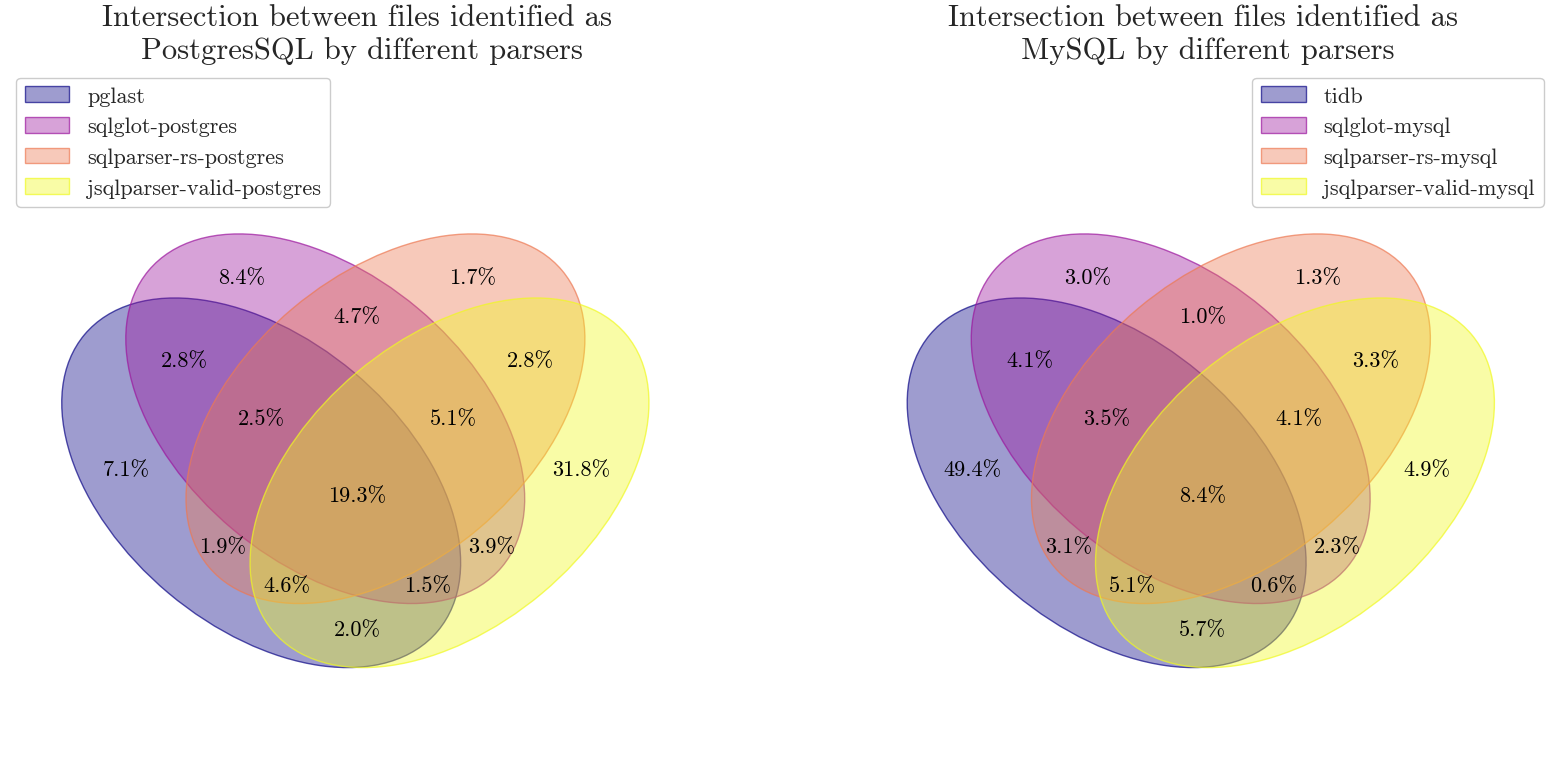

In [115]:
from venn import venn, pseudovenn
import scienceplots
plt.style.use(['science','no-latex','grid','high-contrast'])
fig = plt.figure(figsize=(28, 18),dpi=200)

f, ax = plt.subplots(1, 2)

f.set_size_inches((20,20))

venn_1 = {
    "pglast": set(venn_pglast),
    "sqlglot-postgres": set(venn_sqlglot_postgres),
    "sqlparser-rs-postgres": set(venn_rust_postgres),
    "jsqlparser-valid-postgres": set(venn_jsql_postgres)
}
venn(venn_1, fmt="{percentage:.1f}%", 
cmap="plasma",ax=ax[0],fontsize=16, legend_loc="upper left")

venn_2 = {
    "tidb": set(venn_tidb),
    "sqlglot-mysql": set(venn_sqlglot_mysql),
    "sqlparser-rs-mysql": set(venn_rust_mysql),
    "jsqlparser-valid-mysql": set(venn_jsql_mysql)
}
venn(venn_2, fmt="{percentage:.1f}%", 
cmap="plasma",ax=ax[1],fontsize=16, legend_loc="upper right")

ax[0].set_title('Intersection between files identified as\n PostgresSQL by different parsers',fontsize=22)
ax[1].set_title('Intersection between files identified as\n MySQL by different parsers',fontsize=22)

Text(0.5, 1.0, 'Intersection between files identified as\n MySQL by different parsers')

<Figure size 5600x3600 with 0 Axes>

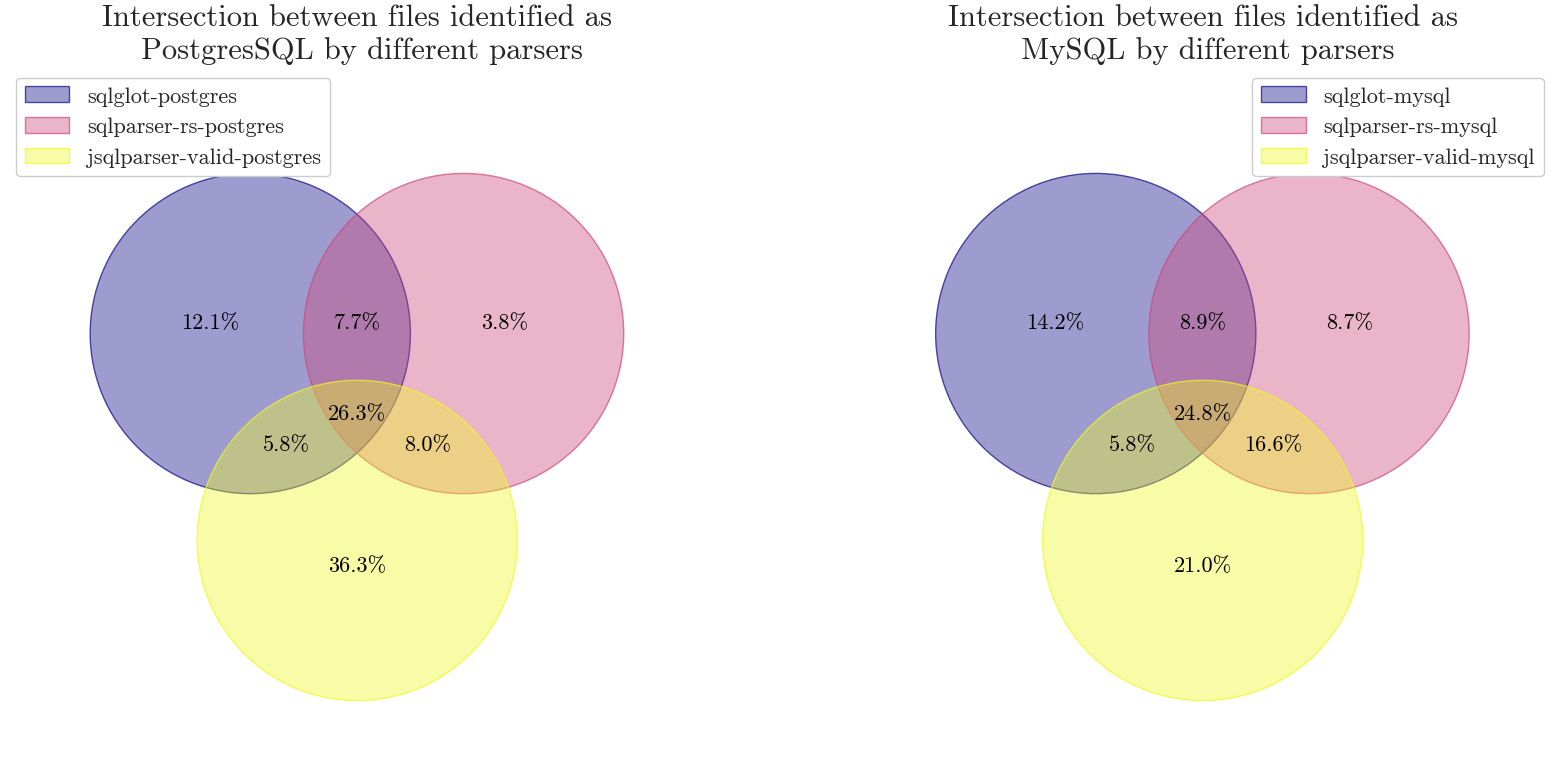

In [116]:
from venn import venn, pseudovenn
import scienceplots
plt.style.use(['science','no-latex','grid','high-contrast'])
fig = plt.figure(figsize=(28, 18),dpi=200)

f, ax = plt.subplots(1, 2)

f.set_size_inches((20,20))

venn_1 = {
    #"pglast": set(venn_pglast),
    "sqlglot-postgres": set(venn_sqlglot_postgres),
    "sqlparser-rs-postgres": set(venn_rust_postgres),
    "jsqlparser-valid-postgres": set(venn_jsql_postgres)
}
venn(venn_1, fmt="{percentage:.1f}%", 
cmap="plasma",ax=ax[0],fontsize=16, legend_loc="upper left")

venn_2 = {
    #"tidb": set(venn_tidb),
    "sqlglot-mysql": set(venn_sqlglot_mysql),
    "sqlparser-rs-mysql": set(venn_rust_mysql),
    "jsqlparser-valid-mysql": set(venn_jsql_mysql)
}
venn(venn_2, fmt="{percentage:.1f}%", 
cmap="plasma",ax=ax[1],fontsize=16, legend_loc="upper right")

ax[0].set_title('Intersection between files identified as\n PostgresSQL by different parsers',fontsize=22)
ax[1].set_title('Intersection between files identified as\n MySQL by different parsers',fontsize=22)

<Axes: >

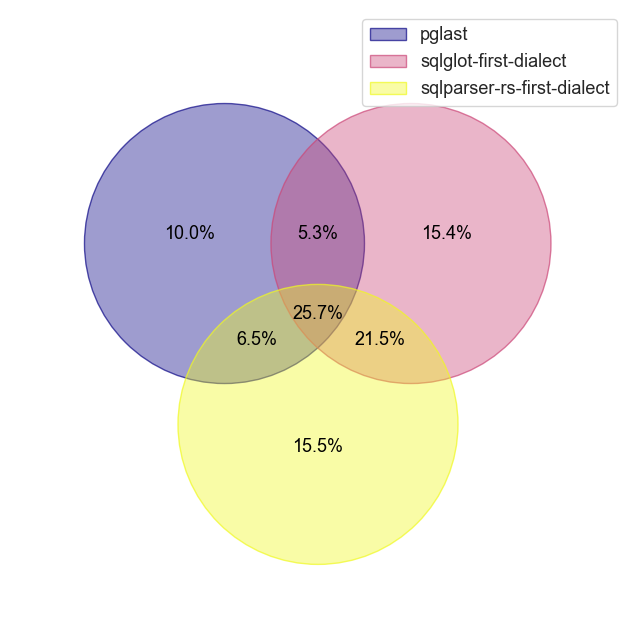

In [71]:
from venn import venn, pseudovenn

venn_all = {
    #"not-parsed": set(venn_not_parsed),
    "pglast": set(venn_pglast),
    #"tidb": set(venn_tidb),
    "sqlglot-first-dialect": set(venn_sqlglot_all),
    "sqlparser-rs-first-dialect": set(venn_rust_all),
    #"jsqlparser": set(venn_jsql)
}
venn(venn_all, fmt="{percentage:.1f}%", 
cmap="plasma")

### Stmt level

In [123]:
# excluding SDP
stmt_parsed_ddf = joined_stmt_ddf

sum_cols = ["pglast_parsed", "sqlglot_parsed", "tidb_parsed", "rust_parsed", "jsql_parsed"]

stmt_parsed_ddf['parsed_by_number'] = stmt_parsed_ddf[sum_cols].sum(axis=1)

In [121]:
joined_stmt_ddf['file_id'].count().compute()

[########################################] | 100% Completed | 9.65 ss


24627506

In [124]:
stmt_parsed_ddf.groupby('parsed_by_number')['parsed_by_number'].count().compute(scheduler='processes')

[                                        ] | 0% Completed | 793.60 us

[########################################] | 100% Completed | 28.41 s


parsed_by_number
0.0    454392  
1.0    1109560 
2.0    1890663 
3.0    2318162 
4.0    14289614
5.0    4565115 
Name: parsed_by_number, dtype: int64

In [126]:
parsed_ddf[parsed_ddf.parsed_by_number == 5][['file_id','pglast_num_statements','sqlglot_num_statements',
                                              'tidb_num_statements','rustparser_num_statements','jsql_num_statements']].head()

[                                        ] | 0% Completed | 852.80 us

[########################################] | 100% Completed | 104.87 ms


,file_id,pglast_num_statements,sqlglot_num_statements,tidb_num_statements,rustparser_num_statements,jsql_num_statements
37,213349,8.0,8,8,8,8
43,101426,2.0,2,2,2,2
98,452618,25.0,25,25,25,25
193,621175,81.0,81,81,81,81
203,362536,5.0,5,5,5,5


In [129]:
parsable_by_all_file_ids = parsed_ddf[parsed_ddf.parsed_by_number == 5]['file_id'].compute().to_frame()

[########################################] | 100% Completed | 5.41 sms


In [131]:
merged_stmt_with_files_parsable_by_all = dd.merge(
    stmt_parsed_ddf,
    parsable_by_all_file_ids,
    on=['file_id'],how='inner',indicator=False
)

In [135]:
num_stmts_from_sqlparser_for_files_parsable_by_all = merged_stmt_with_files_parsable_by_all.groupby('file_id')['statement_nr'].count().compute().to_frame().reset_index()

[########################################] | 100% Completed | 56.84 s


In [136]:
num_stmts_comparison = dd.merge(
parsed_ddf[parsed_ddf.parsed_by_number == 5][['file_id','pglast_num_statements','sqlglot_num_statements',
                                              'tidb_num_statements','rustparser_num_statements','jsql_num_statements']],
num_stmts_from_sqlparser_for_files_parsable_by_all,
on=['file_id'],how='inner',indicator=False,suffixes=['file','_stmt_sqlparser']
)

In [138]:
num_stmts_comparison.compute().reset_index().to_excel("files_parsed_by_all_num_stmts_comparison_incl_sqlparser.xlsx") 

[########################################] | 100% Completed | 6.08 ss


# Seeing if correlation btwn file details and parsability

In [45]:
# Read file details
fd = []
for file in os.listdir('../out_new/filedetails/'):
        full_filename = "%s/%s" % ('../out_new/filedetails/', file)
        with open(full_filename,'r') as fi:
            dict = json.load(fi)
            for item in dict:
                  fd.append(item)

filedetails_df = pd.DataFrame.from_dict(fd)
del fd

In [11]:
# excluding SDP
cols = ["file_id",
        "pglast_parsed_file", "pglast_num_statements", 
        "sqlglot_parsed", "sqlglot_parsed_none", "sqlglot_parsed_postgres", "sqlglot_parsed_mysql", "sqlglot_parsed_tsql", "sqlglot_dialect", "sqlglot_num_statements",
        "tidb_parsed_file","tidb_num_statements",
        "rustparser_parsed", "rustparser_parsed_generic", "rustparser_parsed_ansi", "rustparser_parsed_postgres", "rustparser_parsed_mysql", "rustparser_parsed_ms", "rustparser_dialect", "rustparser_num_statements",
        "rustparser_errors_at_read",
        "jsql_errors_at_read", "jsql_parsed_file", "jsql_num_statements",
        "jsql_valid_ansi","jsql_valid_oracle","jsql_valid_mysql","jsql_valid_postgres","jsql_valid_sqlserver",
        "pglast_file_parse_error", "pglast_errors_at_read", 
        "sqlglot_parse_error", "sqlglot_file_parse_error_start_context", "sqlglot_file_parse_error_highlight", "sqlglot_errors_at_read", 
         "tidb_file_parse_error", "tidb_errors_at_read", 
        "rustparser_parse_error", 
        "jsql_file_parse_error", "jsql_file_parse_error_with_brackets",
        "pglast_original", "pglast_original_highlight",
]

sum_cols = ["pglast_parsed_file", "sqlglot_parsed", "tidb_parsed_file", "rustparser_parsed", "jsql_parsed_file"]

parsed_ddf = joined_ddf[cols]

parsed_ddf['parsed_by_number'] = parsed_ddf[sum_cols].sum(axis=1)
parsed_subset_file_corr = parsed_ddf[['file_id','parsed_by_number', 'pglast_errors_at_read']].compute()

[########################################] | 100% Completed | 4.11 sms


In [51]:
filedetails_df['char_bin'],_ = pd.qcut(filedetails_df['char_nr'], q=25, precision=1,labels=range(0,25),retbins=True)
filedetails_df['char_bin']=filedetails_df['char_bin'].astype('int')

In [55]:
filedetails_df['line_bin'],_ = pd.qcut(filedetails_df['line_nr'], q=25, precision=1,labels=range(0,25),retbins=True)
filedetails_df['line_bin']=filedetails_df['line_bin'].astype('int')

In [56]:
file_correlation = parsed_subset_file_corr.merge(filedetails_df,on=['file_id'])

In [61]:
file_correlation['common_encoding'] = file_correlation.apply(lambda row: 1 if 'UTF-8' in str(row['encoding']).upper() or 'ASCII' in str(row['encoding']).upper() else 0, axis=1)

In [157]:
file_correlation['enc'] = file_correlation.apply(lambda row: 1 if row['encoding'] == 'utf-8' or row['encoding'] == 'ascii' else 0, axis=1)

### Adding num stmts

In [66]:
num_stmts_from_sqlparser_for_all_files = joined_stmt_ddf.groupby('file_id')['statement_nr'].count().compute().to_frame().reset_index()

[                                        ] | 0% Completed | 1.76 ms

[########################################] | 100% Completed | 31.10 s


In [67]:
file_correlation_with_num_stmts = pd.merge(
    file_correlation,num_stmts_from_sqlparser_for_all_files,on=['file_id']
)

In [74]:
file_correlation_with_num_stmts['stmt_bin'],_ = pd.qcut(file_correlation_with_num_stmts['statement_nr'], q=10, precision=1,labels=range(0,9),retbins=True,duplicates='drop')
file_correlation_with_num_stmts['stmt_bin']=file_correlation_with_num_stmts['stmt_bin'].astype('int')

In [78]:
corr_df = file_correlation_with_num_stmts[['parsed_by_number','char_bin','line_bin','common_encoding','statement_nr','encoding_confidence','file_size']]

In [86]:
corr_df.corrwith(corr_df['parsed_by_number'],method='pearson')

parsed_by_number       1.000000
char_bin              -0.304887
line_bin              -0.277563
common_encoding        0.062533
statement_nr          -0.074829
encoding_confidence    0.056743
file_size             -0.114986
dtype: float64

### flag thign

In [81]:
file_correlation_with_num_stmts.head()

,file_id,parsed_by_number,pglast_errors_at_read,file_path,file_size,line_nr,char_nr,encoding,encoding_confidence,char_bin,line_bin,common_encoding,statement_nr,stmt_bin
0,502790,0,0,../sqlfiles/502790_qsystem_H2.sql,50684,863,50684,utf-8,0.99,22,22,1,132,7
1,494894,1,0,../sqlfiles/494894_init.sql,709,22,709,ascii,1.00,3,3,1,5,1
2,286801,1,0,../sqlfiles/286801_basededatos.sql,15004,258,15004,utf-8,0.99,19,18,1,42,6
3,202803,4,0,../sqlfiles/202803_integrityDBCreation.sql,9458,173,9458,ascii,1.00,17,16,1,19,4
4,435266,1,0,../sqlfiles/435266_openmrs_warehouse_mw_epilepsy_initial.sql,5457,117,5457,ascii,1.00,15,14,1,28,4


In [84]:
file_correlation_with_num_stmts.groupby(['pglast_errors_at_read','parsed_by_number'])['file_id'].count()

pglast_errors_at_read  parsed_by_number
0                      0                   89542 
                       1                   134890
                       2                   62819 
                       3                   38780 
                       4                   34507 
                       5                   11981 
1                      0                   151   
                       1                   400   
                       2                   58    
                       3                   15    
                       4                   8     
                       5                   5     
Name: file_id, dtype: int64

In [87]:
file_correlation_with_num_stmts.groupby('encoding')['file_id'].count()

encoding
Big5            41    
CP932           2     
CP949           30    
EUC-JP          73    
EUC-KR          1151  
GB2312          1230  
IBM866          13    
ISO-8859-1      4192  
ISO-8859-5      4     
ISO-8859-7      6     
ISO-8859-8      3     
ISO-8859-9      69    
Johab           103   
KOI8-R          73    
MacCyrillic     38    
MacRoman        3376  
SHIFT_JIS       62    
TIS-620         57    
UTF-8-SIG       22898 
Windows-1252    2214  
Windows-1253    6     
Windows-1254    199   
ascii           249076
utf-8           87128 
windows-1251    939   
windows-1255    12    
Name: file_id, dtype: int64

In [85]:
file_correlation_with_num_stmts.groupby('pglast_errors_at_read')['file_id'].count()

pglast_errors_at_read
0    372519
1    637   
Name: file_id, dtype: int64